In [1]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.contrib.deprecation import deprecated
from dgl.nn.pytorch import Set2Set, NNConv
from utils import MPNNModel
import numpy as np
import time
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from dgl import model_zoo,DGLGraph
import math
import networkx as nx
import matplotlib.pyplot as plt
from utils_mpnn_multitask import Meter, set_random_seed, collate, EarlyStopping,load_brl_dataset,regress
import argparse
# from sklearn import svm, datasets
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn import metrics
import collections
import sys; sys.argv=['']; del sys
parser = argparse.ArgumentParser(description='Molecule Regression')
parser.add_argument('-m', '--model', type=str,default='MPNN',help='Model to use')#choices=['MPNN', 'SCHNET', 'MGCN', 'AttentiveFP'],
#parser.add_argument('-d', '--dataset', type=str, default='bridge',help='Dataset to use')#choices=['Alchemy', 'Aromaticity'],                
parser.add_argument('-p', '--pre-trained', action='store_true', default=False, help='Whether to skip training and use a pre-trained model')
args = parser.parse_args().__dict__
training_setting= {
    'random_seed': 0,
    'batch_size': 64,#64,#
    'num_epochs': 2000,#900,
    'node_in_feats': 7,
    'edge_in_feats': 6,
    #'output_dim': 120,
    'lr': 0.001,#0.001,#
    'patience': 300,#20,
    'metric_name': 'l1',#'roc_auc',#
    'weight_decay': 0,
    'n_task':41,
}
args.update(training_setting)
args['device'] = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
args['data_path_x']='data/data_mpnn/'
args['data_path_label']='data/label_multitask/'
set_random_seed(args['random_seed'])

print(torch.cuda.current_device())
# torch.cuda.set_device(1)
# print(torch.cuda.current_device())

train_loader,val_loader,test_loader=load_brl_dataset(args)#for batch_id, batch_data in enumerate(train_loader):bg, labels = batch_data;print(a)
if args['pre_trained']:
    args['num_epochs'] = 0
    model = model_zoo.chem.load_pretrained(args['exp'])
else:
    #model = load_model(args)
    model = MPNNModel(node_input_dim=args['node_in_feats'],
                      edge_input_dim=args['edge_in_feats'])
    if args['model'] in ['SCHNET', 'MGCN']:
        model.set_mean_std(train_set.mean, train_set.std, args['device'])
    #loss_fn =BCEWithLogitsLoss()#nn.L1Loss(reduction='none')
    loss_fn_cablenumber =nn.CrossEntropyLoss()
    loss_fn_area =nn.L1Loss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    stopper = EarlyStopping(mode='lower', patience=args['patience'],
                            filename='model_saved/multitask/early_stop.pth')

model.to(args['device'])

    
def run_a_train_epoch_cr(args, epoch, model, data_loader,
                      loss_criterion_cablenumber,loss_criterion_area, optimizer):
    model.train()
    train_meter = Meter()
    correct=0
    total=0
    for batch_id, batch_data in enumerate(data_loader):
        bg, labels_cablenumber,labels_area = batch_data
        labels_cablenumber = labels_cablenumber.to(args['device'])
        labels_area = labels_area.to(args['device'])
        labels=[labels_cablenumber,labels_area]
        prediction = regress(args, model, bg)
        
        loss_cablenumber = (loss_criterion_cablenumber(prediction[0], labels_cablenumber).float()).mean()
        loss_area = (loss_criterion_area(prediction[1],labels_area).float()).mean()
        loss=(loss_cablenumber+loss_area)
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_meter.update(prediction[1], labels_area)
        
        _, predicted = torch.max(prediction[0].data, 1)
        total += labels_cablenumber.size(0)
        correct += (predicted == labels_cablenumber).sum().item();del predicted
        
    total_score_acc=100-100 * correct / total
    total_score = np.mean(train_meter.compute_metric(args['metric_name']))
    print('epoch {:d}/{:d}, training {} {:.4f} / accuracy(%) {:.4f}'.format(
        epoch + 1, args['num_epochs'], args['metric_name'], total_score, total_score_acc)) 
    #print('epoch {:d}/{:d}, training total_score_acc {:.4f}'.format(epoch + 1, args['num_epochs'], total_score_acc)) 
    
def run_an_eval_epoch_cr(args, model, data_loader):
    model.eval()
    eval_meter = Meter()
    correct=0
    total=0
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            bg, labels_cablenumber,labels_area = batch_data
            labels_cablenumber = labels_cablenumber.to(args['device'])
            labels_area = labels_area.to(args['device'])
            labels=[labels_cablenumber,labels_area]
            prediction = regress(args, model, bg)
            
            eval_meter.update(prediction[1], labels_area)
            
            _, predicted = torch.max(prediction[0].data, 1)
            total += labels_cablenumber.size(0)
            correct += (predicted == labels_cablenumber).sum().item();del predicted
        total_score_acc=100-100 * correct / total
        total_score = np.mean(eval_meter.compute_metric(args['metric_name']))
    return total_score,total_score_acc

Using backend: pytorch
/home/shs/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0


__main__:108: DeprecationWarning: The class is deprecated and will be removed from dgl in v0.5. Import MPNNPredictor from dgllife.model instead.


/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


epoch 1/2000, training l1 0.2657 / accuracy(%) 99.3128
epoch 1/2000, validation l1 0.2511, accuracy(%) 99.3394, best validation l1 99.3394, time29.7
epoch 2/2000, training l1 0.2323 / accuracy(%) 98.7493
epoch 2/2000, validation l1 0.2187, accuracy(%) 98.5962, best validation l1 98.5962, time30.0
epoch 3/2000, training l1 0.2181 / accuracy(%) 98.1308
epoch 3/2000, validation l1 0.2127, accuracy(%) 98.3485, best validation l1 98.3485, time30.1
epoch 4/2000, training l1 0.2152 / accuracy(%) 98.1171
epoch 4/2000, validation l1 0.2121, accuracy(%) 97.7704, best validation l1 97.7704, time30.2
epoch 5/2000, training l1 0.2150 / accuracy(%) 97.5124
epoch 5/2000, validation l1 0.2097, accuracy(%) 97.1511, best validation l1 97.1511, time30.2
epoch 6/2000, training l1 0.2137 / accuracy(%) 96.7839
epoch 6/2000, validation l1 0.2066, accuracy(%) 95.7060, best validation l1 95.7060, time30.2
epoch 7/2000, training l1 0.2145 / accuracy(%) 96.0418
epoch 7/2000, validation l1 0.2092, accuracy(%) 95.

epoch 51/2000, training l1 0.1282 / accuracy(%) 72.5124
epoch 51/2000, validation l1 0.1209, accuracy(%) 69.9835, best validation l1 69.9835, time30.2
epoch 52/2000, training l1 0.1249 / accuracy(%) 70.7257
EarlyStopping counter: 1 out of 300
epoch 52/2000, validation l1 0.1180, accuracy(%) 70.6854, best validation l1 69.9835, time30.2
epoch 53/2000, training l1 0.1202 / accuracy(%) 69.6949
EarlyStopping counter: 2 out of 300
epoch 53/2000, validation l1 0.1187, accuracy(%) 71.2221, best validation l1 69.9835, time30.2
epoch 54/2000, training l1 0.1194 / accuracy(%) 68.9390
EarlyStopping counter: 3 out of 300
epoch 54/2000, validation l1 0.1225, accuracy(%) 69.9835, best validation l1 69.9835, time30.2
epoch 55/2000, training l1 0.1228 / accuracy(%) 69.7499
EarlyStopping counter: 4 out of 300
epoch 55/2000, validation l1 0.1223, accuracy(%) 70.0661, best validation l1 69.9835, time30.2
epoch 56/2000, training l1 0.1181 / accuracy(%) 69.3650
epoch 56/2000, validation l1 0.1135, accuracy

epoch 97/2000, validation l1 0.0826, accuracy(%) 59.6201, best validation l1 59.6201, time30.2
epoch 98/2000, training l1 0.0909 / accuracy(%) 58.6998
EarlyStopping counter: 1 out of 300
epoch 98/2000, validation l1 0.1028, accuracy(%) 63.1709, best validation l1 59.6201, time30.2
epoch 99/2000, training l1 0.0903 / accuracy(%) 57.6416
epoch 99/2000, validation l1 0.0827, accuracy(%) 59.0834, best validation l1 59.0834, time30.1
epoch 100/2000, training l1 0.0878 / accuracy(%) 56.8994
EarlyStopping counter: 1 out of 300
epoch 100/2000, validation l1 0.0956, accuracy(%) 61.0652, best validation l1 59.0834, time30.1
epoch 101/2000, training l1 0.0878 / accuracy(%) 57.9714
EarlyStopping counter: 2 out of 300
epoch 101/2000, validation l1 0.0856, accuracy(%) 64.9463, best validation l1 59.0834, time30.1
epoch 102/2000, training l1 0.0823 / accuracy(%) 57.3942
EarlyStopping counter: 3 out of 300
epoch 102/2000, validation l1 0.0862, accuracy(%) 59.8679, best validation l1 59.0834, time30.1


EarlyStopping counter: 8 out of 300
epoch 142/2000, validation l1 0.0917, accuracy(%) 55.3675, best validation l1 52.9727, time30.0
epoch 143/2000, training l1 0.0763 / accuracy(%) 51.5118
epoch 143/2000, validation l1 0.0757, accuracy(%) 52.8902, best validation l1 52.8902, time30.1
epoch 144/2000, training l1 0.0715 / accuracy(%) 51.0583
EarlyStopping counter: 1 out of 300
epoch 144/2000, validation l1 0.0676, accuracy(%) 54.6656, best validation l1 52.8902, time30.1
epoch 145/2000, training l1 0.0754 / accuracy(%) 51.6767
EarlyStopping counter: 2 out of 300
epoch 145/2000, validation l1 0.0961, accuracy(%) 64.2857, best validation l1 52.8902, time30.1
epoch 146/2000, training l1 0.0947 / accuracy(%) 56.9131
EarlyStopping counter: 3 out of 300
epoch 146/2000, validation l1 0.0854, accuracy(%) 55.9868, best validation l1 52.8902, time30.1
epoch 147/2000, training l1 0.0856 / accuracy(%) 53.0236
EarlyStopping counter: 4 out of 300
epoch 147/2000, validation l1 0.0867, accuracy(%) 55.53

EarlyStopping counter: 2 out of 300
epoch 187/2000, validation l1 0.0679, accuracy(%) 51.0322, best validation l1 46.3666, time30.1
epoch 188/2000, training l1 0.0720 / accuracy(%) 45.7119
EarlyStopping counter: 3 out of 300
epoch 188/2000, validation l1 0.1007, accuracy(%) 51.4451, best validation l1 46.3666, time30.1
epoch 189/2000, training l1 0.0839 / accuracy(%) 50.7147
EarlyStopping counter: 4 out of 300
epoch 189/2000, validation l1 0.1217, accuracy(%) 59.8679, best validation l1 46.3666, time30.1
epoch 190/2000, training l1 0.0845 / accuracy(%) 51.3606
EarlyStopping counter: 5 out of 300
epoch 190/2000, validation l1 0.0707, accuracy(%) 50.8258, best validation l1 46.3666, time30.1
epoch 191/2000, training l1 0.0657 / accuracy(%) 44.2001
EarlyStopping counter: 6 out of 300
epoch 191/2000, validation l1 0.0616, accuracy(%) 46.6969, best validation l1 46.3666, time30.0
epoch 192/2000, training l1 0.0643 / accuracy(%) 44.7224
EarlyStopping counter: 7 out of 300
epoch 192/2000, val

epoch 231/2000, training l1 0.0835 / accuracy(%) 47.3337
EarlyStopping counter: 35 out of 300
epoch 231/2000, validation l1 0.0839, accuracy(%) 48.9678, best validation l1 44.9216, time30.0
epoch 232/2000, training l1 0.0800 / accuracy(%) 46.1792
EarlyStopping counter: 36 out of 300
epoch 232/2000, validation l1 0.0801, accuracy(%) 51.6102, best validation l1 44.9216, time30.0
epoch 233/2000, training l1 0.0784 / accuracy(%) 45.6295
EarlyStopping counter: 37 out of 300
epoch 233/2000, validation l1 0.0811, accuracy(%) 49.1742, best validation l1 44.9216, time30.0
epoch 234/2000, training l1 0.0760 / accuracy(%) 44.6124
EarlyStopping counter: 38 out of 300
epoch 234/2000, validation l1 0.0751, accuracy(%) 48.4310, best validation l1 44.9216, time30.0
epoch 235/2000, training l1 0.0752 / accuracy(%) 43.5404
EarlyStopping counter: 39 out of 300
epoch 235/2000, validation l1 0.0708, accuracy(%) 46.1602, best validation l1 44.9216, time30.0
epoch 236/2000, training l1 0.0781 / accuracy(%) 4

epoch 275/2000, training l1 0.0640 / accuracy(%) 41.0390
EarlyStopping counter: 3 out of 300
epoch 275/2000, validation l1 0.0595, accuracy(%) 45.3344, best validation l1 43.1462, time30.0
epoch 276/2000, training l1 0.0630 / accuracy(%) 39.8708
EarlyStopping counter: 4 out of 300
epoch 276/2000, validation l1 0.0792, accuracy(%) 46.0363, best validation l1 43.1462, time30.0
epoch 277/2000, training l1 0.0675 / accuracy(%) 41.7949
EarlyStopping counter: 5 out of 300
epoch 277/2000, validation l1 0.0563, accuracy(%) 44.1784, best validation l1 43.1462, time30.0
epoch 278/2000, training l1 0.0613 / accuracy(%) 38.2490
epoch 278/2000, validation l1 0.0587, accuracy(%) 41.4946, best validation l1 41.4946, time30.0
epoch 279/2000, training l1 0.0656 / accuracy(%) 40.7642
EarlyStopping counter: 1 out of 300
epoch 279/2000, validation l1 0.0727, accuracy(%) 47.1924, best validation l1 41.4946, time30.0
epoch 280/2000, training l1 0.0707 / accuracy(%) 44.2139
EarlyStopping counter: 2 out of 30

epoch 319/2000, training l1 0.0705 / accuracy(%) 40.2969
EarlyStopping counter: 3 out of 300
epoch 319/2000, validation l1 0.0613, accuracy(%) 46.0776, best validation l1 40.5037, time29.9
epoch 320/2000, training l1 0.0562 / accuracy(%) 36.8747
EarlyStopping counter: 4 out of 300
epoch 320/2000, validation l1 0.0543, accuracy(%) 42.6507, best validation l1 40.5037, time29.9
epoch 321/2000, training l1 0.0524 / accuracy(%) 37.7130
EarlyStopping counter: 5 out of 300
epoch 321/2000, validation l1 0.0594, accuracy(%) 41.6185, best validation l1 40.5037, time29.9
epoch 322/2000, training l1 0.0538 / accuracy(%) 35.4728
EarlyStopping counter: 6 out of 300
epoch 322/2000, validation l1 0.0534, accuracy(%) 43.3113, best validation l1 40.5037, time29.9
epoch 323/2000, training l1 0.0561 / accuracy(%) 38.0566
EarlyStopping counter: 7 out of 300
epoch 323/2000, validation l1 0.0540, accuracy(%) 43.4352, best validation l1 40.5037, time29.9
epoch 324/2000, training l1 0.0564 / accuracy(%) 38.345

epoch 363/2000, training l1 0.0528 / accuracy(%) 35.6240
EarlyStopping counter: 1 out of 300
epoch 363/2000, validation l1 0.0495, accuracy(%) 39.8844, best validation l1 39.3064, time29.9
epoch 364/2000, training l1 0.0547 / accuracy(%) 35.5965
EarlyStopping counter: 2 out of 300
epoch 364/2000, validation l1 0.0545, accuracy(%) 41.7011, best validation l1 39.3064, time29.9
epoch 365/2000, training l1 0.0603 / accuracy(%) 37.3969
EarlyStopping counter: 3 out of 300
epoch 365/2000, validation l1 0.0583, accuracy(%) 42.5268, best validation l1 39.3064, time29.8
epoch 366/2000, training l1 0.0548 / accuracy(%) 36.9296
EarlyStopping counter: 4 out of 300
epoch 366/2000, validation l1 0.0586, accuracy(%) 40.6689, best validation l1 39.3064, time29.9
epoch 367/2000, training l1 0.0572 / accuracy(%) 36.8747
EarlyStopping counter: 5 out of 300
epoch 367/2000, validation l1 0.0494, accuracy(%) 39.5954, best validation l1 39.3064, time29.9
epoch 368/2000, training l1 0.0504 / accuracy(%) 35.527

epoch 407/2000, training l1 0.0496 / accuracy(%) 33.3425
EarlyStopping counter: 19 out of 300
epoch 407/2000, validation l1 0.0505, accuracy(%) 40.1734, best validation l1 36.7878, time29.8
epoch 408/2000, training l1 0.0463 / accuracy(%) 32.9164
EarlyStopping counter: 20 out of 300
epoch 408/2000, validation l1 0.0486, accuracy(%) 38.8935, best validation l1 36.7878, time29.8
epoch 409/2000, training l1 0.0468 / accuracy(%) 31.8307
EarlyStopping counter: 21 out of 300
epoch 409/2000, validation l1 0.0462, accuracy(%) 38.1503, best validation l1 36.7878, time29.8
epoch 410/2000, training l1 0.0428 / accuracy(%) 32.0918
EarlyStopping counter: 22 out of 300
epoch 410/2000, validation l1 0.0548, accuracy(%) 40.4211, best validation l1 36.7878, time29.8
epoch 411/2000, training l1 0.0509 / accuracy(%) 34.7719
EarlyStopping counter: 23 out of 300
epoch 411/2000, validation l1 0.0515, accuracy(%) 39.3889, best validation l1 36.7878, time29.8
epoch 412/2000, training l1 0.0532 / accuracy(%) 3

epoch 451/2000, training l1 0.0608 / accuracy(%) 34.2771
EarlyStopping counter: 4 out of 300
epoch 451/2000, validation l1 0.0599, accuracy(%) 42.3617, best validation l1 36.1272, time30.2
epoch 452/2000, training l1 0.0621 / accuracy(%) 35.1292
EarlyStopping counter: 5 out of 300
epoch 452/2000, validation l1 0.0582, accuracy(%) 42.4855, best validation l1 36.1272, time29.9
epoch 453/2000, training l1 0.0503 / accuracy(%) 31.7207
EarlyStopping counter: 6 out of 300
epoch 453/2000, validation l1 0.0451, accuracy(%) 37.4071, best validation l1 36.1272, time29.9
epoch 454/2000, training l1 0.0468 / accuracy(%) 30.7999
EarlyStopping counter: 7 out of 300
epoch 454/2000, validation l1 0.0473, accuracy(%) 37.9851, best validation l1 36.1272, time29.9
epoch 455/2000, training l1 0.0527 / accuracy(%) 33.2188
EarlyStopping counter: 8 out of 300
epoch 455/2000, validation l1 0.0571, accuracy(%) 36.9529, best validation l1 36.1272, time29.9
epoch 456/2000, training l1 0.0586 / accuracy(%) 34.689

EarlyStopping counter: 47 out of 300
epoch 494/2000, validation l1 0.0448, accuracy(%) 36.1272, best validation l1 36.1272, time30.0
epoch 495/2000, training l1 0.0505 / accuracy(%) 31.9819
EarlyStopping counter: 48 out of 300
epoch 495/2000, validation l1 0.0492, accuracy(%) 37.1181, best validation l1 36.1272, time30.0
epoch 496/2000, training l1 0.0450 / accuracy(%) 31.7345
EarlyStopping counter: 49 out of 300
epoch 496/2000, validation l1 0.0462, accuracy(%) 38.1916, best validation l1 36.1272, time30.1
epoch 497/2000, training l1 0.0441 / accuracy(%) 31.6520
EarlyStopping counter: 50 out of 300
epoch 497/2000, validation l1 0.0446, accuracy(%) 36.9529, best validation l1 36.1272, time29.9
epoch 498/2000, training l1 0.0492 / accuracy(%) 31.7070
EarlyStopping counter: 51 out of 300
epoch 498/2000, validation l1 0.0585, accuracy(%) 39.8431, best validation l1 36.1272, time29.9
epoch 499/2000, training l1 0.0559 / accuracy(%) 33.6998
EarlyStopping counter: 52 out of 300
epoch 499/200

epoch 538/2000, training l1 0.0385 / accuracy(%) 29.0407
epoch 538/2000, validation l1 0.0360, accuracy(%) 35.4666, best validation l1 35.4666, time29.9
epoch 539/2000, training l1 0.0417 / accuracy(%) 30.0852
EarlyStopping counter: 1 out of 300
epoch 539/2000, validation l1 0.0507, accuracy(%) 37.2419, best validation l1 35.4666, time29.9
epoch 540/2000, training l1 0.0448 / accuracy(%) 31.1160
EarlyStopping counter: 2 out of 300
epoch 540/2000, validation l1 0.0460, accuracy(%) 37.4071, best validation l1 35.4666, time29.9
epoch 541/2000, training l1 0.0396 / accuracy(%) 29.5355
EarlyStopping counter: 3 out of 300
epoch 541/2000, validation l1 0.0398, accuracy(%) 37.7374, best validation l1 35.4666, time29.9
epoch 542/2000, training l1 0.0523 / accuracy(%) 32.2155
EarlyStopping counter: 4 out of 300
epoch 542/2000, validation l1 0.0506, accuracy(%) 38.8522, best validation l1 35.4666, time30.0
epoch 543/2000, training l1 0.0505 / accuracy(%) 31.0198
EarlyStopping counter: 5 out of 30

epoch 582/2000, training l1 0.0421 / accuracy(%) 30.5800
EarlyStopping counter: 34 out of 300
epoch 582/2000, validation l1 0.0507, accuracy(%) 36.0033, best validation l1 34.8059, time29.9
epoch 583/2000, training l1 0.0380 / accuracy(%) 29.6317
epoch 583/2000, validation l1 0.0374, accuracy(%) 34.4756, best validation l1 34.4756, time29.9
epoch 584/2000, training l1 0.0401 / accuracy(%) 30.7861
EarlyStopping counter: 1 out of 300
epoch 584/2000, validation l1 0.0418, accuracy(%) 38.0677, best validation l1 34.4756, time29.9
epoch 585/2000, training l1 0.0373 / accuracy(%) 31.2259
EarlyStopping counter: 2 out of 300
epoch 585/2000, validation l1 0.0379, accuracy(%) 38.2742, best validation l1 34.4756, time29.9
epoch 586/2000, training l1 0.0373 / accuracy(%) 31.5695
EarlyStopping counter: 3 out of 300
epoch 586/2000, validation l1 0.0564, accuracy(%) 41.0405, best validation l1 34.4756, time29.9
epoch 587/2000, training l1 0.0425 / accuracy(%) 32.3117
EarlyStopping counter: 4 out of 3

epoch 626/2000, training l1 0.0538 / accuracy(%) 32.4217
EarlyStopping counter: 43 out of 300
epoch 626/2000, validation l1 0.0503, accuracy(%) 38.3567, best validation l1 34.4756, time30.0
epoch 627/2000, training l1 0.0488 / accuracy(%) 31.2809
EarlyStopping counter: 44 out of 300
epoch 627/2000, validation l1 0.0451, accuracy(%) 37.2419, best validation l1 34.4756, time30.1
epoch 628/2000, training l1 0.0445 / accuracy(%) 30.7174
EarlyStopping counter: 45 out of 300
epoch 628/2000, validation l1 0.0457, accuracy(%) 37.8613, best validation l1 34.4756, time30.1
epoch 629/2000, training l1 0.0440 / accuracy(%) 30.9098
EarlyStopping counter: 46 out of 300
epoch 629/2000, validation l1 0.0457, accuracy(%) 36.8704, best validation l1 34.4756, time30.0
epoch 630/2000, training l1 0.0379 / accuracy(%) 30.0027
EarlyStopping counter: 47 out of 300
epoch 630/2000, validation l1 0.0432, accuracy(%) 36.5400, best validation l1 34.4756, time30.1
epoch 631/2000, training l1 0.0405 / accuracy(%) 2

epoch 670/2000, training l1 0.0382 / accuracy(%) 29.0819
EarlyStopping counter: 30 out of 300
epoch 670/2000, validation l1 0.0405, accuracy(%) 36.8704, best validation l1 33.9389, time30.0
epoch 671/2000, training l1 0.0404 / accuracy(%) 29.3018
EarlyStopping counter: 31 out of 300
epoch 671/2000, validation l1 0.0377, accuracy(%) 34.2692, best validation l1 33.9389, time30.0
epoch 672/2000, training l1 0.0355 / accuracy(%) 27.9962
EarlyStopping counter: 32 out of 300
epoch 672/2000, validation l1 0.0340, accuracy(%) 34.4756, best validation l1 33.9389, time30.0
epoch 673/2000, training l1 0.0369 / accuracy(%) 28.6833
EarlyStopping counter: 33 out of 300
epoch 673/2000, validation l1 0.0446, accuracy(%) 36.9942, best validation l1 33.9389, time30.0
epoch 674/2000, training l1 0.0380 / accuracy(%) 28.6559
EarlyStopping counter: 34 out of 300
epoch 674/2000, validation l1 0.0375, accuracy(%) 36.4988, best validation l1 33.9389, time30.0
epoch 675/2000, training l1 0.0451 / accuracy(%) 3

EarlyStopping counter: 73 out of 300
epoch 713/2000, validation l1 0.0461, accuracy(%) 38.9348, best validation l1 33.9389, time29.9
epoch 714/2000, training l1 0.0437 / accuracy(%) 29.0544
EarlyStopping counter: 74 out of 300
epoch 714/2000, validation l1 0.0385, accuracy(%) 34.2692, best validation l1 33.9389, time29.9
epoch 715/2000, training l1 0.0421 / accuracy(%) 28.8620
EarlyStopping counter: 75 out of 300
epoch 715/2000, validation l1 0.0472, accuracy(%) 37.1594, best validation l1 33.9389, time29.9
epoch 716/2000, training l1 0.0495 / accuracy(%) 30.7037
EarlyStopping counter: 76 out of 300
epoch 716/2000, validation l1 0.0415, accuracy(%) 36.9116, best validation l1 33.9389, time29.9
epoch 717/2000, training l1 0.0361 / accuracy(%) 28.4085
EarlyStopping counter: 77 out of 300
epoch 717/2000, validation l1 0.0419, accuracy(%) 36.3749, best validation l1 33.9389, time29.9
epoch 718/2000, training l1 0.0391 / accuracy(%) 28.4222
EarlyStopping counter: 78 out of 300
epoch 718/200

epoch 757/2000, training l1 0.0436 / accuracy(%) 30.2226
EarlyStopping counter: 3 out of 300
epoch 757/2000, validation l1 0.0421, accuracy(%) 35.9207, best validation l1 33.8563, time30.0
epoch 758/2000, training l1 0.0375 / accuracy(%) 27.5014
EarlyStopping counter: 4 out of 300
epoch 758/2000, validation l1 0.0383, accuracy(%) 33.9802, best validation l1 33.8563, time30.0
epoch 759/2000, training l1 0.0360 / accuracy(%) 27.9549
EarlyStopping counter: 5 out of 300
epoch 759/2000, validation l1 0.0396, accuracy(%) 35.4253, best validation l1 33.8563, time30.0
epoch 760/2000, training l1 0.0331 / accuracy(%) 27.3639
EarlyStopping counter: 6 out of 300
epoch 760/2000, validation l1 0.0528, accuracy(%) 35.0124, best validation l1 33.8563, time30.0
epoch 761/2000, training l1 0.0415 / accuracy(%) 28.9857
EarlyStopping counter: 7 out of 300
epoch 761/2000, validation l1 0.0337, accuracy(%) 34.9298, best validation l1 33.8563, time30.0
epoch 762/2000, training l1 0.0316 / accuracy(%) 27.047

epoch 801/2000, training l1 0.0389 / accuracy(%) 27.2540
EarlyStopping counter: 13 out of 300
epoch 801/2000, validation l1 0.0376, accuracy(%) 34.4344, best validation l1 33.6912, time30.0
epoch 802/2000, training l1 0.0329 / accuracy(%) 26.9104
epoch 802/2000, validation l1 0.0365, accuracy(%) 33.1957, best validation l1 33.1957, time30.0
epoch 803/2000, training l1 0.0321 / accuracy(%) 27.2677
EarlyStopping counter: 1 out of 300
epoch 803/2000, validation l1 0.0354, accuracy(%) 36.1272, best validation l1 33.1957, time30.0
epoch 804/2000, training l1 0.0401 / accuracy(%) 28.3535
EarlyStopping counter: 2 out of 300
epoch 804/2000, validation l1 0.0501, accuracy(%) 35.7556, best validation l1 33.1957, time30.0
epoch 805/2000, training l1 0.0444 / accuracy(%) 29.7279
EarlyStopping counter: 3 out of 300
epoch 805/2000, validation l1 0.0505, accuracy(%) 37.2419, best validation l1 33.1957, time30.0
epoch 806/2000, training l1 0.0468 / accuracy(%) 30.4013
EarlyStopping counter: 4 out of 3

epoch 845/2000, training l1 0.0395 / accuracy(%) 29.1781
EarlyStopping counter: 43 out of 300
epoch 845/2000, validation l1 0.0557, accuracy(%) 40.1734, best validation l1 33.1957, time29.8
epoch 846/2000, training l1 0.0390 / accuracy(%) 28.6696
EarlyStopping counter: 44 out of 300
epoch 846/2000, validation l1 0.0469, accuracy(%) 36.4575, best validation l1 33.1957, time29.8
epoch 847/2000, training l1 0.0409 / accuracy(%) 28.8070
EarlyStopping counter: 45 out of 300
epoch 847/2000, validation l1 0.0371, accuracy(%) 36.8704, best validation l1 33.1957, time29.8
epoch 848/2000, training l1 0.0336 / accuracy(%) 26.7180
EarlyStopping counter: 46 out of 300
epoch 848/2000, validation l1 0.0444, accuracy(%) 35.5491, best validation l1 33.1957, time29.8
epoch 849/2000, training l1 0.0293 / accuracy(%) 26.4294
EarlyStopping counter: 47 out of 300
epoch 849/2000, validation l1 0.0298, accuracy(%) 34.9711, best validation l1 33.1957, time29.8
epoch 850/2000, training l1 0.0305 / accuracy(%) 2

epoch 889/2000, training l1 0.0304 / accuracy(%) 26.0170
EarlyStopping counter: 23 out of 300
epoch 889/2000, validation l1 0.0349, accuracy(%) 34.9298, best validation l1 32.7828, time29.9
epoch 890/2000, training l1 0.0454 / accuracy(%) 29.3843
EarlyStopping counter: 24 out of 300
epoch 890/2000, validation l1 0.0809, accuracy(%) 41.4946, best validation l1 32.7828, time29.9
epoch 891/2000, training l1 0.0581 / accuracy(%) 30.7312
EarlyStopping counter: 25 out of 300
epoch 891/2000, validation l1 0.0474, accuracy(%) 35.8794, best validation l1 32.7828, time29.9
epoch 892/2000, training l1 0.0377 / accuracy(%) 28.3672
EarlyStopping counter: 26 out of 300
epoch 892/2000, validation l1 0.0405, accuracy(%) 36.0446, best validation l1 32.7828, time29.9
epoch 893/2000, training l1 0.0480 / accuracy(%) 32.3117
EarlyStopping counter: 27 out of 300
epoch 893/2000, validation l1 0.0917, accuracy(%) 47.5227, best validation l1 32.7828, time29.9
epoch 894/2000, training l1 0.0661 / accuracy(%) 3

EarlyStopping counter: 66 out of 300
epoch 932/2000, validation l1 0.0290, accuracy(%) 34.6821, best validation l1 32.7828, time29.8
epoch 933/2000, training l1 0.0317 / accuracy(%) 25.4398
EarlyStopping counter: 67 out of 300
epoch 933/2000, validation l1 0.0444, accuracy(%) 34.7647, best validation l1 32.7828, time29.8
epoch 934/2000, training l1 0.0356 / accuracy(%) 26.1270
EarlyStopping counter: 68 out of 300
epoch 934/2000, validation l1 0.0377, accuracy(%) 34.1040, best validation l1 32.7828, time29.8
epoch 935/2000, training l1 0.0314 / accuracy(%) 24.8351
epoch 935/2000, validation l1 0.0319, accuracy(%) 32.4525, best validation l1 32.4525, time29.8
epoch 936/2000, training l1 0.0314 / accuracy(%) 25.7834
EarlyStopping counter: 1 out of 300
epoch 936/2000, validation l1 0.0370, accuracy(%) 34.0628, best validation l1 32.4525, time29.8
epoch 937/2000, training l1 0.0317 / accuracy(%) 26.1132
EarlyStopping counter: 2 out of 300
epoch 937/2000, validation l1 0.0327, accuracy(%) 33

epoch 976/2000, training l1 0.0366 / accuracy(%) 26.0995
EarlyStopping counter: 5 out of 300
epoch 976/2000, validation l1 0.0403, accuracy(%) 34.3931, best validation l1 32.4112, time29.8
epoch 977/2000, training l1 0.0310 / accuracy(%) 24.9038
EarlyStopping counter: 6 out of 300
epoch 977/2000, validation l1 0.0339, accuracy(%) 34.4756, best validation l1 32.4112, time29.8
epoch 978/2000, training l1 0.0324 / accuracy(%) 24.7938
EarlyStopping counter: 7 out of 300
epoch 978/2000, validation l1 0.0329, accuracy(%) 33.8563, best validation l1 32.4112, time29.8
epoch 979/2000, training l1 0.0326 / accuracy(%) 25.3161
EarlyStopping counter: 8 out of 300
epoch 979/2000, validation l1 0.0367, accuracy(%) 35.0537, best validation l1 32.4112, time29.8
epoch 980/2000, training l1 0.0396 / accuracy(%) 27.2265
EarlyStopping counter: 9 out of 300
epoch 980/2000, validation l1 0.0377, accuracy(%) 34.6821, best validation l1 32.4112, time29.8
epoch 981/2000, training l1 0.0341 / accuracy(%) 25.219

EarlyStopping counter: 32 out of 300
epoch 1019/2000, validation l1 0.0347, accuracy(%) 33.9802, best validation l1 32.2874, time29.8
epoch 1020/2000, training l1 0.0355 / accuracy(%) 26.1682
EarlyStopping counter: 33 out of 300
epoch 1020/2000, validation l1 0.0339, accuracy(%) 33.8563, best validation l1 32.2874, time29.8
epoch 1021/2000, training l1 0.0308 / accuracy(%) 25.5223
EarlyStopping counter: 34 out of 300
epoch 1021/2000, validation l1 0.0330, accuracy(%) 33.4021, best validation l1 32.2874, time29.8
epoch 1022/2000, training l1 0.0327 / accuracy(%) 25.6322
EarlyStopping counter: 35 out of 300
epoch 1022/2000, validation l1 0.0327, accuracy(%) 33.9389, best validation l1 32.2874, time29.8
epoch 1023/2000, training l1 0.0333 / accuracy(%) 25.5635
EarlyStopping counter: 36 out of 300
epoch 1023/2000, validation l1 0.0388, accuracy(%) 34.4756, best validation l1 32.2874, time29.8
epoch 1024/2000, training l1 0.0350 / accuracy(%) 26.9241
EarlyStopping counter: 37 out of 300
epo

epoch 1062/2000, training l1 0.0599 / accuracy(%) 33.8373
EarlyStopping counter: 75 out of 300
epoch 1062/2000, validation l1 0.0572, accuracy(%) 35.0124, best validation l1 32.2874, time29.8
epoch 1063/2000, training l1 0.0354 / accuracy(%) 25.2199
epoch 1063/2000, validation l1 0.0324, accuracy(%) 32.1222, best validation l1 32.1222, time29.8
epoch 1064/2000, training l1 0.0296 / accuracy(%) 24.8763
EarlyStopping counter: 1 out of 300
epoch 1064/2000, validation l1 0.0345, accuracy(%) 32.8654, best validation l1 32.1222, time29.8
epoch 1065/2000, training l1 0.0346 / accuracy(%) 25.9896
EarlyStopping counter: 2 out of 300
epoch 1065/2000, validation l1 0.0356, accuracy(%) 35.2188, best validation l1 32.1222, time29.8
epoch 1066/2000, training l1 0.0288 / accuracy(%) 24.5739
EarlyStopping counter: 3 out of 300
epoch 1066/2000, validation l1 0.0297, accuracy(%) 33.8976, best validation l1 32.1222, time29.8
epoch 1067/2000, training l1 0.0265 / accuracy(%) 24.4777
EarlyStopping counter:

epoch 1105/2000, training l1 0.0364 / accuracy(%) 26.6905
EarlyStopping counter: 42 out of 300
epoch 1105/2000, validation l1 0.0346, accuracy(%) 33.6912, best validation l1 32.1222, time29.7
epoch 1106/2000, training l1 0.0302 / accuracy(%) 25.3299
EarlyStopping counter: 43 out of 300
epoch 1106/2000, validation l1 0.0302, accuracy(%) 35.1775, best validation l1 32.1222, time29.8
epoch 1107/2000, training l1 0.0313 / accuracy(%) 25.0825
EarlyStopping counter: 44 out of 300
epoch 1107/2000, validation l1 0.0386, accuracy(%) 35.5904, best validation l1 32.1222, time29.8
epoch 1108/2000, training l1 0.0290 / accuracy(%) 24.9313
EarlyStopping counter: 45 out of 300
epoch 1108/2000, validation l1 0.0290, accuracy(%) 33.3609, best validation l1 32.1222, time29.8
epoch 1109/2000, training l1 0.0282 / accuracy(%) 24.6014
EarlyStopping counter: 46 out of 300
epoch 1109/2000, validation l1 0.0406, accuracy(%) 34.9711, best validation l1 32.1222, time29.8
epoch 1110/2000, training l1 0.0366 / ac

epoch 1148/2000, training l1 0.0310 / accuracy(%) 25.5635
EarlyStopping counter: 85 out of 300
epoch 1148/2000, validation l1 0.0300, accuracy(%) 32.9067, best validation l1 32.1222, time29.7
epoch 1149/2000, training l1 0.0256 / accuracy(%) 23.3782
EarlyStopping counter: 86 out of 300
epoch 1149/2000, validation l1 0.0290, accuracy(%) 34.6821, best validation l1 32.1222, time29.7
epoch 1150/2000, training l1 0.0334 / accuracy(%) 25.9896
EarlyStopping counter: 87 out of 300
epoch 1150/2000, validation l1 0.0344, accuracy(%) 33.6086, best validation l1 32.1222, time29.9
epoch 1151/2000, training l1 0.0379 / accuracy(%) 26.4706
EarlyStopping counter: 88 out of 300
epoch 1151/2000, validation l1 0.0385, accuracy(%) 33.4434, best validation l1 32.1222, time29.9
epoch 1152/2000, training l1 0.0343 / accuracy(%) 25.7422
EarlyStopping counter: 89 out of 300
epoch 1152/2000, validation l1 0.0290, accuracy(%) 32.5764, best validation l1 32.1222, time29.9
epoch 1153/2000, training l1 0.0279 / ac

epoch 1191/2000, training l1 0.0257 / accuracy(%) 24.8076
EarlyStopping counter: 128 out of 300
epoch 1191/2000, validation l1 0.0285, accuracy(%) 34.1040, best validation l1 32.1222, time29.8
epoch 1192/2000, training l1 0.0283 / accuracy(%) 24.8488
EarlyStopping counter: 129 out of 300
epoch 1192/2000, validation l1 0.0414, accuracy(%) 36.3749, best validation l1 32.1222, time29.8
epoch 1193/2000, training l1 0.0293 / accuracy(%) 25.0000
EarlyStopping counter: 130 out of 300
epoch 1193/2000, validation l1 0.0346, accuracy(%) 34.1866, best validation l1 32.1222, time29.8
epoch 1194/2000, training l1 0.0301 / accuracy(%) 25.5223
EarlyStopping counter: 131 out of 300
epoch 1194/2000, validation l1 0.0356, accuracy(%) 34.9711, best validation l1 32.1222, time29.9
epoch 1195/2000, training l1 0.0267 / accuracy(%) 24.2716
EarlyStopping counter: 132 out of 300
epoch 1195/2000, validation l1 0.0310, accuracy(%) 33.6499, best validation l1 32.1222, time29.8
epoch 1196/2000, training l1 0.0256

EarlyStopping counter: 2 out of 300
epoch 1234/2000, validation l1 0.0272, accuracy(%) 32.8654, best validation l1 30.4294, time29.7
epoch 1235/2000, training l1 0.0268 / accuracy(%) 23.7081
EarlyStopping counter: 3 out of 300
epoch 1235/2000, validation l1 0.0457, accuracy(%) 36.2510, best validation l1 30.4294, time29.7
epoch 1236/2000, training l1 0.0332 / accuracy(%) 25.0550
EarlyStopping counter: 4 out of 300
epoch 1236/2000, validation l1 0.0312, accuracy(%) 31.6680, best validation l1 30.4294, time29.7
epoch 1237/2000, training l1 0.0300 / accuracy(%) 23.9692
EarlyStopping counter: 5 out of 300
epoch 1237/2000, validation l1 0.0285, accuracy(%) 33.0306, best validation l1 30.4294, time29.7
epoch 1238/2000, training l1 0.0294 / accuracy(%) 24.2716
EarlyStopping counter: 6 out of 300
epoch 1238/2000, validation l1 0.0263, accuracy(%) 33.5260, best validation l1 30.4294, time29.7
epoch 1239/2000, training l1 0.0272 / accuracy(%) 24.0654
EarlyStopping counter: 7 out of 300
epoch 123

EarlyStopping counter: 45 out of 300
epoch 1277/2000, validation l1 0.0292, accuracy(%) 32.7415, best validation l1 30.4294, time29.7
epoch 1278/2000, training l1 0.0245 / accuracy(%) 23.4744
EarlyStopping counter: 46 out of 300
epoch 1278/2000, validation l1 0.0273, accuracy(%) 33.4021, best validation l1 30.4294, time29.7
epoch 1279/2000, training l1 0.0271 / accuracy(%) 25.0137
EarlyStopping counter: 47 out of 300
epoch 1279/2000, validation l1 0.0302, accuracy(%) 35.5904, best validation l1 30.4294, time29.7
epoch 1280/2000, training l1 0.0240 / accuracy(%) 23.7768
EarlyStopping counter: 48 out of 300
epoch 1280/2000, validation l1 0.0286, accuracy(%) 32.1222, best validation l1 30.4294, time29.7
epoch 1281/2000, training l1 0.0261 / accuracy(%) 24.2853
EarlyStopping counter: 49 out of 300
epoch 1281/2000, validation l1 0.0289, accuracy(%) 32.8654, best validation l1 30.4294, time29.7
epoch 1282/2000, training l1 0.0301 / accuracy(%) 24.4640
EarlyStopping counter: 50 out of 300
epo

epoch 1320/2000, training l1 0.0390 / accuracy(%) 27.8037
EarlyStopping counter: 88 out of 300
epoch 1320/2000, validation l1 0.0375, accuracy(%) 33.9802, best validation l1 30.4294, time29.7
epoch 1321/2000, training l1 0.0333 / accuracy(%) 25.9483
EarlyStopping counter: 89 out of 300
epoch 1321/2000, validation l1 0.0303, accuracy(%) 33.9389, best validation l1 30.4294, time29.7
epoch 1322/2000, training l1 0.0305 / accuracy(%) 25.1512
EarlyStopping counter: 90 out of 300
epoch 1322/2000, validation l1 0.0299, accuracy(%) 32.0396, best validation l1 30.4294, time29.7
epoch 1323/2000, training l1 0.0282 / accuracy(%) 24.4777
EarlyStopping counter: 91 out of 300
epoch 1323/2000, validation l1 0.0264, accuracy(%) 31.7919, best validation l1 30.4294, time29.7
epoch 1324/2000, training l1 0.0258 / accuracy(%) 24.2578
EarlyStopping counter: 92 out of 300
epoch 1324/2000, validation l1 0.0262, accuracy(%) 32.9480, best validation l1 30.4294, time29.7
epoch 1325/2000, training l1 0.0270 / ac

epoch 1363/2000, training l1 0.0271 / accuracy(%) 25.1237
EarlyStopping counter: 131 out of 300
epoch 1363/2000, validation l1 0.0243, accuracy(%) 34.4344, best validation l1 30.4294, time29.7
epoch 1364/2000, training l1 0.0229 / accuracy(%) 24.4090
EarlyStopping counter: 132 out of 300
epoch 1364/2000, validation l1 0.0266, accuracy(%) 32.9480, best validation l1 30.4294, time29.7
epoch 1365/2000, training l1 0.0279 / accuracy(%) 25.0275
EarlyStopping counter: 133 out of 300
epoch 1365/2000, validation l1 0.0297, accuracy(%) 32.6177, best validation l1 30.4294, time29.7
epoch 1366/2000, training l1 0.0268 / accuracy(%) 24.3403
EarlyStopping counter: 134 out of 300
epoch 1366/2000, validation l1 0.0357, accuracy(%) 34.0628, best validation l1 30.4294, time29.7
epoch 1367/2000, training l1 0.0370 / accuracy(%) 26.0858
EarlyStopping counter: 135 out of 300
epoch 1367/2000, validation l1 0.0524, accuracy(%) 40.6689, best validation l1 30.4294, time29.7
epoch 1368/2000, training l1 0.0427

epoch 1406/2000, training l1 0.0385 / accuracy(%) 26.6630
EarlyStopping counter: 174 out of 300
epoch 1406/2000, validation l1 0.0400, accuracy(%) 36.6226, best validation l1 30.4294, time29.8
epoch 1407/2000, training l1 0.0312 / accuracy(%) 24.2716
EarlyStopping counter: 175 out of 300
epoch 1407/2000, validation l1 0.0337, accuracy(%) 32.9893, best validation l1 30.4294, time29.9
epoch 1408/2000, training l1 0.0256 / accuracy(%) 22.4574
EarlyStopping counter: 176 out of 300
epoch 1408/2000, validation l1 0.0269, accuracy(%) 30.6358, best validation l1 30.4294, time29.7
epoch 1409/2000, training l1 0.0248 / accuracy(%) 23.2958
EarlyStopping counter: 177 out of 300
epoch 1409/2000, validation l1 0.0259, accuracy(%) 35.0124, best validation l1 30.4294, time29.7
epoch 1410/2000, training l1 0.0246 / accuracy(%) 23.6668
EarlyStopping counter: 178 out of 300
epoch 1410/2000, validation l1 0.0285, accuracy(%) 34.6821, best validation l1 30.4294, time29.7
epoch 1411/2000, training l1 0.0251

epoch 1449/2000, training l1 0.0437 / accuracy(%) 25.9346
EarlyStopping counter: 217 out of 300
epoch 1449/2000, validation l1 0.0432, accuracy(%) 36.8291, best validation l1 30.4294, time29.8
epoch 1450/2000, training l1 0.0335 / accuracy(%) 24.1616
EarlyStopping counter: 218 out of 300
epoch 1450/2000, validation l1 0.0382, accuracy(%) 35.2601, best validation l1 30.4294, time29.8
epoch 1451/2000, training l1 0.0336 / accuracy(%) 24.1341
EarlyStopping counter: 219 out of 300
epoch 1451/2000, validation l1 0.0346, accuracy(%) 32.3699, best validation l1 30.4294, time29.8
epoch 1452/2000, training l1 0.0286 / accuracy(%) 22.7323
EarlyStopping counter: 220 out of 300
epoch 1452/2000, validation l1 0.0293, accuracy(%) 32.7002, best validation l1 30.4294, time29.9
epoch 1453/2000, training l1 0.0282 / accuracy(%) 22.8835
EarlyStopping counter: 221 out of 300
epoch 1453/2000, validation l1 0.0324, accuracy(%) 35.4253, best validation l1 30.4294, time29.7
epoch 1454/2000, training l1 0.0330

epoch 1492/2000, training l1 0.0264 / accuracy(%) 23.1583
EarlyStopping counter: 260 out of 300
epoch 1492/2000, validation l1 0.0277, accuracy(%) 33.4847, best validation l1 30.4294, time29.8
epoch 1493/2000, training l1 0.0251 / accuracy(%) 22.8010
EarlyStopping counter: 261 out of 300
epoch 1493/2000, validation l1 0.0266, accuracy(%) 32.1635, best validation l1 30.4294, time29.8
epoch 1494/2000, training l1 0.0229 / accuracy(%) 21.6328
EarlyStopping counter: 262 out of 300
epoch 1494/2000, validation l1 0.0234, accuracy(%) 32.6590, best validation l1 30.4294, time29.8
epoch 1495/2000, training l1 0.0217 / accuracy(%) 21.9489
EarlyStopping counter: 263 out of 300
epoch 1495/2000, validation l1 0.0273, accuracy(%) 31.2964, best validation l1 30.4294, time29.8
epoch 1496/2000, training l1 0.0251 / accuracy(%) 23.1171
EarlyStopping counter: 264 out of 300
epoch 1496/2000, validation l1 0.0273, accuracy(%) 32.9067, best validation l1 30.4294, time29.8
epoch 1497/2000, training l1 0.0248

KeyboardInterrupt: 

In [3]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()}, 'model_saved/multitask/last.pth')

In [2]:
#load

/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


epoch 1/2000, training l1 0.0287 / accuracy(%) 24.3266
epoch 1/2000, validation l1 0.0256, accuracy(%) 30.7184, best validation l1 30.7184, time28.8
epoch 2/2000, training l1 0.0257 / accuracy(%) 22.6086
EarlyStopping counter: 1 out of 300
epoch 2/2000, validation l1 0.0273, accuracy(%) 34.5995, best validation l1 30.7184, time28.9
epoch 3/2000, training l1 0.0247 / accuracy(%) 23.4195
EarlyStopping counter: 2 out of 300
epoch 3/2000, validation l1 0.0287, accuracy(%) 33.9389, best validation l1 30.7184, time29.0
epoch 4/2000, training l1 0.0328 / accuracy(%) 25.1649
EarlyStopping counter: 3 out of 300
epoch 4/2000, validation l1 0.0437, accuracy(%) 36.7052, best validation l1 30.7184, time29.1
epoch 5/2000, training l1 0.0320 / accuracy(%) 23.7356
EarlyStopping counter: 4 out of 300
epoch 5/2000, validation l1 0.0272, accuracy(%) 30.9661, best validation l1 30.7184, time29.0
epoch 6/2000, training l1 0.0233 / accuracy(%) 22.0726
EarlyStopping counter: 5 out of 300
epoch 6/2000, valida

epoch 46/2000, training l1 0.0250 / accuracy(%) 22.8972
EarlyStopping counter: 9 out of 300
epoch 46/2000, validation l1 0.0247, accuracy(%) 30.9249, best validation l1 28.9430, time29.0
epoch 47/2000, training l1 0.0235 / accuracy(%) 21.4266
EarlyStopping counter: 10 out of 300
epoch 47/2000, validation l1 0.0274, accuracy(%) 31.2552, best validation l1 28.9430, time29.0
epoch 48/2000, training l1 0.0317 / accuracy(%) 24.2716
EarlyStopping counter: 11 out of 300
epoch 48/2000, validation l1 0.0313, accuracy(%) 32.7002, best validation l1 28.9430, time29.0
epoch 49/2000, training l1 0.0271 / accuracy(%) 22.5124
EarlyStopping counter: 12 out of 300
epoch 49/2000, validation l1 0.0282, accuracy(%) 33.4847, best validation l1 28.9430, time29.0
epoch 50/2000, training l1 0.0260 / accuracy(%) 22.6223
EarlyStopping counter: 13 out of 300
epoch 50/2000, validation l1 0.0241, accuracy(%) 31.3790, best validation l1 28.9430, time28.9
epoch 51/2000, training l1 0.0237 / accuracy(%) 22.5536
Early

epoch 90/2000, training l1 0.0355 / accuracy(%) 23.2683
EarlyStopping counter: 53 out of 300
epoch 90/2000, validation l1 0.0541, accuracy(%) 32.9480, best validation l1 28.9430, time29.0
epoch 91/2000, training l1 0.0381 / accuracy(%) 23.8868
EarlyStopping counter: 54 out of 300
epoch 91/2000, validation l1 0.0348, accuracy(%) 34.4344, best validation l1 28.9430, time28.8
epoch 92/2000, training l1 0.0404 / accuracy(%) 25.7284
EarlyStopping counter: 55 out of 300
epoch 92/2000, validation l1 0.0457, accuracy(%) 35.1363, best validation l1 28.9430, time28.9
epoch 93/2000, training l1 0.0391 / accuracy(%) 23.6668
EarlyStopping counter: 56 out of 300
epoch 93/2000, validation l1 0.0342, accuracy(%) 31.0487, best validation l1 28.9430, time29.0
epoch 94/2000, training l1 0.0273 / accuracy(%) 21.6877
EarlyStopping counter: 57 out of 300
epoch 94/2000, validation l1 0.0285, accuracy(%) 30.3055, best validation l1 28.9430, time29.0
epoch 95/2000, training l1 0.0261 / accuracy(%) 22.6910
Earl

EarlyStopping counter: 96 out of 300
epoch 133/2000, validation l1 0.0256, accuracy(%) 28.9843, best validation l1 28.9430, time30.5
epoch 134/2000, training l1 0.0258 / accuracy(%) 22.4711
EarlyStopping counter: 97 out of 300
epoch 134/2000, validation l1 0.0331, accuracy(%) 32.3699, best validation l1 28.9430, time30.7
epoch 135/2000, training l1 0.0241 / accuracy(%) 22.5811
EarlyStopping counter: 98 out of 300
epoch 135/2000, validation l1 0.0271, accuracy(%) 32.6590, best validation l1 28.9430, time30.4
epoch 136/2000, training l1 0.0281 / accuracy(%) 22.6910
EarlyStopping counter: 99 out of 300
epoch 136/2000, validation l1 0.0391, accuracy(%) 34.1453, best validation l1 28.9430, time30.4
epoch 137/2000, training l1 0.0291 / accuracy(%) 22.6086
EarlyStopping counter: 100 out of 300
epoch 137/2000, validation l1 0.0257, accuracy(%) 31.3790, best validation l1 28.9430, time30.4
epoch 138/2000, training l1 0.0215 / accuracy(%) 20.7669
EarlyStopping counter: 101 out of 300
epoch 138/2

epoch 177/2000, training l1 0.0222 / accuracy(%) 19.1451
EarlyStopping counter: 7 out of 300
epoch 177/2000, validation l1 0.0262, accuracy(%) 28.9843, best validation l1 28.9017, time30.4
epoch 178/2000, training l1 0.0226 / accuracy(%) 20.5058
EarlyStopping counter: 8 out of 300
epoch 178/2000, validation l1 0.0239, accuracy(%) 30.5945, best validation l1 28.9017, time30.4
epoch 179/2000, training l1 0.0276 / accuracy(%) 21.0693
EarlyStopping counter: 9 out of 300
epoch 179/2000, validation l1 0.0260, accuracy(%) 29.9752, best validation l1 28.9017, time30.7
epoch 180/2000, training l1 0.0245 / accuracy(%) 21.1655
EarlyStopping counter: 10 out of 300
epoch 180/2000, validation l1 0.0240, accuracy(%) 30.3881, best validation l1 28.9017, time30.3
epoch 181/2000, training l1 0.0335 / accuracy(%) 22.3749
EarlyStopping counter: 11 out of 300
epoch 181/2000, validation l1 0.0461, accuracy(%) 34.2692, best validation l1 28.9017, time30.3
epoch 182/2000, training l1 0.0362 / accuracy(%) 21.8

EarlyStopping counter: 17 out of 300
epoch 221/2000, validation l1 0.0208, accuracy(%) 29.2733, best validation l1 26.3006, time30.5
epoch 222/2000, training l1 0.0244 / accuracy(%) 19.1726
EarlyStopping counter: 18 out of 300
epoch 222/2000, validation l1 0.0318, accuracy(%) 29.6449, best validation l1 26.3006, time30.5
epoch 223/2000, training l1 0.0297 / accuracy(%) 21.2342
EarlyStopping counter: 19 out of 300
epoch 223/2000, validation l1 0.0288, accuracy(%) 28.7779, best validation l1 26.3006, time30.5
epoch 224/2000, training l1 0.0356 / accuracy(%) 23.5432
EarlyStopping counter: 20 out of 300
epoch 224/2000, validation l1 0.0573, accuracy(%) 35.2188, best validation l1 26.3006, time30.5
epoch 225/2000, training l1 0.0552 / accuracy(%) 26.0308
EarlyStopping counter: 21 out of 300
epoch 225/2000, validation l1 0.0401, accuracy(%) 31.6268, best validation l1 26.3006, time30.7
epoch 226/2000, training l1 0.0325 / accuracy(%) 19.7911
EarlyStopping counter: 22 out of 300
epoch 226/200

EarlyStopping counter: 2 out of 300
epoch 265/2000, validation l1 0.0314, accuracy(%) 31.9571, best validation l1 25.4335, time30.5
epoch 266/2000, training l1 0.0247 / accuracy(%) 19.0489
EarlyStopping counter: 3 out of 300
epoch 266/2000, validation l1 0.0239, accuracy(%) 28.2411, best validation l1 25.4335, time30.5
epoch 267/2000, training l1 0.0226 / accuracy(%) 18.3480
EarlyStopping counter: 4 out of 300
epoch 267/2000, validation l1 0.0258, accuracy(%) 28.1585, best validation l1 25.4335, time30.5
epoch 268/2000, training l1 0.0223 / accuracy(%) 18.9940
EarlyStopping counter: 5 out of 300
epoch 268/2000, validation l1 0.0300, accuracy(%) 27.4154, best validation l1 25.4335, time30.5
epoch 269/2000, training l1 0.0245 / accuracy(%) 19.0352
EarlyStopping counter: 6 out of 300
epoch 269/2000, validation l1 0.0272, accuracy(%) 27.4154, best validation l1 25.4335, time30.5
epoch 270/2000, training l1 0.0280 / accuracy(%) 18.4167
EarlyStopping counter: 7 out of 300
epoch 270/2000, val

epoch 309/2000, training l1 0.0308 / accuracy(%) 18.4030
EarlyStopping counter: 35 out of 300
epoch 309/2000, validation l1 0.0346, accuracy(%) 27.5805, best validation l1 24.4839, time30.6
epoch 310/2000, training l1 0.0274 / accuracy(%) 17.6471
EarlyStopping counter: 36 out of 300
epoch 310/2000, validation l1 0.0278, accuracy(%) 25.3509, best validation l1 24.4839, time30.6
epoch 311/2000, training l1 0.0209 / accuracy(%) 17.0836
EarlyStopping counter: 37 out of 300
epoch 311/2000, validation l1 0.0249, accuracy(%) 26.8373, best validation l1 24.4839, time30.6
epoch 312/2000, training l1 0.0207 / accuracy(%) 17.1111
EarlyStopping counter: 38 out of 300
epoch 312/2000, validation l1 0.0239, accuracy(%) 25.9290, best validation l1 24.4839, time30.6
epoch 313/2000, training l1 0.0241 / accuracy(%) 17.2210
EarlyStopping counter: 39 out of 300
epoch 313/2000, validation l1 0.0280, accuracy(%) 28.2411, best validation l1 24.4839, time30.6
epoch 314/2000, training l1 0.0233 / accuracy(%) 1

EarlyStopping counter: 78 out of 300
epoch 352/2000, validation l1 0.0331, accuracy(%) 27.1676, best validation l1 24.4839, time30.5
epoch 353/2000, training l1 0.0262 / accuracy(%) 16.8499
EarlyStopping counter: 79 out of 300
epoch 353/2000, validation l1 0.0260, accuracy(%) 25.9290, best validation l1 24.4839, time30.5
epoch 354/2000, training l1 0.0226 / accuracy(%) 16.0115
EarlyStopping counter: 80 out of 300
epoch 354/2000, validation l1 0.0256, accuracy(%) 25.7225, best validation l1 24.4839, time30.5
epoch 355/2000, training l1 0.0228 / accuracy(%) 15.8466
EarlyStopping counter: 81 out of 300
epoch 355/2000, validation l1 0.0258, accuracy(%) 25.5161, best validation l1 24.4839, time30.5
epoch 356/2000, training l1 0.0240 / accuracy(%) 16.3002
EarlyStopping counter: 82 out of 300
epoch 356/2000, validation l1 0.0242, accuracy(%) 25.0619, best validation l1 24.4839, time30.5
epoch 357/2000, training l1 0.0220 / accuracy(%) 15.1457
EarlyStopping counter: 83 out of 300
epoch 357/200

epoch 396/2000, training l1 0.0365 / accuracy(%) 18.3205
EarlyStopping counter: 18 out of 300
epoch 396/2000, validation l1 0.0427, accuracy(%) 32.1222, best validation l1 23.9059, time29.0
epoch 397/2000, training l1 0.0387 / accuracy(%) 18.6916
EarlyStopping counter: 19 out of 300
epoch 397/2000, validation l1 0.0410, accuracy(%) 28.8192, best validation l1 23.9059, time29.0
epoch 398/2000, training l1 0.0390 / accuracy(%) 19.0214
EarlyStopping counter: 20 out of 300
epoch 398/2000, validation l1 0.0392, accuracy(%) 27.0851, best validation l1 23.9059, time29.0
epoch 399/2000, training l1 0.0377 / accuracy(%) 18.0456
EarlyStopping counter: 21 out of 300
epoch 399/2000, validation l1 0.0407, accuracy(%) 28.4063, best validation l1 23.9059, time29.0
epoch 400/2000, training l1 0.0426 / accuracy(%) 20.5058
EarlyStopping counter: 22 out of 300
epoch 400/2000, validation l1 0.0401, accuracy(%) 26.9612, best validation l1 23.9059, time29.0
epoch 401/2000, training l1 0.0368 / accuracy(%) 1

EarlyStopping counter: 61 out of 300
epoch 439/2000, validation l1 0.0302, accuracy(%) 26.5483, best validation l1 23.9059, time29.0
epoch 440/2000, training l1 0.0316 / accuracy(%) 18.1418
EarlyStopping counter: 62 out of 300
epoch 440/2000, validation l1 0.0348, accuracy(%) 27.4154, best validation l1 23.9059, time29.0
epoch 441/2000, training l1 0.0308 / accuracy(%) 17.7845
EarlyStopping counter: 63 out of 300
epoch 441/2000, validation l1 0.0302, accuracy(%) 25.6813, best validation l1 23.9059, time29.0
epoch 442/2000, training l1 0.0330 / accuracy(%) 17.4821
EarlyStopping counter: 64 out of 300
epoch 442/2000, validation l1 0.0363, accuracy(%) 26.5896, best validation l1 23.9059, time29.0
epoch 443/2000, training l1 0.0377 / accuracy(%) 19.5574
EarlyStopping counter: 65 out of 300
epoch 443/2000, validation l1 0.0470, accuracy(%) 31.1313, best validation l1 23.9059, time29.0
epoch 444/2000, training l1 0.0432 / accuracy(%) 20.2584
EarlyStopping counter: 66 out of 300
epoch 444/200

epoch 483/2000, training l1 0.0318 / accuracy(%) 17.7433
EarlyStopping counter: 105 out of 300
epoch 483/2000, validation l1 0.0303, accuracy(%) 27.0851, best validation l1 23.9059, time29.0
epoch 484/2000, training l1 0.0275 / accuracy(%) 16.9049
EarlyStopping counter: 106 out of 300
epoch 484/2000, validation l1 0.0254, accuracy(%) 25.1445, best validation l1 23.9059, time29.0
epoch 485/2000, training l1 0.0223 / accuracy(%) 15.4618
EarlyStopping counter: 107 out of 300
epoch 485/2000, validation l1 0.0251, accuracy(%) 26.2593, best validation l1 23.9059, time29.0
epoch 486/2000, training l1 0.0229 / accuracy(%) 16.6712
EarlyStopping counter: 108 out of 300
epoch 486/2000, validation l1 0.0241, accuracy(%) 26.8373, best validation l1 23.9059, time29.0
epoch 487/2000, training l1 0.0219 / accuracy(%) 15.5443
EarlyStopping counter: 109 out of 300
epoch 487/2000, validation l1 0.0274, accuracy(%) 26.6309, best validation l1 23.9059, time29.0
epoch 488/2000, training l1 0.0273 / accuracy

epoch 1/2000, training l1 0.0326 / accuracy(%) 17.9494
EarlyStopping counter: 123 out of 300
epoch 1/2000, validation l1 0.0339, accuracy(%) 25.2684, best validation l1 23.9059, time29.7
epoch 2/2000, training l1 0.0338 / accuracy(%) 18.2518
EarlyStopping counter: 124 out of 300
epoch 2/2000, validation l1 0.0305, accuracy(%) 24.8142, best validation l1 23.9059, time30.0
epoch 3/2000, training l1 0.0409 / accuracy(%) 20.6157
EarlyStopping counter: 125 out of 300
epoch 3/2000, validation l1 0.0596, accuracy(%) 32.9893, best validation l1 23.9059, time29.0
epoch 4/2000, training l1 0.0489 / accuracy(%) 21.9764
EarlyStopping counter: 126 out of 300
epoch 4/2000, validation l1 0.0530, accuracy(%) 32.1635, best validation l1 23.9059, time29.5
epoch 5/2000, training l1 0.0419 / accuracy(%) 20.2309
EarlyStopping counter: 127 out of 300
epoch 5/2000, validation l1 0.0358, accuracy(%) 26.0116, best validation l1 23.9059, time30.3
epoch 6/2000, training l1 0.0391 / accuracy(%) 18.3342
EarlyStopp

epoch 45/2000, training l1 0.0343 / accuracy(%) 17.4272
EarlyStopping counter: 167 out of 300
epoch 45/2000, validation l1 0.0341, accuracy(%) 25.3922, best validation l1 23.9059, time28.7
epoch 46/2000, training l1 0.0282 / accuracy(%) 15.8466
EarlyStopping counter: 168 out of 300
epoch 46/2000, validation l1 0.0307, accuracy(%) 25.8877, best validation l1 23.9059, time28.7
epoch 47/2000, training l1 0.0255 / accuracy(%) 15.7504
EarlyStopping counter: 169 out of 300
epoch 47/2000, validation l1 0.0263, accuracy(%) 25.4748, best validation l1 23.9059, time28.8
epoch 48/2000, training l1 0.0251 / accuracy(%) 15.9841
EarlyStopping counter: 170 out of 300
epoch 48/2000, validation l1 0.0259, accuracy(%) 26.2593, best validation l1 23.9059, time28.8
epoch 49/2000, training l1 0.0301 / accuracy(%) 18.3892
EarlyStopping counter: 171 out of 300
epoch 49/2000, validation l1 0.0373, accuracy(%) 27.8695, best validation l1 23.9059, time28.8
epoch 50/2000, training l1 0.0259 / accuracy(%) 16.2177

epoch 89/2000, training l1 0.0277 / accuracy(%) 16.1352
EarlyStopping counter: 211 out of 300
epoch 89/2000, validation l1 0.0268, accuracy(%) 24.6903, best validation l1 23.9059, time29.0
epoch 90/2000, training l1 0.0257 / accuracy(%) 15.5855
EarlyStopping counter: 212 out of 300
epoch 90/2000, validation l1 0.0324, accuracy(%) 25.3509, best validation l1 23.9059, time28.7
epoch 91/2000, training l1 0.0320 / accuracy(%) 17.8944
EarlyStopping counter: 213 out of 300
epoch 91/2000, validation l1 0.0332, accuracy(%) 26.3006, best validation l1 23.9059, time28.7
epoch 92/2000, training l1 0.0261 / accuracy(%) 16.5063
EarlyStopping counter: 214 out of 300
epoch 92/2000, validation l1 0.0277, accuracy(%) 24.1536, best validation l1 23.9059, time28.8
epoch 93/2000, training l1 0.0219 / accuracy(%) 14.5547
epoch 93/2000, validation l1 0.0282, accuracy(%) 23.6581, best validation l1 23.6581, time28.8
epoch 94/2000, training l1 0.0219 / accuracy(%) 15.2419
EarlyStopping counter: 1 out of 300
e

EarlyStopping counter: 21 out of 300
epoch 133/2000, validation l1 0.0347, accuracy(%) 23.2453, best validation l1 22.2956, time28.9
epoch 134/2000, training l1 0.0307 / accuracy(%) 15.6130
EarlyStopping counter: 22 out of 300
epoch 134/2000, validation l1 0.0309, accuracy(%) 23.2453, best validation l1 22.2956, time28.9
epoch 135/2000, training l1 0.0320 / accuracy(%) 14.5547
EarlyStopping counter: 23 out of 300
epoch 135/2000, validation l1 0.0279, accuracy(%) 23.8233, best validation l1 22.2956, time29.0
epoch 136/2000, training l1 0.0250 / accuracy(%) 14.5410
EarlyStopping counter: 24 out of 300
epoch 136/2000, validation l1 0.0298, accuracy(%) 22.9149, best validation l1 22.2956, time28.9
epoch 137/2000, training l1 0.0284 / accuracy(%) 15.5030
EarlyStopping counter: 25 out of 300
epoch 137/2000, validation l1 0.0429, accuracy(%) 25.5574, best validation l1 22.2956, time28.9
epoch 138/2000, training l1 0.0346 / accuracy(%) 16.4101
EarlyStopping counter: 26 out of 300
epoch 138/200

epoch 177/2000, training l1 0.0299 / accuracy(%) 15.2144
EarlyStopping counter: 22 out of 300
epoch 177/2000, validation l1 0.0278, accuracy(%) 23.2453, best validation l1 21.8827, time29.0
epoch 178/2000, training l1 0.0215 / accuracy(%) 13.4827
epoch 178/2000, validation l1 0.0218, accuracy(%) 21.5111, best validation l1 21.5111, time29.0
epoch 179/2000, training l1 0.0201 / accuracy(%) 12.9192
EarlyStopping counter: 1 out of 300
epoch 179/2000, validation l1 0.0209, accuracy(%) 22.5021, best validation l1 21.5111, time29.0
epoch 180/2000, training l1 0.0183 / accuracy(%) 12.7817
EarlyStopping counter: 2 out of 300
epoch 180/2000, validation l1 0.0216, accuracy(%) 22.8324, best validation l1 21.5111, time29.2
epoch 181/2000, training l1 0.0210 / accuracy(%) 13.9912
EarlyStopping counter: 3 out of 300
epoch 181/2000, validation l1 0.0229, accuracy(%) 22.7498, best validation l1 21.5111, time28.9
epoch 182/2000, training l1 0.0193 / accuracy(%) 13.3865
EarlyStopping counter: 4 out of 3

epoch 221/2000, training l1 0.0222 / accuracy(%) 13.0566
EarlyStopping counter: 15 out of 300
epoch 221/2000, validation l1 0.0218, accuracy(%) 22.5434, best validation l1 21.3047, time29.1
epoch 222/2000, training l1 0.0228 / accuracy(%) 13.7713
EarlyStopping counter: 16 out of 300
epoch 222/2000, validation l1 0.0304, accuracy(%) 24.5665, best validation l1 21.3047, time29.1
epoch 223/2000, training l1 0.0271 / accuracy(%) 15.1457
EarlyStopping counter: 17 out of 300
epoch 223/2000, validation l1 0.0285, accuracy(%) 22.0479, best validation l1 21.3047, time29.1
epoch 224/2000, training l1 0.0293 / accuracy(%) 14.3485
EarlyStopping counter: 18 out of 300
epoch 224/2000, validation l1 0.0326, accuracy(%) 24.9381, best validation l1 21.3047, time29.0
epoch 225/2000, training l1 0.0313 / accuracy(%) 14.9395
EarlyStopping counter: 19 out of 300
epoch 225/2000, validation l1 0.0308, accuracy(%) 23.0801, best validation l1 21.3047, time29.1
epoch 226/2000, training l1 0.0299 / accuracy(%) 1

EarlyStopping counter: 58 out of 300
epoch 264/2000, validation l1 0.0229, accuracy(%) 22.6672, best validation l1 21.3047, time29.0
epoch 265/2000, training l1 0.0200 / accuracy(%) 12.7817
EarlyStopping counter: 59 out of 300
epoch 265/2000, validation l1 0.0213, accuracy(%) 22.9975, best validation l1 21.3047, time29.0
epoch 266/2000, training l1 0.0175 / accuracy(%) 12.5344
EarlyStopping counter: 60 out of 300
epoch 266/2000, validation l1 0.0221, accuracy(%) 21.8827, best validation l1 21.3047, time29.0
epoch 267/2000, training l1 0.0178 / accuracy(%) 13.0429
EarlyStopping counter: 61 out of 300
epoch 267/2000, validation l1 0.0203, accuracy(%) 23.4104, best validation l1 21.3047, time29.1
epoch 268/2000, training l1 0.0202 / accuracy(%) 13.4415
EarlyStopping counter: 62 out of 300
epoch 268/2000, validation l1 0.0257, accuracy(%) 25.4335, best validation l1 21.3047, time29.0
epoch 269/2000, training l1 0.0233 / accuracy(%) 15.4618
EarlyStopping counter: 63 out of 300
epoch 269/200

epoch 308/2000, training l1 0.0183 / accuracy(%) 12.6031
EarlyStopping counter: 102 out of 300
epoch 308/2000, validation l1 0.0206, accuracy(%) 21.3460, best validation l1 21.3047, time29.1
epoch 309/2000, training l1 0.0183 / accuracy(%) 12.3145
EarlyStopping counter: 103 out of 300
epoch 309/2000, validation l1 0.0202, accuracy(%) 22.0892, best validation l1 21.3047, time29.1
epoch 310/2000, training l1 0.0186 / accuracy(%) 12.7543
EarlyStopping counter: 104 out of 300
epoch 310/2000, validation l1 0.0225, accuracy(%) 22.7911, best validation l1 21.3047, time29.0
epoch 311/2000, training l1 0.0254 / accuracy(%) 14.8296
EarlyStopping counter: 105 out of 300
epoch 311/2000, validation l1 0.0249, accuracy(%) 23.6994, best validation l1 21.3047, time29.1
epoch 312/2000, training l1 0.0226 / accuracy(%) 13.5651
EarlyStopping counter: 106 out of 300
epoch 312/2000, validation l1 0.0283, accuracy(%) 24.9381, best validation l1 21.3047, time29.0
epoch 313/2000, training l1 0.0739 / accuracy

epoch 351/2000, training l1 0.0240 / accuracy(%) 13.9500
epoch 351/2000, validation l1 0.0243, accuracy(%) 21.2221, best validation l1 21.2221, time29.1
epoch 352/2000, training l1 0.0219 / accuracy(%) 13.4689
EarlyStopping counter: 1 out of 300
epoch 352/2000, validation l1 0.0251, accuracy(%) 22.0479, best validation l1 21.2221, time29.1
epoch 353/2000, training l1 0.0233 / accuracy(%) 12.6993
EarlyStopping counter: 2 out of 300
epoch 353/2000, validation l1 0.0311, accuracy(%) 22.7911, best validation l1 21.2221, time29.0
epoch 354/2000, training l1 0.0308 / accuracy(%) 15.1869
EarlyStopping counter: 3 out of 300
epoch 354/2000, validation l1 0.0335, accuracy(%) 22.9562, best validation l1 21.2221, time29.0
epoch 355/2000, training l1 0.0270 / accuracy(%) 14.1424
EarlyStopping counter: 4 out of 300
epoch 355/2000, validation l1 0.0351, accuracy(%) 22.6672, best validation l1 21.2221, time29.0
epoch 356/2000, training l1 0.0397 / accuracy(%) 17.2622
EarlyStopping counter: 5 out of 30

epoch 395/2000, training l1 0.0234 / accuracy(%) 13.9912
EarlyStopping counter: 28 out of 300
epoch 395/2000, validation l1 0.0275, accuracy(%) 23.2040, best validation l1 20.0661, time29.0
epoch 396/2000, training l1 0.0244 / accuracy(%) 14.8158
EarlyStopping counter: 29 out of 300
epoch 396/2000, validation l1 0.0232, accuracy(%) 22.0892, best validation l1 20.0661, time29.1
epoch 397/2000, training l1 0.0224 / accuracy(%) 13.7576
EarlyStopping counter: 30 out of 300
epoch 397/2000, validation l1 0.0245, accuracy(%) 22.4195, best validation l1 20.0661, time29.0
epoch 398/2000, training l1 0.0258 / accuracy(%) 14.3348
EarlyStopping counter: 31 out of 300
epoch 398/2000, validation l1 0.0269, accuracy(%) 24.1536, best validation l1 20.0661, time29.1
epoch 399/2000, training l1 0.0227 / accuracy(%) 14.0599
EarlyStopping counter: 32 out of 300
epoch 399/2000, validation l1 0.0244, accuracy(%) 23.4930, best validation l1 20.0661, time29.1
epoch 400/2000, training l1 0.0229 / accuracy(%) 1

EarlyStopping counter: 71 out of 300
epoch 438/2000, validation l1 0.0278, accuracy(%) 22.5021, best validation l1 20.0661, time29.0
epoch 439/2000, training l1 0.0259 / accuracy(%) 14.9808
EarlyStopping counter: 72 out of 300
epoch 439/2000, validation l1 0.0300, accuracy(%) 24.3600, best validation l1 20.0661, time29.1
epoch 440/2000, training l1 0.0437 / accuracy(%) 21.0830
EarlyStopping counter: 73 out of 300
epoch 440/2000, validation l1 0.0513, accuracy(%) 30.8423, best validation l1 20.0661, time29.1
epoch 441/2000, training l1 0.0396 / accuracy(%) 18.8840
EarlyStopping counter: 74 out of 300
epoch 441/2000, validation l1 0.0372, accuracy(%) 25.3097, best validation l1 20.0661, time29.1
epoch 442/2000, training l1 0.0332 / accuracy(%) 15.9841
EarlyStopping counter: 75 out of 300
epoch 442/2000, validation l1 0.0400, accuracy(%) 25.1858, best validation l1 20.0661, time29.0
epoch 443/2000, training l1 0.0327 / accuracy(%) 16.4101
EarlyStopping counter: 76 out of 300
epoch 443/200

epoch 482/2000, training l1 0.0337 / accuracy(%) 14.8846
EarlyStopping counter: 115 out of 300
epoch 482/2000, validation l1 0.0308, accuracy(%) 21.9653, best validation l1 20.0661, time29.0
epoch 483/2000, training l1 0.0286 / accuracy(%) 14.1699
EarlyStopping counter: 116 out of 300
epoch 483/2000, validation l1 0.0275, accuracy(%) 22.1305, best validation l1 20.0661, time29.0
epoch 484/2000, training l1 0.0273 / accuracy(%) 13.8950
EarlyStopping counter: 117 out of 300
epoch 484/2000, validation l1 0.0303, accuracy(%) 23.0801, best validation l1 20.0661, time29.1
epoch 485/2000, training l1 0.0236 / accuracy(%) 14.0324
EarlyStopping counter: 118 out of 300
epoch 485/2000, validation l1 0.0254, accuracy(%) 21.5524, best validation l1 20.0661, time29.0
epoch 486/2000, training l1 0.0221 / accuracy(%) 14.0462
EarlyStopping counter: 119 out of 300
epoch 486/2000, validation l1 0.0281, accuracy(%) 23.6581, best validation l1 20.0661, time29.1
epoch 487/2000, training l1 0.0265 / accuracy

epoch 1/2000, training l1 0.0230 / accuracy(%) 13.3865
EarlyStopping counter: 134 out of 300
epoch 1/2000, validation l1 0.0244, accuracy(%) 22.0892, best validation l1 20.0661, time28.4
epoch 2/2000, training l1 0.0212 / accuracy(%) 12.8642
EarlyStopping counter: 135 out of 300
epoch 2/2000, validation l1 0.0222, accuracy(%) 21.1396, best validation l1 20.0661, time28.7
epoch 3/2000, training l1 0.0194 / accuracy(%) 12.5756
EarlyStopping counter: 136 out of 300
epoch 3/2000, validation l1 0.0237, accuracy(%) 22.1718, best validation l1 20.0661, time28.8
epoch 4/2000, training l1 0.0225 / accuracy(%) 13.6339
EarlyStopping counter: 137 out of 300
epoch 4/2000, validation l1 0.0267, accuracy(%) 24.0710, best validation l1 20.0661, time28.8
epoch 5/2000, training l1 0.0211 / accuracy(%) 13.4689
EarlyStopping counter: 138 out of 300
epoch 5/2000, validation l1 0.0198, accuracy(%) 21.0157, best validation l1 20.0661, time28.8
epoch 6/2000, training l1 0.0197 / accuracy(%) 13.2353
EarlyStopp

epoch 45/2000, training l1 0.0220 / accuracy(%) 12.7955
EarlyStopping counter: 178 out of 300
epoch 45/2000, validation l1 0.0240, accuracy(%) 21.5111, best validation l1 20.0661, time30.5
epoch 46/2000, training l1 0.0194 / accuracy(%) 12.8780
EarlyStopping counter: 179 out of 300
epoch 46/2000, validation l1 0.0217, accuracy(%) 20.6441, best validation l1 20.0661, time30.3
epoch 47/2000, training l1 0.0191 / accuracy(%) 12.6993
EarlyStopping counter: 180 out of 300
epoch 47/2000, validation l1 0.0247, accuracy(%) 20.7680, best validation l1 20.0661, time30.3
epoch 48/2000, training l1 0.0192 / accuracy(%) 12.1358
EarlyStopping counter: 181 out of 300
epoch 48/2000, validation l1 0.0206, accuracy(%) 21.7176, best validation l1 20.0661, time30.3
epoch 49/2000, training l1 0.0176 / accuracy(%) 12.6581
EarlyStopping counter: 182 out of 300
epoch 49/2000, validation l1 0.0197, accuracy(%) 20.5202, best validation l1 20.0661, time30.3
epoch 50/2000, training l1 0.0255 / accuracy(%) 14.6234

epoch 89/2000, training l1 0.0210 / accuracy(%) 12.7817
EarlyStopping counter: 13 out of 300
epoch 89/2000, validation l1 0.0239, accuracy(%) 21.7589, best validation l1 19.2816, time30.4
epoch 90/2000, training l1 0.0220 / accuracy(%) 12.8092
EarlyStopping counter: 14 out of 300
epoch 90/2000, validation l1 0.0229, accuracy(%) 21.3047, best validation l1 19.2816, time30.6
epoch 91/2000, training l1 0.0218 / accuracy(%) 12.2595
EarlyStopping counter: 15 out of 300
epoch 91/2000, validation l1 0.0236, accuracy(%) 21.0570, best validation l1 19.2816, time30.2
epoch 92/2000, training l1 0.0268 / accuracy(%) 13.5651
EarlyStopping counter: 16 out of 300
epoch 92/2000, validation l1 0.0369, accuracy(%) 21.2221, best validation l1 19.2816, time30.3
epoch 93/2000, training l1 0.0566 / accuracy(%) 23.2958
EarlyStopping counter: 17 out of 300
epoch 93/2000, validation l1 0.0636, accuracy(%) 27.8695, best validation l1 19.2816, time30.3
epoch 94/2000, training l1 0.0437 / accuracy(%) 18.2106
Earl

EarlyStopping counter: 56 out of 300
epoch 132/2000, validation l1 0.0274, accuracy(%) 21.2634, best validation l1 19.2816, time30.4
epoch 133/2000, training l1 0.0265 / accuracy(%) 12.9742
EarlyStopping counter: 57 out of 300
epoch 133/2000, validation l1 0.0297, accuracy(%) 20.1073, best validation l1 19.2816, time29.6
epoch 134/2000, training l1 0.0220 / accuracy(%) 11.5998
EarlyStopping counter: 58 out of 300
epoch 134/2000, validation l1 0.0223, accuracy(%) 19.8596, best validation l1 19.2816, time28.9
epoch 135/2000, training l1 0.0194 / accuracy(%) 11.2287
EarlyStopping counter: 59 out of 300
epoch 135/2000, validation l1 0.0232, accuracy(%) 20.8918, best validation l1 19.2816, time28.9
epoch 136/2000, training l1 0.0223 / accuracy(%) 13.1116
EarlyStopping counter: 60 out of 300
epoch 136/2000, validation l1 0.0242, accuracy(%) 21.8827, best validation l1 19.2816, time29.0
epoch 137/2000, training l1 0.0225 / accuracy(%) 12.7268
EarlyStopping counter: 61 out of 300
epoch 137/200

epoch 176/2000, training l1 0.0185 / accuracy(%) 11.9984
EarlyStopping counter: 10 out of 300
epoch 176/2000, validation l1 0.0267, accuracy(%) 19.6119, best validation l1 18.7448, time28.9
epoch 177/2000, training l1 0.0278 / accuracy(%) 12.5206
EarlyStopping counter: 11 out of 300
epoch 177/2000, validation l1 0.0272, accuracy(%) 22.6259, best validation l1 18.7448, time28.9
epoch 178/2000, training l1 0.0237 / accuracy(%) 11.7097
EarlyStopping counter: 12 out of 300
epoch 178/2000, validation l1 0.0284, accuracy(%) 19.6532, best validation l1 18.7448, time28.9
epoch 179/2000, training l1 0.0281 / accuracy(%) 11.8059
EarlyStopping counter: 13 out of 300
epoch 179/2000, validation l1 0.0310, accuracy(%) 21.3047, best validation l1 18.7448, time28.9
epoch 180/2000, training l1 0.0283 / accuracy(%) 12.1083
EarlyStopping counter: 14 out of 300
epoch 180/2000, validation l1 0.0289, accuracy(%) 19.5706, best validation l1 18.7448, time28.9
epoch 181/2000, training l1 0.0254 / accuracy(%) 1

epoch 220/2000, training l1 0.0207 / accuracy(%) 10.4728
EarlyStopping counter: 4 out of 300
epoch 220/2000, validation l1 0.0257, accuracy(%) 18.5797, best validation l1 18.0429, time29.0
epoch 221/2000, training l1 0.0189 / accuracy(%) 10.2391
EarlyStopping counter: 5 out of 300
epoch 221/2000, validation l1 0.0212, accuracy(%) 18.9513, best validation l1 18.0429, time29.1
epoch 222/2000, training l1 0.0382 / accuracy(%) 15.0770
EarlyStopping counter: 6 out of 300
epoch 222/2000, validation l1 0.0375, accuracy(%) 20.6441, best validation l1 18.0429, time29.1
epoch 223/2000, training l1 0.0339 / accuracy(%) 11.9709
EarlyStopping counter: 7 out of 300
epoch 223/2000, validation l1 0.0327, accuracy(%) 19.1577, best validation l1 18.0429, time29.1
epoch 224/2000, training l1 0.0319 / accuracy(%) 12.1358
EarlyStopping counter: 8 out of 300
epoch 224/2000, validation l1 0.0292, accuracy(%) 20.1486, best validation l1 18.0429, time29.1
epoch 225/2000, training l1 0.0289 / accuracy(%) 12.218

epoch 264/2000, training l1 0.0304 / accuracy(%) 11.3799
EarlyStopping counter: 15 out of 300
epoch 264/2000, validation l1 0.0448, accuracy(%) 20.3551, best validation l1 17.7539, time29.1
epoch 265/2000, training l1 0.0306 / accuracy(%) 10.6652
EarlyStopping counter: 16 out of 300
epoch 265/2000, validation l1 0.0265, accuracy(%) 18.0429, best validation l1 17.7539, time29.0
epoch 266/2000, training l1 0.0263 / accuracy(%) 10.7614
EarlyStopping counter: 17 out of 300
epoch 266/2000, validation l1 0.0293, accuracy(%) 19.2403, best validation l1 17.7539, time29.1
epoch 267/2000, training l1 0.0261 / accuracy(%) 12.1770
EarlyStopping counter: 18 out of 300
epoch 267/2000, validation l1 0.0276, accuracy(%) 18.2907, best validation l1 17.7539, time29.1
epoch 268/2000, training l1 0.0236 / accuracy(%) 11.2150
EarlyStopping counter: 19 out of 300
epoch 268/2000, validation l1 0.0237, accuracy(%) 19.1577, best validation l1 17.7539, time29.1
epoch 269/2000, training l1 0.0213 / accuracy(%) 1

epoch 308/2000, training l1 0.0260 / accuracy(%) 11.3249
EarlyStopping counter: 16 out of 300
epoch 308/2000, validation l1 0.0229, accuracy(%) 18.2907, best validation l1 17.2172, time29.1
epoch 309/2000, training l1 0.0199 / accuracy(%) 9.8131
EarlyStopping counter: 17 out of 300
epoch 309/2000, validation l1 0.0253, accuracy(%) 18.8274, best validation l1 17.2172, time29.1
epoch 310/2000, training l1 0.0227 / accuracy(%) 10.5553
EarlyStopping counter: 18 out of 300
epoch 310/2000, validation l1 0.0268, accuracy(%) 21.0983, best validation l1 17.2172, time29.1
epoch 311/2000, training l1 0.0267 / accuracy(%) 10.6515
EarlyStopping counter: 19 out of 300
epoch 311/2000, validation l1 0.0330, accuracy(%) 17.2172, best validation l1 17.2172, time29.1
epoch 312/2000, training l1 0.0225 / accuracy(%) 8.8922
epoch 312/2000, validation l1 0.0229, accuracy(%) 16.0198, best validation l1 16.0198, time29.1
epoch 313/2000, training l1 0.0184 / accuracy(%) 9.3046
EarlyStopping counter: 1 out of 3

epoch 352/2000, training l1 0.0205 / accuracy(%) 9.7031
EarlyStopping counter: 40 out of 300
epoch 352/2000, validation l1 0.0219, accuracy(%) 16.4327, best validation l1 16.0198, time29.0
epoch 353/2000, training l1 0.0231 / accuracy(%) 10.0192
EarlyStopping counter: 41 out of 300
epoch 353/2000, validation l1 0.0265, accuracy(%) 17.5062, best validation l1 16.0198, time29.1
epoch 354/2000, training l1 0.0197 / accuracy(%) 10.3216
EarlyStopping counter: 42 out of 300
epoch 354/2000, validation l1 0.0228, accuracy(%) 18.0429, best validation l1 16.0198, time29.1
epoch 355/2000, training l1 0.0194 / accuracy(%) 9.4832
EarlyStopping counter: 43 out of 300
epoch 355/2000, validation l1 0.0203, accuracy(%) 18.2494, best validation l1 16.0198, time29.1
epoch 356/2000, training l1 0.0170 / accuracy(%) 8.9060
EarlyStopping counter: 44 out of 300
epoch 356/2000, validation l1 0.0188, accuracy(%) 16.2675, best validation l1 16.0198, time29.0
epoch 357/2000, training l1 0.0174 / accuracy(%) 9.45

epoch 396/2000, training l1 0.0189 / accuracy(%) 8.9197
EarlyStopping counter: 5 out of 300
epoch 396/2000, validation l1 0.0206, accuracy(%) 15.8960, best validation l1 15.7308, time29.1
epoch 397/2000, training l1 0.0168 / accuracy(%) 8.3425
EarlyStopping counter: 6 out of 300
epoch 397/2000, validation l1 0.0183, accuracy(%) 15.8134, best validation l1 15.7308, time29.0
epoch 398/2000, training l1 0.0165 / accuracy(%) 8.0126
EarlyStopping counter: 7 out of 300
epoch 398/2000, validation l1 0.0190, accuracy(%) 16.1850, best validation l1 15.7308, time29.0
epoch 399/2000, training l1 0.0174 / accuracy(%) 8.3013
EarlyStopping counter: 8 out of 300
epoch 399/2000, validation l1 0.0198, accuracy(%) 16.0198, best validation l1 15.7308, time29.0
epoch 400/2000, training l1 0.0178 / accuracy(%) 8.4387
EarlyStopping counter: 9 out of 300
epoch 400/2000, validation l1 0.0216, accuracy(%) 16.6391, best validation l1 15.7308, time29.0
epoch 401/2000, training l1 0.0170 / accuracy(%) 8.6861
Earl

epoch 440/2000, training l1 0.0218 / accuracy(%) 7.9027
EarlyStopping counter: 23 out of 300
epoch 440/2000, validation l1 0.0234, accuracy(%) 15.3592, best validation l1 14.9050, time29.0
epoch 441/2000, training l1 0.0197 / accuracy(%) 7.5316
EarlyStopping counter: 24 out of 300
epoch 441/2000, validation l1 0.0227, accuracy(%) 15.5656, best validation l1 14.9050, time29.0
epoch 442/2000, training l1 0.0167 / accuracy(%) 7.8615
EarlyStopping counter: 25 out of 300
epoch 442/2000, validation l1 0.0210, accuracy(%) 17.3410, best validation l1 14.9050, time29.0
epoch 443/2000, training l1 0.0170 / accuracy(%) 8.2463
epoch 443/2000, validation l1 0.0200, accuracy(%) 14.7399, best validation l1 14.7399, time29.0
epoch 444/2000, training l1 0.0177 / accuracy(%) 7.9852
EarlyStopping counter: 1 out of 300
epoch 444/2000, validation l1 0.0208, accuracy(%) 16.8869, best validation l1 14.7399, time29.0
epoch 445/2000, training l1 0.0184 / accuracy(%) 9.3183
EarlyStopping counter: 2 out of 300
e

EarlyStopping counter: 2 out of 300
epoch 484/2000, validation l1 0.0211, accuracy(%) 15.8547, best validation l1 14.3270, time29.0
epoch 485/2000, training l1 0.0217 / accuracy(%) 8.6311
EarlyStopping counter: 3 out of 300
epoch 485/2000, validation l1 0.0275, accuracy(%) 15.4831, best validation l1 14.3270, time29.0
epoch 486/2000, training l1 0.0228 / accuracy(%) 9.1809
EarlyStopping counter: 4 out of 300
epoch 486/2000, validation l1 0.0235, accuracy(%) 15.8134, best validation l1 14.3270, time29.0
epoch 487/2000, training l1 0.0194 / accuracy(%) 7.9989
EarlyStopping counter: 5 out of 300
epoch 487/2000, validation l1 0.0269, accuracy(%) 16.2263, best validation l1 14.3270, time29.1
epoch 488/2000, training l1 0.0221 / accuracy(%) 9.5245
EarlyStopping counter: 6 out of 300
epoch 488/2000, validation l1 0.0325, accuracy(%) 18.6623, best validation l1 14.3270, time29.0
epoch 489/2000, training l1 0.0226 / accuracy(%) 9.0022
EarlyStopping counter: 7 out of 300
epoch 489/2000, validati

epoch 1/2000, training l1 0.0165 / accuracy(%) 6.5695
EarlyStopping counter: 11 out of 300
epoch 1/2000, validation l1 0.0219, accuracy(%) 14.3270, best validation l1 14.1618, time28.7
epoch 2/2000, training l1 0.0256 / accuracy(%) 8.2875
EarlyStopping counter: 12 out of 300
epoch 2/2000, validation l1 0.0293, accuracy(%) 16.6391, best validation l1 14.1618, time28.6
epoch 3/2000, training l1 0.0289 / accuracy(%) 8.3975
EarlyStopping counter: 13 out of 300
epoch 3/2000, validation l1 0.0334, accuracy(%) 14.9463, best validation l1 14.1618, time28.9
epoch 4/2000, training l1 0.0355 / accuracy(%) 11.0225
EarlyStopping counter: 14 out of 300
epoch 4/2000, validation l1 0.0359, accuracy(%) 15.8134, best validation l1 14.1618, time28.9
epoch 5/2000, training l1 0.0289 / accuracy(%) 8.1501
EarlyStopping counter: 15 out of 300
epoch 5/2000, validation l1 0.0312, accuracy(%) 15.5656, best validation l1 14.1618, time28.9
epoch 6/2000, training l1 0.0232 / accuracy(%) 8.2051
EarlyStopping counte

EarlyStopping counter: 33 out of 300
epoch 45/2000, validation l1 0.0395, accuracy(%) 18.2907, best validation l1 13.5838, time28.9
epoch 46/2000, training l1 0.0390 / accuracy(%) 12.5206
EarlyStopping counter: 34 out of 300
epoch 46/2000, validation l1 0.0433, accuracy(%) 19.7358, best validation l1 13.5838, time29.1
epoch 47/2000, training l1 0.0452 / accuracy(%) 17.4684
EarlyStopping counter: 35 out of 300
epoch 47/2000, validation l1 0.0380, accuracy(%) 21.7589, best validation l1 13.5838, time28.8
epoch 48/2000, training l1 0.0357 / accuracy(%) 14.1561
EarlyStopping counter: 36 out of 300
epoch 48/2000, validation l1 0.0341, accuracy(%) 17.7539, best validation l1 13.5838, time28.9
epoch 49/2000, training l1 0.0294 / accuracy(%) 12.0671
EarlyStopping counter: 37 out of 300
epoch 49/2000, validation l1 0.0341, accuracy(%) 21.3873, best validation l1 13.5838, time28.9
epoch 50/2000, training l1 0.0279 / accuracy(%) 12.0258
EarlyStopping counter: 38 out of 300
epoch 50/2000, validati

epoch 89/2000, training l1 0.0313 / accuracy(%) 11.2287
EarlyStopping counter: 77 out of 300
epoch 89/2000, validation l1 0.0318, accuracy(%) 16.6391, best validation l1 13.5838, time29.1
epoch 90/2000, training l1 0.0247 / accuracy(%) 9.9643
EarlyStopping counter: 78 out of 300
epoch 90/2000, validation l1 0.0242, accuracy(%) 15.6069, best validation l1 13.5838, time29.1
epoch 91/2000, training l1 0.0206 / accuracy(%) 9.1121
EarlyStopping counter: 79 out of 300
epoch 91/2000, validation l1 0.0222, accuracy(%) 16.1850, best validation l1 13.5838, time29.1
epoch 92/2000, training l1 0.0211 / accuracy(%) 9.7169
EarlyStopping counter: 80 out of 300
epoch 92/2000, validation l1 0.0246, accuracy(%) 15.7721, best validation l1 13.5838, time29.2
epoch 93/2000, training l1 0.0369 / accuracy(%) 14.1699
EarlyStopping counter: 81 out of 300
epoch 93/2000, validation l1 0.0355, accuracy(%) 18.7036, best validation l1 13.5838, time29.0
epoch 94/2000, training l1 0.0344 / accuracy(%) 11.1187
EarlySt

epoch 133/2000, training l1 0.0280 / accuracy(%) 8.9472
EarlyStopping counter: 121 out of 300
epoch 133/2000, validation l1 0.0307, accuracy(%) 14.8637, best validation l1 13.5838, time30.5
epoch 134/2000, training l1 0.0320 / accuracy(%) 10.1429
EarlyStopping counter: 122 out of 300
epoch 134/2000, validation l1 0.0290, accuracy(%) 15.2353, best validation l1 13.5838, time30.5
epoch 135/2000, training l1 0.0349 / accuracy(%) 12.8367
EarlyStopping counter: 123 out of 300
epoch 135/2000, validation l1 0.0392, accuracy(%) 17.1346, best validation l1 13.5838, time30.5
epoch 136/2000, training l1 0.0288 / accuracy(%) 8.8510
EarlyStopping counter: 124 out of 300
epoch 136/2000, validation l1 0.0253, accuracy(%) 15.5244, best validation l1 13.5838, time30.1
epoch 137/2000, training l1 0.0237 / accuracy(%) 8.7960
EarlyStopping counter: 125 out of 300
epoch 137/2000, validation l1 0.0235, accuracy(%) 13.9141, best validation l1 13.5838, time30.6
epoch 138/2000, training l1 0.0193 / accuracy(%)

EarlyStopping counter: 7 out of 300
epoch 177/2000, validation l1 0.0228, accuracy(%) 14.9463, best validation l1 12.8819, time29.0
epoch 178/2000, training l1 0.0186 / accuracy(%) 6.8307
EarlyStopping counter: 8 out of 300
epoch 178/2000, validation l1 0.0209, accuracy(%) 14.2444, best validation l1 12.8819, time29.0
epoch 179/2000, training l1 0.0175 / accuracy(%) 6.6932
EarlyStopping counter: 9 out of 300
epoch 179/2000, validation l1 0.0187, accuracy(%) 13.5012, best validation l1 12.8819, time29.0
epoch 180/2000, training l1 0.0167 / accuracy(%) 7.1468
EarlyStopping counter: 10 out of 300
epoch 180/2000, validation l1 0.0220, accuracy(%) 15.1941, best validation l1 12.8819, time29.0
epoch 181/2000, training l1 0.0342 / accuracy(%) 11.3524
EarlyStopping counter: 11 out of 300
epoch 181/2000, validation l1 0.0370, accuracy(%) 17.4649, best validation l1 12.8819, time29.0
epoch 182/2000, training l1 0.0351 / accuracy(%) 9.1946
EarlyStopping counter: 12 out of 300
epoch 182/2000, vali

epoch 221/2000, training l1 0.0190 / accuracy(%) 7.0368
EarlyStopping counter: 51 out of 300
epoch 221/2000, validation l1 0.0224, accuracy(%) 13.8728, best validation l1 12.8819, time29.1
epoch 222/2000, training l1 0.0171 / accuracy(%) 6.7345
EarlyStopping counter: 52 out of 300
epoch 222/2000, validation l1 0.0201, accuracy(%) 13.9141, best validation l1 12.8819, time29.1
epoch 223/2000, training l1 0.0161 / accuracy(%) 6.7757
EarlyStopping counter: 53 out of 300
epoch 223/2000, validation l1 0.0181, accuracy(%) 13.3361, best validation l1 12.8819, time29.1
epoch 224/2000, training l1 0.0237 / accuracy(%) 7.9852
EarlyStopping counter: 54 out of 300
epoch 224/2000, validation l1 0.0365, accuracy(%) 18.7036, best validation l1 12.8819, time29.1
epoch 225/2000, training l1 0.0222 / accuracy(%) 7.5179
EarlyStopping counter: 55 out of 300
epoch 225/2000, validation l1 0.0235, accuracy(%) 13.9141, best validation l1 12.8819, time29.1
epoch 226/2000, training l1 0.0204 / accuracy(%) 7.2018

epoch 265/2000, training l1 0.0182 / accuracy(%) 6.6245
EarlyStopping counter: 11 out of 300
epoch 265/2000, validation l1 0.0217, accuracy(%) 13.3774, best validation l1 12.4277, time29.1
epoch 266/2000, training l1 0.0197 / accuracy(%) 6.9956
EarlyStopping counter: 12 out of 300
epoch 266/2000, validation l1 0.0246, accuracy(%) 15.0289, best validation l1 12.4277, time29.1
epoch 267/2000, training l1 0.0198 / accuracy(%) 7.0506
EarlyStopping counter: 13 out of 300
epoch 267/2000, validation l1 0.0201, accuracy(%) 13.3361, best validation l1 12.4277, time29.1
epoch 268/2000, training l1 0.0160 / accuracy(%) 6.0198
EarlyStopping counter: 14 out of 300
epoch 268/2000, validation l1 0.0207, accuracy(%) 12.7993, best validation l1 12.4277, time29.1
epoch 269/2000, training l1 0.0174 / accuracy(%) 6.1435
EarlyStopping counter: 15 out of 300
epoch 269/2000, validation l1 0.0212, accuracy(%) 13.7903, best validation l1 12.4277, time29.1
epoch 270/2000, training l1 0.0306 / accuracy(%) 10.390

epoch 309/2000, training l1 0.0209 / accuracy(%) 6.4871
EarlyStopping counter: 14 out of 300
epoch 309/2000, validation l1 0.0238, accuracy(%) 14.6573, best validation l1 12.0149, time29.1
epoch 310/2000, training l1 0.0196 / accuracy(%) 6.2672
EarlyStopping counter: 15 out of 300
epoch 310/2000, validation l1 0.0198, accuracy(%) 13.4187, best validation l1 12.0149, time29.1
epoch 311/2000, training l1 0.0153 / accuracy(%) 5.7724
EarlyStopping counter: 16 out of 300
epoch 311/2000, validation l1 0.0165, accuracy(%) 12.2626, best validation l1 12.0149, time29.1
epoch 312/2000, training l1 0.0158 / accuracy(%) 5.8824
epoch 312/2000, validation l1 0.0199, accuracy(%) 11.8910, best validation l1 11.8910, time29.1
epoch 313/2000, training l1 0.0159 / accuracy(%) 5.8549
EarlyStopping counter: 1 out of 300
epoch 313/2000, validation l1 0.0182, accuracy(%) 13.1296, best validation l1 11.8910, time29.1
epoch 314/2000, training l1 0.0169 / accuracy(%) 6.9406
EarlyStopping counter: 2 out of 300
e

epoch 353/2000, training l1 0.0238 / accuracy(%) 6.3359
EarlyStopping counter: 41 out of 300
epoch 353/2000, validation l1 0.0231, accuracy(%) 12.5929, best validation l1 11.8910, time29.0
epoch 354/2000, training l1 0.0199 / accuracy(%) 5.8549
EarlyStopping counter: 42 out of 300
epoch 354/2000, validation l1 0.0207, accuracy(%) 12.8819, best validation l1 11.8910, time29.0
epoch 355/2000, training l1 0.0185 / accuracy(%) 5.5937
EarlyStopping counter: 43 out of 300
epoch 355/2000, validation l1 0.0247, accuracy(%) 13.4187, best validation l1 11.8910, time29.0
epoch 356/2000, training l1 0.0190 / accuracy(%) 6.1297
EarlyStopping counter: 44 out of 300
epoch 356/2000, validation l1 0.0198, accuracy(%) 12.9645, best validation l1 11.8910, time29.0
epoch 357/2000, training l1 0.0206 / accuracy(%) 8.1913
EarlyStopping counter: 45 out of 300
epoch 357/2000, validation l1 0.0312, accuracy(%) 17.1759, best validation l1 11.8910, time29.0
epoch 358/2000, training l1 0.0290 / accuracy(%) 9.8818

epoch 397/2000, training l1 0.0289 / accuracy(%) 7.1605
EarlyStopping counter: 85 out of 300
epoch 397/2000, validation l1 0.0257, accuracy(%) 12.9232, best validation l1 11.8910, time29.1
epoch 398/2000, training l1 0.0291 / accuracy(%) 7.3804
EarlyStopping counter: 86 out of 300
epoch 398/2000, validation l1 0.0376, accuracy(%) 16.1437, best validation l1 11.8910, time29.1
epoch 399/2000, training l1 0.0271 / accuracy(%) 7.0506
EarlyStopping counter: 87 out of 300
epoch 399/2000, validation l1 0.0263, accuracy(%) 13.2948, best validation l1 11.8910, time29.1
epoch 400/2000, training l1 0.0239 / accuracy(%) 6.3909
EarlyStopping counter: 88 out of 300
epoch 400/2000, validation l1 0.0259, accuracy(%) 13.4187, best validation l1 11.8910, time29.1
epoch 401/2000, training l1 0.0218 / accuracy(%) 6.4596
EarlyStopping counter: 89 out of 300
epoch 401/2000, validation l1 0.0232, accuracy(%) 15.6895, best validation l1 11.8910, time29.0
epoch 402/2000, training l1 0.0199 / accuracy(%) 7.0093

EarlyStopping counter: 128 out of 300
epoch 440/2000, validation l1 0.0268, accuracy(%) 18.5797, best validation l1 11.8910, time29.0
epoch 441/2000, training l1 0.0243 / accuracy(%) 11.4349
EarlyStopping counter: 129 out of 300
epoch 441/2000, validation l1 0.0246, accuracy(%) 18.9926, best validation l1 11.8910, time29.0
epoch 442/2000, training l1 0.0246 / accuracy(%) 11.5448
EarlyStopping counter: 130 out of 300
epoch 442/2000, validation l1 0.0292, accuracy(%) 18.9100, best validation l1 11.8910, time29.0
epoch 443/2000, training l1 0.0254 / accuracy(%) 11.4898
EarlyStopping counter: 131 out of 300
epoch 443/2000, validation l1 0.0253, accuracy(%) 18.4971, best validation l1 11.8910, time29.0
epoch 444/2000, training l1 0.0228 / accuracy(%) 11.0638
EarlyStopping counter: 132 out of 300
epoch 444/2000, validation l1 0.0236, accuracy(%) 20.2725, best validation l1 11.8910, time29.0
epoch 445/2000, training l1 0.0278 / accuracy(%) 12.0258
EarlyStopping counter: 133 out of 300
epoch 4

EarlyStopping counter: 171 out of 300
epoch 483/2000, validation l1 0.0340, accuracy(%) 20.1899, best validation l1 11.8910, time29.0
epoch 484/2000, training l1 0.0280 / accuracy(%) 12.0533
EarlyStopping counter: 172 out of 300
epoch 484/2000, validation l1 0.0277, accuracy(%) 18.9100, best validation l1 11.8910, time29.0
epoch 485/2000, training l1 0.0231 / accuracy(%) 11.2562
EarlyStopping counter: 173 out of 300
epoch 485/2000, validation l1 0.0264, accuracy(%) 19.7770, best validation l1 11.8910, time29.0
epoch 486/2000, training l1 0.0245 / accuracy(%) 11.2699
EarlyStopping counter: 174 out of 300
epoch 486/2000, validation l1 0.0264, accuracy(%) 19.0751, best validation l1 11.8910, time29.0
epoch 487/2000, training l1 0.0238 / accuracy(%) 11.2699
EarlyStopping counter: 175 out of 300
epoch 487/2000, validation l1 0.0238, accuracy(%) 18.0842, best validation l1 11.8910, time29.0
epoch 488/2000, training l1 0.0200 / accuracy(%) 10.7064
EarlyStopping counter: 176 out of 300
epoch 4

epoch 1/2000, training l1 0.0287 / accuracy(%) 12.5893
EarlyStopping counter: 189 out of 300
epoch 1/2000, validation l1 0.0346, accuracy(%) 20.6028, best validation l1 11.8910, time28.6
epoch 2/2000, training l1 0.0359 / accuracy(%) 13.6064
EarlyStopping counter: 190 out of 300
epoch 2/2000, validation l1 0.0377, accuracy(%) 19.3229, best validation l1 11.8910, time28.8
epoch 3/2000, training l1 0.0316 / accuracy(%) 11.9984
EarlyStopping counter: 191 out of 300
epoch 3/2000, validation l1 0.0298, accuracy(%) 18.7036, best validation l1 11.8910, time28.7
epoch 4/2000, training l1 0.0266 / accuracy(%) 11.3661
EarlyStopping counter: 192 out of 300
epoch 4/2000, validation l1 0.0327, accuracy(%) 18.4145, best validation l1 11.8910, time28.7
epoch 5/2000, training l1 0.0283 / accuracy(%) 11.4349
EarlyStopping counter: 193 out of 300
epoch 5/2000, validation l1 0.0327, accuracy(%) 18.7036, best validation l1 11.8910, time28.7
epoch 6/2000, training l1 0.0245 / accuracy(%) 10.5827
EarlyStopp

epoch 45/2000, training l1 0.0209 / accuracy(%) 9.7581
EarlyStopping counter: 233 out of 300
epoch 45/2000, validation l1 0.0240, accuracy(%) 17.5475, best validation l1 11.8910, time29.0
epoch 46/2000, training l1 0.0254 / accuracy(%) 10.7202
EarlyStopping counter: 234 out of 300
epoch 46/2000, validation l1 0.0279, accuracy(%) 16.7630, best validation l1 11.8910, time29.0
epoch 47/2000, training l1 0.0390 / accuracy(%) 13.8400
EarlyStopping counter: 235 out of 300
epoch 47/2000, validation l1 0.0536, accuracy(%) 21.7176, best validation l1 11.8910, time29.0
epoch 48/2000, training l1 0.0386 / accuracy(%) 11.9159
EarlyStopping counter: 236 out of 300
epoch 48/2000, validation l1 0.0322, accuracy(%) 17.6713, best validation l1 11.8910, time29.1
epoch 49/2000, training l1 0.0277 / accuracy(%) 9.8268
EarlyStopping counter: 237 out of 300
epoch 49/2000, validation l1 0.0280, accuracy(%) 16.3501, best validation l1 11.8910, time28.9
epoch 50/2000, training l1 0.0252 / accuracy(%) 8.7960
Ea

epoch 89/2000, training l1 0.0409 / accuracy(%) 12.8367
EarlyStopping counter: 277 out of 300
epoch 89/2000, validation l1 0.0397, accuracy(%) 17.6713, best validation l1 11.8910, time29.0
epoch 90/2000, training l1 0.0340 / accuracy(%) 10.5278
EarlyStopping counter: 278 out of 300
epoch 90/2000, validation l1 0.0404, accuracy(%) 16.0198, best validation l1 11.8910, time29.0
epoch 91/2000, training l1 0.0362 / accuracy(%) 9.6344
EarlyStopping counter: 279 out of 300
epoch 91/2000, validation l1 0.0421, accuracy(%) 16.8456, best validation l1 11.8910, time28.9
epoch 92/2000, training l1 0.0328 / accuracy(%) 8.4937
EarlyStopping counter: 280 out of 300
epoch 92/2000, validation l1 0.0307, accuracy(%) 14.7812, best validation l1 11.8910, time29.0
epoch 93/2000, training l1 0.0254 / accuracy(%) 7.6141
EarlyStopping counter: 281 out of 300
epoch 93/2000, validation l1 0.0255, accuracy(%) 13.8728, best validation l1 11.8910, time29.1
epoch 94/2000, training l1 0.0219 / accuracy(%) 7.3529
Ear

EarlyStopping counter: 320 out of 300
epoch 132/2000, validation l1 0.0225, accuracy(%) 14.5334, best validation l1 11.8910, time29.0
epoch 133/2000, training l1 0.0231 / accuracy(%) 8.8922
EarlyStopping counter: 321 out of 300
epoch 133/2000, validation l1 0.0312, accuracy(%) 15.2353, best validation l1 11.8910, time29.0
epoch 134/2000, training l1 0.0465 / accuracy(%) 16.2727
EarlyStopping counter: 322 out of 300
epoch 134/2000, validation l1 0.0468, accuracy(%) 18.2081, best validation l1 11.8910, time28.9
epoch 135/2000, training l1 0.0375 / accuracy(%) 12.2045
EarlyStopping counter: 323 out of 300
epoch 135/2000, validation l1 0.0369, accuracy(%) 15.9372, best validation l1 11.8910, time29.0
epoch 136/2000, training l1 0.0323 / accuracy(%) 11.0225
EarlyStopping counter: 324 out of 300
epoch 136/2000, validation l1 0.0315, accuracy(%) 15.2766, best validation l1 11.8910, time29.0
epoch 137/2000, training l1 0.0296 / accuracy(%) 10.2529
EarlyStopping counter: 325 out of 300
epoch 13

epoch 176/2000, training l1 0.0272 / accuracy(%) 9.4832
EarlyStopping counter: 364 out of 300
epoch 176/2000, validation l1 0.0276, accuracy(%) 14.2857, best validation l1 11.8910, time28.9
epoch 177/2000, training l1 0.0354 / accuracy(%) 9.9230
EarlyStopping counter: 365 out of 300
epoch 177/2000, validation l1 0.0362, accuracy(%) 15.1115, best validation l1 11.8910, time28.9
epoch 178/2000, training l1 0.0313 / accuracy(%) 8.8235
EarlyStopping counter: 366 out of 300
epoch 178/2000, validation l1 0.0293, accuracy(%) 13.0884, best validation l1 11.8910, time28.9
epoch 179/2000, training l1 0.0637 / accuracy(%) 19.4338
EarlyStopping counter: 367 out of 300
epoch 179/2000, validation l1 0.0681, accuracy(%) 25.7638, best validation l1 11.8910, time28.9
epoch 180/2000, training l1 0.0633 / accuracy(%) 20.2172
EarlyStopping counter: 368 out of 300
epoch 180/2000, validation l1 0.0568, accuracy(%) 22.2130, best validation l1 11.8910, time28.9
epoch 181/2000, training l1 0.0483 / accuracy(%)

epoch 219/2000, training l1 0.0540 / accuracy(%) 17.2760
EarlyStopping counter: 407 out of 300
epoch 219/2000, validation l1 0.0505, accuracy(%) 17.7952, best validation l1 11.8910, time28.9
epoch 220/2000, training l1 0.0387 / accuracy(%) 12.8917
EarlyStopping counter: 408 out of 300
epoch 220/2000, validation l1 0.0388, accuracy(%) 16.4327, best validation l1 11.8910, time28.9
epoch 221/2000, training l1 0.0318 / accuracy(%) 11.1737
EarlyStopping counter: 409 out of 300
epoch 221/2000, validation l1 0.0315, accuracy(%) 14.2444, best validation l1 11.8910, time28.9
epoch 222/2000, training l1 0.0273 / accuracy(%) 10.2254
EarlyStopping counter: 410 out of 300
epoch 222/2000, validation l1 0.0283, accuracy(%) 14.8225, best validation l1 11.8910, time28.9
epoch 223/2000, training l1 0.0256 / accuracy(%) 9.9368
EarlyStopping counter: 411 out of 300
epoch 223/2000, validation l1 0.0260, accuracy(%) 14.0380, best validation l1 11.8910, time28.9
epoch 224/2000, training l1 0.0257 / accuracy(

EarlyStopping counter: 450 out of 300
epoch 262/2000, validation l1 0.0319, accuracy(%) 16.1850, best validation l1 11.8910, time28.9
epoch 263/2000, training l1 0.0270 / accuracy(%) 8.2600
EarlyStopping counter: 451 out of 300
epoch 263/2000, validation l1 0.0284, accuracy(%) 13.5012, best validation l1 11.8910, time28.9
epoch 264/2000, training l1 0.0522 / accuracy(%) 18.4030
EarlyStopping counter: 452 out of 300
epoch 264/2000, validation l1 0.0619, accuracy(%) 24.8555, best validation l1 11.8910, time28.9
epoch 265/2000, training l1 0.0534 / accuracy(%) 18.4717
EarlyStopping counter: 453 out of 300
epoch 265/2000, validation l1 0.0535, accuracy(%) 21.0983, best validation l1 11.8910, time28.9
epoch 266/2000, training l1 0.0416 / accuracy(%) 13.0979
EarlyStopping counter: 454 out of 300
epoch 266/2000, validation l1 0.0387, accuracy(%) 15.4831, best validation l1 11.8910, time28.9
epoch 267/2000, training l1 0.0323 / accuracy(%) 10.2254
EarlyStopping counter: 455 out of 300
epoch 26

epoch 306/2000, training l1 0.0232 / accuracy(%) 8.0951
EarlyStopping counter: 494 out of 300
epoch 306/2000, validation l1 0.0286, accuracy(%) 13.5838, best validation l1 11.8910, time28.9
epoch 307/2000, training l1 0.0267 / accuracy(%) 9.3183
EarlyStopping counter: 495 out of 300
epoch 307/2000, validation l1 0.0296, accuracy(%) 13.7077, best validation l1 11.8910, time28.9
epoch 308/2000, training l1 0.0328 / accuracy(%) 9.4420
EarlyStopping counter: 496 out of 300
epoch 308/2000, validation l1 0.0389, accuracy(%) 17.6713, best validation l1 11.8910, time28.9
epoch 309/2000, training l1 0.0380 / accuracy(%) 11.7784
EarlyStopping counter: 497 out of 300
epoch 309/2000, validation l1 0.0389, accuracy(%) 14.9876, best validation l1 11.8910, time28.8
epoch 310/2000, training l1 0.0327 / accuracy(%) 9.6894
EarlyStopping counter: 498 out of 300
epoch 310/2000, validation l1 0.0347, accuracy(%) 13.0471, best validation l1 11.8910, time28.9
epoch 311/2000, training l1 0.0279 / accuracy(%) 

EarlyStopping counter: 537 out of 300
epoch 349/2000, validation l1 0.0229, accuracy(%) 11.9736, best validation l1 11.8910, time28.9
epoch 350/2000, training l1 0.0190 / accuracy(%) 6.7345
EarlyStopping counter: 538 out of 300
epoch 350/2000, validation l1 0.0211, accuracy(%) 12.9232, best validation l1 11.8910, time28.9
epoch 351/2000, training l1 0.0181 / accuracy(%) 6.7757
EarlyStopping counter: 539 out of 300
epoch 351/2000, validation l1 0.0245, accuracy(%) 13.8728, best validation l1 11.8910, time28.9
epoch 352/2000, training l1 0.0252 / accuracy(%) 9.4008
EarlyStopping counter: 540 out of 300
epoch 352/2000, validation l1 0.0332, accuracy(%) 14.3683, best validation l1 11.8910, time28.9
epoch 353/2000, training l1 0.0333 / accuracy(%) 8.8098
EarlyStopping counter: 541 out of 300
epoch 353/2000, validation l1 0.0352, accuracy(%) 14.9463, best validation l1 11.8910, time28.9
epoch 354/2000, training l1 0.0279 / accuracy(%) 8.5074
EarlyStopping counter: 542 out of 300
epoch 354/20

EarlyStopping counter: 15 out of 300
epoch 393/2000, validation l1 0.0354, accuracy(%) 17.6713, best validation l1 11.0239, time28.9
epoch 394/2000, training l1 0.0339 / accuracy(%) 11.0775
EarlyStopping counter: 16 out of 300
epoch 394/2000, validation l1 0.0348, accuracy(%) 17.0520, best validation l1 11.0239, time28.9
epoch 395/2000, training l1 0.0314 / accuracy(%) 10.3903
EarlyStopping counter: 17 out of 300
epoch 395/2000, validation l1 0.0350, accuracy(%) 16.1437, best validation l1 11.0239, time28.9
epoch 396/2000, training l1 0.0342 / accuracy(%) 12.0808
EarlyStopping counter: 18 out of 300
epoch 396/2000, validation l1 0.0353, accuracy(%) 17.8365, best validation l1 11.0239, time28.9
epoch 397/2000, training l1 0.0342 / accuracy(%) 10.5415
EarlyStopping counter: 19 out of 300
epoch 397/2000, validation l1 0.0330, accuracy(%) 15.0289, best validation l1 11.0239, time28.9
epoch 398/2000, training l1 0.0299 / accuracy(%) 9.4695
EarlyStopping counter: 20 out of 300
epoch 398/2000

epoch 437/2000, training l1 0.0324 / accuracy(%) 10.2804
EarlyStopping counter: 59 out of 300
epoch 437/2000, validation l1 0.0342, accuracy(%) 14.0380, best validation l1 11.0239, time28.9
epoch 438/2000, training l1 0.0264 / accuracy(%) 6.5283
EarlyStopping counter: 60 out of 300
epoch 438/2000, validation l1 0.0282, accuracy(%) 11.4368, best validation l1 11.0239, time28.9
epoch 439/2000, training l1 0.0225 / accuracy(%) 5.7999
EarlyStopping counter: 61 out of 300
epoch 439/2000, validation l1 0.0238, accuracy(%) 12.1387, best validation l1 11.0239, time28.9
epoch 440/2000, training l1 0.0203 / accuracy(%) 6.4871
EarlyStopping counter: 62 out of 300
epoch 440/2000, validation l1 0.0220, accuracy(%) 12.0562, best validation l1 11.0239, time28.9
epoch 441/2000, training l1 0.0210 / accuracy(%) 6.1023
EarlyStopping counter: 63 out of 300
epoch 441/2000, validation l1 0.0270, accuracy(%) 12.6755, best validation l1 11.0239, time28.9
epoch 442/2000, training l1 0.0203 / accuracy(%) 6.294

EarlyStopping counter: 102 out of 300
epoch 480/2000, validation l1 0.0263, accuracy(%) 12.8406, best validation l1 11.0239, time28.9
epoch 481/2000, training l1 0.0219 / accuracy(%) 7.1605
EarlyStopping counter: 103 out of 300
epoch 481/2000, validation l1 0.0267, accuracy(%) 13.6664, best validation l1 11.0239, time28.9
epoch 482/2000, training l1 0.0280 / accuracy(%) 9.4832
EarlyStopping counter: 104 out of 300
epoch 482/2000, validation l1 0.0335, accuracy(%) 16.9282, best validation l1 11.0239, time28.9
epoch 483/2000, training l1 0.0265 / accuracy(%) 8.5074
EarlyStopping counter: 105 out of 300
epoch 483/2000, validation l1 0.0297, accuracy(%) 13.2948, best validation l1 11.0239, time28.9
epoch 484/2000, training l1 0.0252 / accuracy(%) 7.6828
EarlyStopping counter: 106 out of 300
epoch 484/2000, validation l1 0.0243, accuracy(%) 11.9736, best validation l1 11.0239, time28.9
epoch 485/2000, training l1 0.0219 / accuracy(%) 6.9269
EarlyStopping counter: 107 out of 300
epoch 485/20

In [16]:
# torch.save({'model_state_dict': model.state_dict(),
#             'optimizer': optimizer.state_dict()}, 'model_saved/multitask/1.pth')
state=torch.load('model_saved/multitask/last4000.pth') 
model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer'])
for param_group in optimizer.param_groups: print(param_group['lr'])
for param_group in optimizer.param_groups: param_group['lr'] = param_group['lr']*0.1
for param_group in optimizer.param_groups: print(param_group['lr'])

0.001
0.0001


In [ ]:
for epoch in range(3500):#250+100
    st=time.time()
    if epoch%500==0 and epoch!=0:
        print('save')
        torch.save({'model_state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()}, 'model_saved/multitask/'+str(epoch)+'.pth')
    # Train
    run_a_train_epoch_cr(args, epoch, model, train_loader, loss_fn_cablenumber, loss_fn_area, optimizer)
    # Validation and early stop
    val_score,val_acc = run_an_eval_epoch_cr(args, model, val_loader)
    early_stop = stopper.step(val_acc, model,optimizer)
    print('epoch {:d}/{:d}, validation {} {:.4f}, accuracy(%) {:.4f}, best validation {} {:.4f}, time{:.1f}'.format(
        epoch + 1, args['num_epochs'], args['metric_name'], val_score,val_acc,args['metric_name'], stopper.best_score,time.time()-st))
    #if early_stop:
    #    break
torch.save({'model_state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()}, 'model_saved/multitask/last.pth')

epoch 1/2000, training l1 0.0182 / accuracy(%) 5.2364
EarlyStopping counter: 128 out of 300
epoch 1/2000, validation l1 0.0196, accuracy(%) 11.2717, best validation l1 11.0239, time28.7
epoch 2/2000, training l1 0.0158 / accuracy(%) 4.4667
EarlyStopping counter: 129 out of 300
epoch 2/2000, validation l1 0.0188, accuracy(%) 11.2304, best validation l1 11.0239, time28.9
epoch 3/2000, training l1 0.0149 / accuracy(%) 4.2606
EarlyStopping counter: 130 out of 300
epoch 3/2000, validation l1 0.0182, accuracy(%) 11.1478, best validation l1 11.0239, time29.0
epoch 4/2000, training l1 0.0145 / accuracy(%) 4.2881
EarlyStopping counter: 131 out of 300
epoch 4/2000, validation l1 0.0180, accuracy(%) 11.1891, best validation l1 11.0239, time29.0
epoch 5/2000, training l1 0.0141 / accuracy(%) 4.3156
EarlyStopping counter: 132 out of 300
epoch 5/2000, validation l1 0.0175, accuracy(%) 11.2717, best validation l1 11.0239, time29.1
epoch 6/2000, training l1 0.0138 / accuracy(%) 4.2194
EarlyStopping co

EarlyStopping counter: 5 out of 300
epoch 46/2000, validation l1 0.0136, accuracy(%) 10.7349, best validation l1 10.6111, time28.8
epoch 47/2000, training l1 0.0097 / accuracy(%) 3.6421
EarlyStopping counter: 6 out of 300
epoch 47/2000, validation l1 0.0137, accuracy(%) 10.6524, best validation l1 10.6111, time28.8
epoch 48/2000, training l1 0.0097 / accuracy(%) 3.5596
EarlyStopping counter: 7 out of 300
epoch 48/2000, validation l1 0.0133, accuracy(%) 10.9001, best validation l1 10.6111, time28.8
epoch 49/2000, training l1 0.0097 / accuracy(%) 3.6696
EarlyStopping counter: 8 out of 300
epoch 49/2000, validation l1 0.0138, accuracy(%) 10.9414, best validation l1 10.6111, time28.8
epoch 50/2000, training l1 0.0097 / accuracy(%) 3.7246
EarlyStopping counter: 9 out of 300
epoch 50/2000, validation l1 0.0136, accuracy(%) 10.8588, best validation l1 10.6111, time28.8
epoch 51/2000, training l1 0.0094 / accuracy(%) 3.5047
epoch 51/2000, validation l1 0.0135, accuracy(%) 10.4459, best validat

epoch 91/2000, training l1 0.0081 / accuracy(%) 3.1748
EarlyStopping counter: 3 out of 300
epoch 91/2000, validation l1 0.0120, accuracy(%) 10.6936, best validation l1 10.1982, time29.0
epoch 92/2000, training l1 0.0081 / accuracy(%) 3.0649
EarlyStopping counter: 4 out of 300
epoch 92/2000, validation l1 0.0121, accuracy(%) 10.4459, best validation l1 10.1982, time29.0
epoch 93/2000, training l1 0.0080 / accuracy(%) 3.0649
EarlyStopping counter: 5 out of 300
epoch 93/2000, validation l1 0.0118, accuracy(%) 10.4872, best validation l1 10.1982, time29.0
epoch 94/2000, training l1 0.0080 / accuracy(%) 3.0374
EarlyStopping counter: 6 out of 300
epoch 94/2000, validation l1 0.0121, accuracy(%) 10.5698, best validation l1 10.1982, time29.0
epoch 95/2000, training l1 0.0081 / accuracy(%) 3.1336
EarlyStopping counter: 7 out of 300
epoch 95/2000, validation l1 0.0120, accuracy(%) 10.6936, best validation l1 10.1982, time29.0
epoch 96/2000, training l1 0.0080 / accuracy(%) 3.1611
EarlyStopping c

epoch 135/2000, validation l1 0.0116, accuracy(%) 9.9917, best validation l1 9.9917, time29.1
epoch 136/2000, training l1 0.0075 / accuracy(%) 3.0374
EarlyStopping counter: 1 out of 300
epoch 136/2000, validation l1 0.0117, accuracy(%) 10.3633, best validation l1 9.9917, time29.3
epoch 137/2000, training l1 0.0075 / accuracy(%) 2.9687
EarlyStopping counter: 2 out of 300
epoch 137/2000, validation l1 0.0113, accuracy(%) 10.0330, best validation l1 9.9917, time29.0
epoch 138/2000, training l1 0.0074 / accuracy(%) 2.8175
EarlyStopping counter: 3 out of 300
epoch 138/2000, validation l1 0.0115, accuracy(%) 10.1569, best validation l1 9.9917, time29.0
epoch 139/2000, training l1 0.0072 / accuracy(%) 2.7763
epoch 139/2000, validation l1 0.0118, accuracy(%) 9.9505, best validation l1 9.9505, time29.0
epoch 140/2000, training l1 0.0071 / accuracy(%) 2.9137
EarlyStopping counter: 1 out of 300
epoch 140/2000, validation l1 0.0115, accuracy(%) 10.0330, best validation l1 9.9505, time29.0
epoch 14

epoch 180/2000, training l1 0.0068 / accuracy(%) 2.7900
EarlyStopping counter: 29 out of 300
epoch 180/2000, validation l1 0.0107, accuracy(%) 10.1156, best validation l1 9.9092, time29.0
epoch 181/2000, training l1 0.0065 / accuracy(%) 2.6251
EarlyStopping counter: 30 out of 300
epoch 181/2000, validation l1 0.0108, accuracy(%) 10.0743, best validation l1 9.9092, time29.1
epoch 182/2000, training l1 0.0065 / accuracy(%) 2.5563
EarlyStopping counter: 31 out of 300
epoch 182/2000, validation l1 0.0109, accuracy(%) 9.9917, best validation l1 9.9092, time28.9
epoch 183/2000, training l1 0.0066 / accuracy(%) 2.5151
EarlyStopping counter: 32 out of 300
epoch 183/2000, validation l1 0.0113, accuracy(%) 10.1156, best validation l1 9.9092, time28.9
epoch 184/2000, training l1 0.0071 / accuracy(%) 2.7625
EarlyStopping counter: 33 out of 300
epoch 184/2000, validation l1 0.0108, accuracy(%) 9.9917, best validation l1 9.9092, time28.9
epoch 185/2000, training l1 0.0067 / accuracy(%) 2.5151
EarlyS

epoch 225/2000, training l1 0.0068 / accuracy(%) 2.6526
EarlyStopping counter: 16 out of 300
epoch 225/2000, validation l1 0.0105, accuracy(%) 9.9092, best validation l1 9.7440, time28.9
epoch 226/2000, training l1 0.0063 / accuracy(%) 2.5426
EarlyStopping counter: 17 out of 300
epoch 226/2000, validation l1 0.0102, accuracy(%) 9.8266, best validation l1 9.7440, time28.9
epoch 227/2000, training l1 0.0066 / accuracy(%) 2.7900
EarlyStopping counter: 18 out of 300
epoch 227/2000, validation l1 0.0114, accuracy(%) 10.6524, best validation l1 9.7440, time29.0
epoch 228/2000, training l1 0.0064 / accuracy(%) 2.5426
EarlyStopping counter: 19 out of 300
epoch 228/2000, validation l1 0.0104, accuracy(%) 9.9505, best validation l1 9.7440, time28.8
epoch 229/2000, training l1 0.0059 / accuracy(%) 2.4327
EarlyStopping counter: 20 out of 300
epoch 229/2000, validation l1 0.0100, accuracy(%) 10.0330, best validation l1 9.7440, time28.8
epoch 230/2000, training l1 0.0060 / accuracy(%) 2.4601
EarlySt

epoch 269/2000, training l1 0.0062 / accuracy(%) 2.4739
EarlyStopping counter: 60 out of 300
epoch 269/2000, validation l1 0.0099, accuracy(%) 9.7853, best validation l1 9.7440, time29.1
epoch 270/2000, training l1 0.0058 / accuracy(%) 2.2952
EarlyStopping counter: 61 out of 300
epoch 270/2000, validation l1 0.0099, accuracy(%) 9.7853, best validation l1 9.7440, time29.1
epoch 271/2000, training l1 0.0056 / accuracy(%) 2.3090
EarlyStopping counter: 62 out of 300
epoch 271/2000, validation l1 0.0102, accuracy(%) 9.9092, best validation l1 9.7440, time29.1
epoch 272/2000, training l1 0.0060 / accuracy(%) 2.3502
EarlyStopping counter: 63 out of 300
epoch 272/2000, validation l1 0.0102, accuracy(%) 9.9092, best validation l1 9.7440, time29.3
epoch 273/2000, training l1 0.0058 / accuracy(%) 2.3639
EarlyStopping counter: 64 out of 300
epoch 273/2000, validation l1 0.0101, accuracy(%) 9.9917, best validation l1 9.7440, time29.0
epoch 274/2000, training l1 0.0066 / accuracy(%) 2.5976
EarlyStop

epoch 313/2000, training l1 0.0058 / accuracy(%) 2.3639
EarlyStopping counter: 17 out of 300
epoch 313/2000, validation l1 0.0098, accuracy(%) 9.8679, best validation l1 9.6614, time29.0
epoch 314/2000, training l1 0.0055 / accuracy(%) 2.2128
EarlyStopping counter: 18 out of 300
epoch 314/2000, validation l1 0.0098, accuracy(%) 9.8266, best validation l1 9.6614, time29.0
epoch 315/2000, training l1 0.0057 / accuracy(%) 2.2402
EarlyStopping counter: 19 out of 300
epoch 315/2000, validation l1 0.0099, accuracy(%) 10.2808, best validation l1 9.6614, time29.1
epoch 316/2000, training l1 0.0063 / accuracy(%) 2.4464
EarlyStopping counter: 20 out of 300
epoch 316/2000, validation l1 0.0108, accuracy(%) 10.6936, best validation l1 9.6614, time29.1
epoch 317/2000, training l1 0.0064 / accuracy(%) 2.5701
EarlyStopping counter: 21 out of 300
epoch 317/2000, validation l1 0.0099, accuracy(%) 10.4046, best validation l1 9.6614, time29.0
epoch 318/2000, training l1 0.0058 / accuracy(%) 2.3777
EarlyS

epoch 357/2000, training l1 0.0059 / accuracy(%) 2.3227
epoch 357/2000, validation l1 0.0099, accuracy(%) 9.6201, best validation l1 9.6201, time29.1
epoch 358/2000, training l1 0.0057 / accuracy(%) 2.1578
EarlyStopping counter: 1 out of 300
epoch 358/2000, validation l1 0.0100, accuracy(%) 10.2808, best validation l1 9.6201, time29.0
epoch 359/2000, training l1 0.0057 / accuracy(%) 2.3639
EarlyStopping counter: 2 out of 300
epoch 359/2000, validation l1 0.0100, accuracy(%) 9.6614, best validation l1 9.6201, time29.1
epoch 360/2000, training l1 0.0062 / accuracy(%) 2.2815
EarlyStopping counter: 3 out of 300
epoch 360/2000, validation l1 0.0111, accuracy(%) 10.4459, best validation l1 9.6201, time29.0
epoch 361/2000, training l1 0.0065 / accuracy(%) 2.3227
EarlyStopping counter: 4 out of 300
epoch 361/2000, validation l1 0.0107, accuracy(%) 9.7440, best validation l1 9.6201, time29.0
epoch 362/2000, training l1 0.0058 / accuracy(%) 2.1440
EarlyStopping counter: 5 out of 300
epoch 362/20

EarlyStopping counter: 37 out of 300
epoch 401/2000, validation l1 0.0101, accuracy(%) 9.7853, best validation l1 9.5376, time29.0
epoch 402/2000, training l1 0.0056 / accuracy(%) 2.2677
EarlyStopping counter: 38 out of 300
epoch 402/2000, validation l1 0.0095, accuracy(%) 9.7853, best validation l1 9.5376, time29.1
epoch 403/2000, training l1 0.0054 / accuracy(%) 2.2540
EarlyStopping counter: 39 out of 300
epoch 403/2000, validation l1 0.0101, accuracy(%) 9.9505, best validation l1 9.5376, time29.0
epoch 404/2000, training l1 0.0062 / accuracy(%) 2.5151
EarlyStopping counter: 40 out of 300
epoch 404/2000, validation l1 0.0101, accuracy(%) 10.1156, best validation l1 9.5376, time29.0
epoch 405/2000, training l1 0.0056 / accuracy(%) 2.3777
EarlyStopping counter: 41 out of 300
epoch 405/2000, validation l1 0.0098, accuracy(%) 10.2395, best validation l1 9.5376, time29.1
epoch 406/2000, training l1 0.0054 / accuracy(%) 2.2952
EarlyStopping counter: 42 out of 300
epoch 406/2000, validation

EarlyStopping counter: 35 out of 300
epoch 445/2000, validation l1 0.0100, accuracy(%) 9.7853, best validation l1 9.4550, time29.1
epoch 446/2000, training l1 0.0058 / accuracy(%) 2.2402
EarlyStopping counter: 36 out of 300
epoch 446/2000, validation l1 0.0098, accuracy(%) 9.8266, best validation l1 9.4550, time29.1
epoch 447/2000, training l1 0.0056 / accuracy(%) 2.2815
EarlyStopping counter: 37 out of 300
epoch 447/2000, validation l1 0.0102, accuracy(%) 9.8679, best validation l1 9.4550, time29.1
epoch 448/2000, training l1 0.0055 / accuracy(%) 2.2265
EarlyStopping counter: 38 out of 300
epoch 448/2000, validation l1 0.0096, accuracy(%) 9.7440, best validation l1 9.4550, time29.1
epoch 449/2000, training l1 0.0053 / accuracy(%) 2.0203
EarlyStopping counter: 39 out of 300
epoch 449/2000, validation l1 0.0098, accuracy(%) 9.8266, best validation l1 9.4550, time29.1
epoch 450/2000, training l1 0.0056 / accuracy(%) 2.2402
EarlyStopping counter: 40 out of 300
epoch 450/2000, validation l

EarlyStopping counter: 1 out of 300
epoch 489/2000, validation l1 0.0095, accuracy(%) 9.5789, best validation l1 9.3311, time29.0
epoch 490/2000, training l1 0.0054 / accuracy(%) 2.2265
EarlyStopping counter: 2 out of 300
epoch 490/2000, validation l1 0.0102, accuracy(%) 9.3724, best validation l1 9.3311, time29.0
epoch 491/2000, training l1 0.0050 / accuracy(%) 1.8279
EarlyStopping counter: 3 out of 300
epoch 491/2000, validation l1 0.0092, accuracy(%) 9.7440, best validation l1 9.3311, time29.0
epoch 492/2000, training l1 0.0054 / accuracy(%) 2.2128
EarlyStopping counter: 4 out of 300
epoch 492/2000, validation l1 0.0103, accuracy(%) 10.2395, best validation l1 9.3311, time29.0
epoch 493/2000, training l1 0.0052 / accuracy(%) 2.1028
EarlyStopping counter: 5 out of 300
epoch 493/2000, validation l1 0.0096, accuracy(%) 9.7440, best validation l1 9.3311, time29.0
epoch 494/2000, training l1 0.0053 / accuracy(%) 2.1165
EarlyStopping counter: 6 out of 300
epoch 494/2000, validation l1 0.0

EarlyStopping counter: 45 out of 300
epoch 533/2000, validation l1 0.0098, accuracy(%) 9.6614, best validation l1 9.3311, time29.1
epoch 534/2000, training l1 0.0051 / accuracy(%) 2.0478
EarlyStopping counter: 46 out of 300
epoch 534/2000, validation l1 0.0099, accuracy(%) 9.9505, best validation l1 9.3311, time29.0
epoch 535/2000, training l1 0.0052 / accuracy(%) 2.1028
EarlyStopping counter: 47 out of 300
epoch 535/2000, validation l1 0.0091, accuracy(%) 9.4963, best validation l1 9.3311, time29.0
epoch 536/2000, training l1 0.0048 / accuracy(%) 1.9654
EarlyStopping counter: 48 out of 300
epoch 536/2000, validation l1 0.0094, accuracy(%) 9.4137, best validation l1 9.3311, time29.1
epoch 537/2000, training l1 0.0047 / accuracy(%) 1.8279
EarlyStopping counter: 49 out of 300
epoch 537/2000, validation l1 0.0088, accuracy(%) 9.6614, best validation l1 9.3311, time29.0
epoch 538/2000, training l1 0.0047 / accuracy(%) 1.9379
EarlyStopping counter: 50 out of 300
epoch 538/2000, validation l

EarlyStopping counter: 89 out of 300
epoch 577/2000, validation l1 0.0092, accuracy(%) 9.7853, best validation l1 9.3311, time29.0
epoch 578/2000, training l1 0.0044 / accuracy(%) 1.7592
EarlyStopping counter: 90 out of 300
epoch 578/2000, validation l1 0.0086, accuracy(%) 9.5376, best validation l1 9.3311, time29.0
epoch 579/2000, training l1 0.0045 / accuracy(%) 1.8966
EarlyStopping counter: 91 out of 300
epoch 579/2000, validation l1 0.0090, accuracy(%) 9.7027, best validation l1 9.3311, time29.0
epoch 580/2000, training l1 0.0044 / accuracy(%) 1.6630
EarlyStopping counter: 92 out of 300
epoch 580/2000, validation l1 0.0085, accuracy(%) 9.7027, best validation l1 9.3311, time29.0
epoch 581/2000, training l1 0.0043 / accuracy(%) 1.8554
EarlyStopping counter: 93 out of 300
epoch 581/2000, validation l1 0.0095, accuracy(%) 9.8266, best validation l1 9.3311, time29.1
epoch 582/2000, training l1 0.0047 / accuracy(%) 2.0203
EarlyStopping counter: 94 out of 300
epoch 582/2000, validation l

epoch 622/2000, training l1 0.0043 / accuracy(%) 1.9241
EarlyStopping counter: 11 out of 300
epoch 622/2000, validation l1 0.0093, accuracy(%) 9.4137, best validation l1 9.2073, time29.1
epoch 623/2000, training l1 0.0050 / accuracy(%) 2.2128
EarlyStopping counter: 12 out of 300
epoch 623/2000, validation l1 0.0091, accuracy(%) 9.5789, best validation l1 9.2073, time29.0
epoch 624/2000, training l1 0.0046 / accuracy(%) 1.9654
EarlyStopping counter: 13 out of 300
epoch 624/2000, validation l1 0.0094, accuracy(%) 9.4550, best validation l1 9.2073, time29.1
epoch 625/2000, training l1 0.0049 / accuracy(%) 2.0341
EarlyStopping counter: 14 out of 300
epoch 625/2000, validation l1 0.0089, accuracy(%) 9.4137, best validation l1 9.2073, time29.0
epoch 626/2000, training l1 0.0042 / accuracy(%) 1.8142
EarlyStopping counter: 15 out of 300
epoch 626/2000, validation l1 0.0093, accuracy(%) 9.4963, best validation l1 9.2073, time29.1
epoch 627/2000, training l1 0.0046 / accuracy(%) 1.9379
EarlyStop

epoch 666/2000, training l1 0.0040 / accuracy(%) 1.6905
EarlyStopping counter: 55 out of 300
epoch 666/2000, validation l1 0.0084, accuracy(%) 9.6201, best validation l1 9.2073, time29.0
epoch 667/2000, training l1 0.0046 / accuracy(%) 1.9241
EarlyStopping counter: 56 out of 300
epoch 667/2000, validation l1 0.0087, accuracy(%) 9.7853, best validation l1 9.2073, time29.0
epoch 668/2000, training l1 0.0045 / accuracy(%) 2.1440
EarlyStopping counter: 57 out of 300
epoch 668/2000, validation l1 0.0096, accuracy(%) 10.1569, best validation l1 9.2073, time29.0
epoch 669/2000, training l1 0.0059 / accuracy(%) 2.5289
EarlyStopping counter: 58 out of 300
epoch 669/2000, validation l1 0.0097, accuracy(%) 9.7027, best validation l1 9.2073, time29.0
epoch 670/2000, training l1 0.0047 / accuracy(%) 2.0341
EarlyStopping counter: 59 out of 300
epoch 670/2000, validation l1 0.0087, accuracy(%) 9.9505, best validation l1 9.2073, time29.0
epoch 671/2000, training l1 0.0045 / accuracy(%) 1.8966
EarlySto

In [2]:
1

/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


epoch 1/2000, training l1 0.2544 / accuracy(%) 99.3128
epoch 1/2000, validation l1 0.2250, accuracy(%) 99.8348, best validation l1 99.8348, time18.1
epoch 2/2000, training l1 0.2246 / accuracy(%) 98.7081
epoch 2/2000, validation l1 0.2114, accuracy(%) 98.1833, best validation l1 98.1833, time18.1
epoch 3/2000, training l1 0.2176 / accuracy(%) 98.0209
epoch 3/2000, validation l1 0.2121, accuracy(%) 98.0182, best validation l1 98.0182, time18.2
epoch 4/2000, training l1 0.2181 / accuracy(%) 97.2375
epoch 4/2000, validation l1 0.2108, accuracy(%) 97.4814, best validation l1 97.4814, time18.3
epoch 5/2000, training l1 0.2091 / accuracy(%) 97.0038
epoch 5/2000, validation l1 0.2022, accuracy(%) 96.4905, best validation l1 96.4905, time18.3
epoch 6/2000, training l1 0.2017 / accuracy(%) 95.7119
epoch 6/2000, validation l1 0.1977, accuracy(%) 95.5409, best validation l1 95.5409, time18.4
epoch 7/2000, training l1 0.1989 / accuracy(%) 94.9835
epoch 7/2000, validation l1 0.1939, accuracy(%) 95.

epoch 51/2000, training l1 0.1516 / accuracy(%) 77.7213
EarlyStopping counter: 2 out of 300
epoch 51/2000, validation l1 0.1488, accuracy(%) 79.4798, best validation l1 78.9430, time18.4
epoch 52/2000, training l1 0.1531 / accuracy(%) 77.7763
EarlyStopping counter: 3 out of 300
epoch 52/2000, validation l1 0.1497, accuracy(%) 80.8010, best validation l1 78.9430, time18.4
epoch 53/2000, training l1 0.1544 / accuracy(%) 77.6663
EarlyStopping counter: 4 out of 300
epoch 53/2000, validation l1 0.1620, accuracy(%) 81.9983, best validation l1 78.9430, time18.4
epoch 54/2000, training l1 0.1506 / accuracy(%) 76.7042
epoch 54/2000, validation l1 0.1426, accuracy(%) 78.6953, best validation l1 78.6953, time18.4
epoch 55/2000, training l1 0.1502 / accuracy(%) 76.5393
EarlyStopping counter: 1 out of 300
epoch 55/2000, validation l1 0.1487, accuracy(%) 80.2642, best validation l1 78.6953, time18.4
epoch 56/2000, training l1 0.1504 / accuracy(%) 77.3090
EarlyStopping counter: 2 out of 300
epoch 56/

epoch 98/2000, training l1 0.1311 / accuracy(%) 66.2727
EarlyStopping counter: 1 out of 300
epoch 98/2000, validation l1 0.1277, accuracy(%) 72.9149, best validation l1 66.8456, time18.4
epoch 99/2000, training l1 0.1239 / accuracy(%) 65.3931
EarlyStopping counter: 2 out of 300
epoch 99/2000, validation l1 0.1203, accuracy(%) 69.2816, best validation l1 66.8456, time18.4
epoch 100/2000, training l1 0.1257 / accuracy(%) 66.1352
EarlyStopping counter: 3 out of 300
epoch 100/2000, validation l1 0.1266, accuracy(%) 68.6623, best validation l1 66.8456, time18.4
epoch 101/2000, training l1 0.1257 / accuracy(%) 64.5547
EarlyStopping counter: 4 out of 300
epoch 101/2000, validation l1 0.1300, accuracy(%) 71.2634, best validation l1 66.8456, time18.4
epoch 102/2000, training l1 0.1251 / accuracy(%) 66.1765
EarlyStopping counter: 5 out of 300
epoch 102/2000, validation l1 0.1403, accuracy(%) 72.0892, best validation l1 66.8456, time18.4
epoch 103/2000, training l1 0.1279 / accuracy(%) 65.0357
Ea

epoch 142/2000, validation l1 0.0967, accuracy(%) 60.3220, best validation l1 60.3220, time18.4
epoch 143/2000, training l1 0.1020 / accuracy(%) 57.3667
EarlyStopping counter: 1 out of 300
epoch 143/2000, validation l1 0.1017, accuracy(%) 62.0562, best validation l1 60.3220, time18.4
epoch 144/2000, training l1 0.1030 / accuracy(%) 57.0368
EarlyStopping counter: 2 out of 300
epoch 144/2000, validation l1 0.0962, accuracy(%) 62.3865, best validation l1 60.3220, time18.4
epoch 145/2000, training l1 0.1041 / accuracy(%) 57.3529
EarlyStopping counter: 3 out of 300
epoch 145/2000, validation l1 0.1019, accuracy(%) 61.6020, best validation l1 60.3220, time18.4
epoch 146/2000, training l1 0.1018 / accuracy(%) 57.2430
EarlyStopping counter: 4 out of 300
epoch 146/2000, validation l1 0.1027, accuracy(%) 62.8406, best validation l1 60.3220, time18.4
epoch 147/2000, training l1 0.1028 / accuracy(%) 56.5833
EarlyStopping counter: 5 out of 300
epoch 147/2000, validation l1 0.0925, accuracy(%) 60.94

epoch 187/2000, training l1 0.1117 / accuracy(%) 55.2089
EarlyStopping counter: 2 out of 300
epoch 187/2000, validation l1 0.1048, accuracy(%) 59.1247, best validation l1 52.6837, time18.4
epoch 188/2000, training l1 0.1025 / accuracy(%) 51.9241
EarlyStopping counter: 3 out of 300
epoch 188/2000, validation l1 0.0997, accuracy(%) 56.6887, best validation l1 52.6837, time18.4
epoch 189/2000, training l1 0.0982 / accuracy(%) 52.5289
EarlyStopping counter: 4 out of 300
epoch 189/2000, validation l1 0.0925, accuracy(%) 55.8629, best validation l1 52.6837, time18.4
epoch 190/2000, training l1 0.0963 / accuracy(%) 50.5223
EarlyStopping counter: 5 out of 300
epoch 190/2000, validation l1 0.0950, accuracy(%) 56.0281, best validation l1 52.6837, time18.4
epoch 191/2000, training l1 0.0979 / accuracy(%) 50.6597
EarlyStopping counter: 6 out of 300
epoch 191/2000, validation l1 0.0903, accuracy(%) 55.3262, best validation l1 52.6837, time18.4
epoch 192/2000, training l1 0.0956 / accuracy(%) 49.903

EarlyStopping counter: 13 out of 300
epoch 231/2000, validation l1 0.0909, accuracy(%) 56.1107, best validation l1 49.2981, time18.3
epoch 232/2000, training l1 0.0903 / accuracy(%) 47.9934
EarlyStopping counter: 14 out of 300
epoch 232/2000, validation l1 0.0858, accuracy(%) 51.6515, best validation l1 49.2981, time18.3
epoch 233/2000, training l1 0.0841 / accuracy(%) 45.4920
EarlyStopping counter: 15 out of 300
epoch 233/2000, validation l1 0.0974, accuracy(%) 56.3584, best validation l1 49.2981, time18.3
epoch 234/2000, training l1 0.0889 / accuracy(%) 48.1446
EarlyStopping counter: 16 out of 300
epoch 234/2000, validation l1 0.0852, accuracy(%) 52.0644, best validation l1 49.2981, time18.3
epoch 235/2000, training l1 0.0851 / accuracy(%) 45.3821
EarlyStopping counter: 17 out of 300
epoch 235/2000, validation l1 0.1101, accuracy(%) 58.0925, best validation l1 49.2981, time18.3
epoch 236/2000, training l1 0.0898 / accuracy(%) 48.3645
EarlyStopping counter: 18 out of 300
epoch 236/200

EarlyStopping counter: 5 out of 300
epoch 275/2000, validation l1 0.0884, accuracy(%) 48.5136, best validation l1 44.7977, time18.2
epoch 276/2000, training l1 0.0805 / accuracy(%) 43.6229
EarlyStopping counter: 6 out of 300
epoch 276/2000, validation l1 0.0744, accuracy(%) 50.2064, best validation l1 44.7977, time18.2
epoch 277/2000, training l1 0.0800 / accuracy(%) 44.2413
EarlyStopping counter: 7 out of 300
epoch 277/2000, validation l1 0.0783, accuracy(%) 48.4310, best validation l1 44.7977, time18.3
epoch 278/2000, training l1 0.0855 / accuracy(%) 46.0005
EarlyStopping counter: 8 out of 300
epoch 278/2000, validation l1 0.0825, accuracy(%) 52.7250, best validation l1 44.7977, time18.3
epoch 279/2000, training l1 0.0805 / accuracy(%) 43.7191
EarlyStopping counter: 9 out of 300
epoch 279/2000, validation l1 0.0957, accuracy(%) 54.8720, best validation l1 44.7977, time18.3
epoch 280/2000, training l1 0.0813 / accuracy(%) 44.8186
EarlyStopping counter: 10 out of 300
epoch 280/2000, va

epoch 319/2000, training l1 0.0863 / accuracy(%) 46.3441
EarlyStopping counter: 49 out of 300
epoch 319/2000, validation l1 0.0808, accuracy(%) 51.3625, best validation l1 44.7977, time18.3
epoch 320/2000, training l1 0.0745 / accuracy(%) 41.5750
EarlyStopping counter: 50 out of 300
epoch 320/2000, validation l1 0.0703, accuracy(%) 46.5318, best validation l1 44.7977, time18.3
epoch 321/2000, training l1 0.0730 / accuracy(%) 41.7125
EarlyStopping counter: 51 out of 300
epoch 321/2000, validation l1 0.0780, accuracy(%) 53.1379, best validation l1 44.7977, time18.3
epoch 322/2000, training l1 0.0775 / accuracy(%) 44.1726
EarlyStopping counter: 52 out of 300
epoch 322/2000, validation l1 0.0763, accuracy(%) 50.7019, best validation l1 44.7977, time18.3
epoch 323/2000, training l1 0.0724 / accuracy(%) 42.1385
EarlyStopping counter: 53 out of 300
epoch 323/2000, validation l1 0.0659, accuracy(%) 47.2750, best validation l1 44.7977, time18.3
epoch 324/2000, training l1 0.0916 / accuracy(%) 4

EarlyStopping counter: 92 out of 300
epoch 362/2000, validation l1 0.0759, accuracy(%) 46.3254, best validation l1 44.7977, time18.3
epoch 363/2000, training l1 0.0770 / accuracy(%) 43.2655
EarlyStopping counter: 93 out of 300
epoch 363/2000, validation l1 0.0655, accuracy(%) 47.1098, best validation l1 44.7977, time18.3
epoch 364/2000, training l1 0.0691 / accuracy(%) 40.4893
EarlyStopping counter: 94 out of 300
epoch 364/2000, validation l1 0.0729, accuracy(%) 49.8348, best validation l1 44.7977, time18.3
epoch 365/2000, training l1 0.0814 / accuracy(%) 45.1484
EarlyStopping counter: 95 out of 300
epoch 365/2000, validation l1 0.0700, accuracy(%) 46.4079, best validation l1 44.7977, time18.3
epoch 366/2000, training l1 0.0681 / accuracy(%) 40.1319
EarlyStopping counter: 96 out of 300
epoch 366/2000, validation l1 0.0799, accuracy(%) 50.0413, best validation l1 44.7977, time18.3
epoch 367/2000, training l1 0.0706 / accuracy(%) 40.5305
EarlyStopping counter: 97 out of 300
epoch 367/200

epoch 406/2000, training l1 0.0824 / accuracy(%) 43.7878
EarlyStopping counter: 14 out of 300
epoch 406/2000, validation l1 0.0879, accuracy(%) 49.3807, best validation l1 43.2287, time18.3
epoch 407/2000, training l1 0.0666 / accuracy(%) 39.4173
EarlyStopping counter: 15 out of 300
epoch 407/2000, validation l1 0.0623, accuracy(%) 45.7886, best validation l1 43.2287, time18.3
epoch 408/2000, training l1 0.0665 / accuracy(%) 39.0462
EarlyStopping counter: 16 out of 300
epoch 408/2000, validation l1 0.0710, accuracy(%) 44.9216, best validation l1 43.2287, time18.3
epoch 409/2000, training l1 0.0710 / accuracy(%) 40.5855
EarlyStopping counter: 17 out of 300
epoch 409/2000, validation l1 0.0685, accuracy(%) 47.1924, best validation l1 43.2287, time18.3
epoch 410/2000, training l1 0.0745 / accuracy(%) 42.4546
EarlyStopping counter: 18 out of 300
epoch 410/2000, validation l1 0.0833, accuracy(%) 51.8580, best validation l1 43.2287, time18.3
epoch 411/2000, training l1 0.0835 / accuracy(%) 4

epoch 450/2000, training l1 0.0789 / accuracy(%) 41.1490
EarlyStopping counter: 23 out of 300
epoch 450/2000, validation l1 0.0891, accuracy(%) 51.4451, best validation l1 42.1965, time18.2
epoch 451/2000, training l1 0.0756 / accuracy(%) 41.3277
EarlyStopping counter: 24 out of 300
epoch 451/2000, validation l1 0.0667, accuracy(%) 45.2519, best validation l1 42.1965, time18.2
epoch 452/2000, training l1 0.0687 / accuracy(%) 39.3485
EarlyStopping counter: 25 out of 300
epoch 452/2000, validation l1 0.0623, accuracy(%) 42.3617, best validation l1 42.1965, time18.2
epoch 453/2000, training l1 0.0673 / accuracy(%) 40.0907
EarlyStopping counter: 26 out of 300
epoch 453/2000, validation l1 0.0825, accuracy(%) 48.8852, best validation l1 42.1965, time18.2
epoch 454/2000, training l1 0.0698 / accuracy(%) 40.0082
EarlyStopping counter: 27 out of 300
epoch 454/2000, validation l1 0.0616, accuracy(%) 47.1924, best validation l1 42.1965, time18.2
epoch 455/2000, training l1 0.0702 / accuracy(%) 4

EarlyStopping counter: 66 out of 300
epoch 493/2000, validation l1 0.0713, accuracy(%) 45.0041, best validation l1 42.1965, time18.4
epoch 494/2000, training l1 0.0676 / accuracy(%) 39.4310
EarlyStopping counter: 67 out of 300
epoch 494/2000, validation l1 0.0765, accuracy(%) 46.4079, best validation l1 42.1965, time18.4
epoch 495/2000, training l1 0.0726 / accuracy(%) 40.2831
EarlyStopping counter: 68 out of 300
epoch 495/2000, validation l1 0.0604, accuracy(%) 43.1462, best validation l1 42.1965, time18.4
epoch 496/2000, training l1 0.0660 / accuracy(%) 38.2353
EarlyStopping counter: 69 out of 300
epoch 496/2000, validation l1 0.0587, accuracy(%) 42.8159, best validation l1 42.1965, time18.4
epoch 497/2000, training l1 0.0661 / accuracy(%) 38.2490
EarlyStopping counter: 70 out of 300
epoch 497/2000, validation l1 0.0631, accuracy(%) 45.9125, best validation l1 42.1965, time18.4
epoch 498/2000, training l1 0.0725 / accuracy(%) 40.2831
EarlyStopping counter: 71 out of 300
epoch 498/200

epoch 537/2000, training l1 0.0654 / accuracy(%) 36.4898
EarlyStopping counter: 9 out of 300
epoch 537/2000, validation l1 0.0852, accuracy(%) 45.8712, best validation l1 40.9166, time18.3
epoch 538/2000, training l1 0.0784 / accuracy(%) 42.9632
EarlyStopping counter: 10 out of 300
epoch 538/2000, validation l1 0.0727, accuracy(%) 45.2519, best validation l1 40.9166, time18.3
epoch 539/2000, training l1 0.0626 / accuracy(%) 36.1187
EarlyStopping counter: 11 out of 300
epoch 539/2000, validation l1 0.0702, accuracy(%) 46.9447, best validation l1 40.9166, time18.3
epoch 540/2000, training l1 0.0649 / accuracy(%) 35.8714
EarlyStopping counter: 12 out of 300
epoch 540/2000, validation l1 0.0608, accuracy(%) 44.6325, best validation l1 40.9166, time18.3
epoch 541/2000, training l1 0.0699 / accuracy(%) 40.5992
EarlyStopping counter: 13 out of 300
epoch 541/2000, validation l1 0.0729, accuracy(%) 47.3988, best validation l1 40.9166, time18.3
epoch 542/2000, training l1 0.0724 / accuracy(%) 40

epoch 581/2000, training l1 0.0609 / accuracy(%) 34.8818
EarlyStopping counter: 30 out of 300
epoch 581/2000, validation l1 0.0620, accuracy(%) 44.0545, best validation l1 40.5863, time18.3
epoch 582/2000, training l1 0.0625 / accuracy(%) 36.8334
EarlyStopping counter: 31 out of 300
epoch 582/2000, validation l1 0.0554, accuracy(%) 40.7927, best validation l1 40.5863, time18.3
epoch 583/2000, training l1 0.0595 / accuracy(%) 34.2358
EarlyStopping counter: 32 out of 300
epoch 583/2000, validation l1 0.0617, accuracy(%) 44.1371, best validation l1 40.5863, time18.3
epoch 584/2000, training l1 0.0645 / accuracy(%) 36.0363
EarlyStopping counter: 33 out of 300
epoch 584/2000, validation l1 0.0627, accuracy(%) 41.6598, best validation l1 40.5863, time18.3
epoch 585/2000, training l1 0.0616 / accuracy(%) 36.1325
EarlyStopping counter: 34 out of 300
epoch 585/2000, validation l1 0.0657, accuracy(%) 44.2197, best validation l1 40.5863, time18.3
epoch 586/2000, training l1 0.0604 / accuracy(%) 3

epoch 625/2000, training l1 0.0663 / accuracy(%) 36.6273
EarlyStopping counter: 24 out of 300
epoch 625/2000, validation l1 0.0639, accuracy(%) 43.9719, best validation l1 39.3064, time18.2
epoch 626/2000, training l1 0.0806 / accuracy(%) 43.5129
EarlyStopping counter: 25 out of 300
epoch 626/2000, validation l1 0.0682, accuracy(%) 44.4261, best validation l1 39.3064, time18.2
epoch 627/2000, training l1 0.0640 / accuracy(%) 34.3183
EarlyStopping counter: 26 out of 300
epoch 627/2000, validation l1 0.0564, accuracy(%) 41.2882, best validation l1 39.3064, time18.2
epoch 628/2000, training l1 0.0556 / accuracy(%) 33.4799
epoch 628/2000, validation l1 0.0596, accuracy(%) 39.0173, best validation l1 39.0173, time18.2
epoch 629/2000, training l1 0.0543 / accuracy(%) 32.1330
EarlyStopping counter: 1 out of 300
epoch 629/2000, validation l1 0.0534, accuracy(%) 40.2973, best validation l1 39.0173, time18.2
epoch 630/2000, training l1 0.0580 / accuracy(%) 33.4937
epoch 630/2000, validation l1 0

EarlyStopping counter: 9 out of 300
epoch 669/2000, validation l1 0.0659, accuracy(%) 45.0454, best validation l1 38.0264, time18.3
epoch 670/2000, training l1 0.0647 / accuracy(%) 36.7097
EarlyStopping counter: 10 out of 300
epoch 670/2000, validation l1 0.0592, accuracy(%) 40.4624, best validation l1 38.0264, time18.3
epoch 671/2000, training l1 0.0906 / accuracy(%) 44.5849
EarlyStopping counter: 11 out of 300
epoch 671/2000, validation l1 0.0967, accuracy(%) 47.3163, best validation l1 38.0264, time18.4
epoch 672/2000, training l1 0.0888 / accuracy(%) 42.2760
EarlyStopping counter: 12 out of 300
epoch 672/2000, validation l1 0.0725, accuracy(%) 44.5087, best validation l1 38.0264, time18.2
epoch 673/2000, training l1 0.0667 / accuracy(%) 36.4349
EarlyStopping counter: 13 out of 300
epoch 673/2000, validation l1 0.0601, accuracy(%) 41.0818, best validation l1 38.0264, time18.2
epoch 674/2000, training l1 0.0603 / accuracy(%) 34.0847
EarlyStopping counter: 14 out of 300
epoch 674/2000

epoch 713/2000, training l1 0.0740 / accuracy(%) 39.0049
EarlyStopping counter: 53 out of 300
epoch 713/2000, validation l1 0.0881, accuracy(%) 46.0363, best validation l1 38.0264, time18.2
epoch 714/2000, training l1 0.0753 / accuracy(%) 37.1495
EarlyStopping counter: 54 out of 300
epoch 714/2000, validation l1 0.0754, accuracy(%) 44.1371, best validation l1 38.0264, time18.2
epoch 715/2000, training l1 0.0737 / accuracy(%) 36.5311
EarlyStopping counter: 55 out of 300
epoch 715/2000, validation l1 0.0654, accuracy(%) 42.0314, best validation l1 38.0264, time18.2
epoch 716/2000, training l1 0.0678 / accuracy(%) 35.8988
EarlyStopping counter: 56 out of 300
epoch 716/2000, validation l1 0.0717, accuracy(%) 42.3204, best validation l1 38.0264, time18.2
epoch 717/2000, training l1 0.0683 / accuracy(%) 35.4590
EarlyStopping counter: 57 out of 300
epoch 717/2000, validation l1 0.0686, accuracy(%) 44.4674, best validation l1 38.0264, time18.2
epoch 718/2000, training l1 0.0693 / accuracy(%) 3

epoch 757/2000, training l1 0.0594 / accuracy(%) 33.4387
EarlyStopping counter: 3 out of 300
epoch 757/2000, validation l1 0.0543, accuracy(%) 39.8431, best validation l1 35.9207, time18.2
epoch 758/2000, training l1 0.0560 / accuracy(%) 31.8444
EarlyStopping counter: 4 out of 300
epoch 758/2000, validation l1 0.0540, accuracy(%) 40.8340, best validation l1 35.9207, time18.2
epoch 759/2000, training l1 0.0558 / accuracy(%) 31.8857
EarlyStopping counter: 5 out of 300
epoch 759/2000, validation l1 0.0584, accuracy(%) 37.5723, best validation l1 35.9207, time18.2
epoch 760/2000, training l1 0.0577 / accuracy(%) 32.6553
EarlyStopping counter: 6 out of 300
epoch 760/2000, validation l1 0.0637, accuracy(%) 39.9257, best validation l1 35.9207, time18.2
epoch 761/2000, training l1 0.0572 / accuracy(%) 32.4629
EarlyStopping counter: 7 out of 300
epoch 761/2000, validation l1 0.0648, accuracy(%) 41.4946, best validation l1 35.9207, time18.2
epoch 762/2000, training l1 0.0586 / accuracy(%) 32.998

epoch 801/2000, training l1 0.0588 / accuracy(%) 32.3529
EarlyStopping counter: 35 out of 300
epoch 801/2000, validation l1 0.0586, accuracy(%) 40.1321, best validation l1 35.7969, time18.2
epoch 802/2000, training l1 0.0598 / accuracy(%) 32.6003
EarlyStopping counter: 36 out of 300
epoch 802/2000, validation l1 0.0687, accuracy(%) 42.6920, best validation l1 35.7969, time18.2
epoch 803/2000, training l1 0.0660 / accuracy(%) 34.3733
EarlyStopping counter: 37 out of 300
epoch 803/2000, validation l1 0.0588, accuracy(%) 39.9670, best validation l1 35.7969, time18.2
epoch 804/2000, training l1 0.0553 / accuracy(%) 29.6866
EarlyStopping counter: 38 out of 300
epoch 804/2000, validation l1 0.0568, accuracy(%) 38.7696, best validation l1 35.7969, time18.2
epoch 805/2000, training l1 0.0559 / accuracy(%) 30.6487
EarlyStopping counter: 39 out of 300
epoch 805/2000, validation l1 0.0511, accuracy(%) 37.3245, best validation l1 35.7969, time18.3
epoch 806/2000, training l1 0.0533 / accuracy(%) 3

EarlyStopping counter: 78 out of 300
epoch 844/2000, validation l1 0.0492, accuracy(%) 38.0264, best validation l1 35.7969, time18.2
epoch 845/2000, training l1 0.0517 / accuracy(%) 29.0132
EarlyStopping counter: 79 out of 300
epoch 845/2000, validation l1 0.0482, accuracy(%) 37.4897, best validation l1 35.7969, time18.2
epoch 846/2000, training l1 0.0588 / accuracy(%) 33.1501
EarlyStopping counter: 80 out of 300
epoch 846/2000, validation l1 0.0551, accuracy(%) 40.6689, best validation l1 35.7969, time18.2
epoch 847/2000, training l1 0.0553 / accuracy(%) 33.1089
EarlyStopping counter: 81 out of 300
epoch 847/2000, validation l1 0.0524, accuracy(%) 39.3476, best validation l1 35.7969, time18.3
epoch 848/2000, training l1 0.0508 / accuracy(%) 30.0990
EarlyStopping counter: 82 out of 300
epoch 848/2000, validation l1 0.0540, accuracy(%) 36.4988, best validation l1 35.7969, time18.3
epoch 849/2000, training l1 0.0509 / accuracy(%) 28.8895
EarlyStopping counter: 83 out of 300
epoch 849/200

epoch 888/2000, training l1 0.0539 / accuracy(%) 30.9648
EarlyStopping counter: 122 out of 300
epoch 888/2000, validation l1 0.0527, accuracy(%) 36.7052, best validation l1 35.7969, time18.2
epoch 889/2000, training l1 0.0523 / accuracy(%) 30.0440
EarlyStopping counter: 123 out of 300
epoch 889/2000, validation l1 0.0503, accuracy(%) 37.9851, best validation l1 35.7969, time18.2
epoch 890/2000, training l1 0.0524 / accuracy(%) 29.7691
EarlyStopping counter: 124 out of 300
epoch 890/2000, validation l1 0.0614, accuracy(%) 43.6416, best validation l1 35.7969, time18.2
epoch 891/2000, training l1 0.0548 / accuracy(%) 30.6212
EarlyStopping counter: 125 out of 300
epoch 891/2000, validation l1 0.0569, accuracy(%) 41.0405, best validation l1 35.7969, time18.2
epoch 892/2000, training l1 0.0617 / accuracy(%) 33.8785
EarlyStopping counter: 126 out of 300
epoch 892/2000, validation l1 0.0536, accuracy(%) 40.3386, best validation l1 35.7969, time18.2
epoch 893/2000, training l1 0.0562 / accuracy

epoch 932/2000, training l1 0.0491 / accuracy(%) 28.0374
EarlyStopping counter: 38 out of 300
epoch 932/2000, validation l1 0.0492, accuracy(%) 39.0999, best validation l1 35.6730, time18.3
epoch 933/2000, training l1 0.0522 / accuracy(%) 30.2639
EarlyStopping counter: 39 out of 300
epoch 933/2000, validation l1 0.0692, accuracy(%) 40.9579, best validation l1 35.6730, time18.3
epoch 934/2000, training l1 0.0608 / accuracy(%) 33.0951
EarlyStopping counter: 40 out of 300
epoch 934/2000, validation l1 0.0662, accuracy(%) 41.9901, best validation l1 35.6730, time18.3
epoch 935/2000, training l1 0.0586 / accuracy(%) 32.2292
EarlyStopping counter: 41 out of 300
epoch 935/2000, validation l1 0.0467, accuracy(%) 36.4162, best validation l1 35.6730, time18.3
epoch 936/2000, training l1 0.0483 / accuracy(%) 28.6971
EarlyStopping counter: 42 out of 300
epoch 936/2000, validation l1 0.0469, accuracy(%) 36.5400, best validation l1 35.6730, time18.3
epoch 937/2000, training l1 0.0484 / accuracy(%) 2

epoch 976/2000, training l1 0.0518 / accuracy(%) 30.3876
EarlyStopping counter: 6 out of 300
epoch 976/2000, validation l1 0.0508, accuracy(%) 39.0586, best validation l1 34.4344, time18.2
epoch 977/2000, training l1 0.0520 / accuracy(%) 31.2534
EarlyStopping counter: 7 out of 300
epoch 977/2000, validation l1 0.0576, accuracy(%) 38.4806, best validation l1 34.4344, time18.2
epoch 978/2000, training l1 0.0512 / accuracy(%) 29.0957
EarlyStopping counter: 8 out of 300
epoch 978/2000, validation l1 0.0529, accuracy(%) 41.2882, best validation l1 34.4344, time18.2
epoch 979/2000, training l1 0.0474 / accuracy(%) 28.4909
EarlyStopping counter: 9 out of 300
epoch 979/2000, validation l1 0.0418, accuracy(%) 35.2601, best validation l1 34.4344, time18.2
epoch 980/2000, training l1 0.0572 / accuracy(%) 32.8889
EarlyStopping counter: 10 out of 300
epoch 980/2000, validation l1 0.0646, accuracy(%) 40.3386, best validation l1 34.4344, time18.2
epoch 981/2000, training l1 0.0634 / accuracy(%) 33.42

EarlyStopping counter: 6 out of 300
epoch 1019/2000, validation l1 0.0474, accuracy(%) 37.3658, best validation l1 34.3931, time18.3
epoch 1020/2000, training l1 0.0505 / accuracy(%) 29.8378
EarlyStopping counter: 7 out of 300
epoch 1020/2000, validation l1 0.0534, accuracy(%) 37.3658, best validation l1 34.3931, time18.3
epoch 1021/2000, training l1 0.0645 / accuracy(%) 34.0984
EarlyStopping counter: 8 out of 300
epoch 1021/2000, validation l1 0.0537, accuracy(%) 38.3154, best validation l1 34.3931, time18.3
epoch 1022/2000, training l1 0.0615 / accuracy(%) 31.5146
EarlyStopping counter: 9 out of 300
epoch 1022/2000, validation l1 0.0531, accuracy(%) 39.7605, best validation l1 34.3931, time18.3
epoch 1023/2000, training l1 0.0506 / accuracy(%) 27.5151
EarlyStopping counter: 10 out of 300
epoch 1023/2000, validation l1 0.0520, accuracy(%) 35.5491, best validation l1 34.3931, time18.3
epoch 1024/2000, training l1 0.0492 / accuracy(%) 28.1198
EarlyStopping counter: 11 out of 300
epoch 1

EarlyStopping counter: 14 out of 300
epoch 1062/2000, validation l1 0.0497, accuracy(%) 36.9529, best validation l1 34.3105, time18.3
epoch 1063/2000, training l1 0.0509 / accuracy(%) 27.8587
EarlyStopping counter: 15 out of 300
epoch 1063/2000, validation l1 0.0524, accuracy(%) 35.9620, best validation l1 34.3105, time18.3
epoch 1064/2000, training l1 0.0531 / accuracy(%) 29.1781
EarlyStopping counter: 16 out of 300
epoch 1064/2000, validation l1 0.0557, accuracy(%) 37.4071, best validation l1 34.3105, time18.3
epoch 1065/2000, training l1 0.0517 / accuracy(%) 28.9170
EarlyStopping counter: 17 out of 300
epoch 1065/2000, validation l1 0.0563, accuracy(%) 38.9761, best validation l1 34.3105, time18.3
epoch 1066/2000, training l1 0.0560 / accuracy(%) 30.4288
EarlyStopping counter: 18 out of 300
epoch 1066/2000, validation l1 0.0466, accuracy(%) 37.4071, best validation l1 34.3105, time18.3
epoch 1067/2000, training l1 0.0507 / accuracy(%) 28.5047
EarlyStopping counter: 19 out of 300
epo

epoch 1106/2000, training l1 0.0481 / accuracy(%) 26.9516
EarlyStopping counter: 16 out of 300
epoch 1106/2000, validation l1 0.0518, accuracy(%) 35.5904, best validation l1 33.1131, time18.3
epoch 1107/2000, training l1 0.0487 / accuracy(%) 27.9137
EarlyStopping counter: 17 out of 300
epoch 1107/2000, validation l1 0.0491, accuracy(%) 39.5954, best validation l1 33.1131, time18.3
epoch 1108/2000, training l1 0.0490 / accuracy(%) 28.4772
EarlyStopping counter: 18 out of 300
epoch 1108/2000, validation l1 0.0533, accuracy(%) 38.9348, best validation l1 33.1131, time18.3
epoch 1109/2000, training l1 0.0470 / accuracy(%) 28.2161
EarlyStopping counter: 19 out of 300
epoch 1109/2000, validation l1 0.0498, accuracy(%) 35.3840, best validation l1 33.1131, time18.3
epoch 1110/2000, training l1 0.0462 / accuracy(%) 27.4327
EarlyStopping counter: 20 out of 300
epoch 1110/2000, validation l1 0.0489, accuracy(%) 37.6135, best validation l1 33.1131, time18.3
epoch 1111/2000, training l1 0.0549 / ac

epoch 1149/2000, training l1 0.0567 / accuracy(%) 30.4563
EarlyStopping counter: 59 out of 300
epoch 1149/2000, validation l1 0.0542, accuracy(%) 37.4484, best validation l1 33.1131, time18.3
epoch 1150/2000, training l1 0.0558 / accuracy(%) 29.3705
EarlyStopping counter: 60 out of 300
epoch 1150/2000, validation l1 0.0491, accuracy(%) 35.0537, best validation l1 33.1131, time18.3
epoch 1151/2000, training l1 0.0903 / accuracy(%) 39.6097
EarlyStopping counter: 61 out of 300
epoch 1151/2000, validation l1 0.0775, accuracy(%) 41.2469, best validation l1 33.1131, time18.3
epoch 1152/2000, training l1 0.0655 / accuracy(%) 30.6899
EarlyStopping counter: 62 out of 300
epoch 1152/2000, validation l1 0.0590, accuracy(%) 36.9942, best validation l1 33.1131, time18.3
epoch 1153/2000, training l1 0.0604 / accuracy(%) 29.4530
EarlyStopping counter: 63 out of 300
epoch 1153/2000, validation l1 0.0582, accuracy(%) 37.3658, best validation l1 33.1131, time18.3
epoch 1154/2000, training l1 0.0574 / ac

epoch 1192/2000, training l1 0.0508 / accuracy(%) 27.6388
EarlyStopping counter: 102 out of 300
epoch 1192/2000, validation l1 0.0686, accuracy(%) 39.5128, best validation l1 33.1131, time18.3
epoch 1193/2000, training l1 0.0539 / accuracy(%) 29.0407
EarlyStopping counter: 103 out of 300
epoch 1193/2000, validation l1 0.0479, accuracy(%) 36.6639, best validation l1 33.1131, time18.3
epoch 1194/2000, training l1 0.0465 / accuracy(%) 26.8692
EarlyStopping counter: 104 out of 300
epoch 1194/2000, validation l1 0.0600, accuracy(%) 36.6226, best validation l1 33.1131, time18.3
epoch 1195/2000, training l1 0.0502 / accuracy(%) 26.5256
EarlyStopping counter: 105 out of 300
epoch 1195/2000, validation l1 0.0464, accuracy(%) 34.3105, best validation l1 33.1131, time18.3
epoch 1196/2000, training l1 0.0465 / accuracy(%) 27.0341
EarlyStopping counter: 106 out of 300
epoch 1196/2000, validation l1 0.0492, accuracy(%) 36.1685, best validation l1 33.1131, time18.3
epoch 1197/2000, training l1 0.0557

epoch 1235/2000, training l1 0.0575 / accuracy(%) 30.0302
EarlyStopping counter: 21 out of 300
epoch 1235/2000, validation l1 0.0455, accuracy(%) 34.3105, best validation l1 32.9067, time18.3
epoch 1236/2000, training l1 0.0461 / accuracy(%) 26.0308
EarlyStopping counter: 22 out of 300
epoch 1236/2000, validation l1 0.0610, accuracy(%) 34.4756, best validation l1 32.9067, time18.3
epoch 1237/2000, training l1 0.0513 / accuracy(%) 27.0753
EarlyStopping counter: 23 out of 300
epoch 1237/2000, validation l1 0.0489, accuracy(%) 37.6548, best validation l1 32.9067, time18.3
epoch 1238/2000, training l1 0.0482 / accuracy(%) 26.9104
EarlyStopping counter: 24 out of 300
epoch 1238/2000, validation l1 0.0476, accuracy(%) 36.1685, best validation l1 32.9067, time18.3
epoch 1239/2000, training l1 0.0493 / accuracy(%) 26.6080
EarlyStopping counter: 25 out of 300
epoch 1239/2000, validation l1 0.0499, accuracy(%) 35.3840, best validation l1 32.9067, time18.3
epoch 1240/2000, training l1 0.0486 / ac

epoch 1278/2000, training l1 0.0564 / accuracy(%) 28.7658
EarlyStopping counter: 64 out of 300
epoch 1278/2000, validation l1 0.0506, accuracy(%) 35.7556, best validation l1 32.9067, time18.5
epoch 1279/2000, training l1 0.0525 / accuracy(%) 27.2815
EarlyStopping counter: 65 out of 300
epoch 1279/2000, validation l1 0.0555, accuracy(%) 36.0446, best validation l1 32.9067, time18.2
epoch 1280/2000, training l1 0.0565 / accuracy(%) 29.8516
EarlyStopping counter: 66 out of 300
epoch 1280/2000, validation l1 0.0532, accuracy(%) 37.3245, best validation l1 32.9067, time18.2
epoch 1281/2000, training l1 0.0531 / accuracy(%) 27.5426
EarlyStopping counter: 67 out of 300
epoch 1281/2000, validation l1 0.0587, accuracy(%) 36.3749, best validation l1 32.9067, time18.2
epoch 1282/2000, training l1 0.0516 / accuracy(%) 27.6663
EarlyStopping counter: 68 out of 300
epoch 1282/2000, validation l1 0.0530, accuracy(%) 34.6408, best validation l1 32.9067, time18.2
epoch 1283/2000, training l1 0.0564 / ac

EarlyStopping counter: 1 out of 300
epoch 1321/2000, validation l1 0.0448, accuracy(%) 31.7506, best validation l1 31.2964, time18.2
epoch 1322/2000, training l1 0.0453 / accuracy(%) 25.8384
EarlyStopping counter: 2 out of 300
epoch 1322/2000, validation l1 0.0486, accuracy(%) 35.5078, best validation l1 31.2964, time18.2
epoch 1323/2000, training l1 0.0503 / accuracy(%) 27.8999
EarlyStopping counter: 3 out of 300
epoch 1323/2000, validation l1 0.0656, accuracy(%) 40.9992, best validation l1 31.2964, time18.2
epoch 1324/2000, training l1 0.0635 / accuracy(%) 33.4112
EarlyStopping counter: 4 out of 300
epoch 1324/2000, validation l1 0.0505, accuracy(%) 35.7556, best validation l1 31.2964, time18.2
epoch 1325/2000, training l1 0.0509 / accuracy(%) 28.2023
EarlyStopping counter: 5 out of 300
epoch 1325/2000, validation l1 0.0500, accuracy(%) 38.5219, best validation l1 31.2964, time18.2
epoch 1326/2000, training l1 0.0487 / accuracy(%) 26.5943
EarlyStopping counter: 6 out of 300
epoch 132

EarlyStopping counter: 44 out of 300
epoch 1364/2000, validation l1 0.0411, accuracy(%) 34.2692, best validation l1 31.2964, time18.2
epoch 1365/2000, training l1 0.0450 / accuracy(%) 25.2336
EarlyStopping counter: 45 out of 300
epoch 1365/2000, validation l1 0.0434, accuracy(%) 32.1222, best validation l1 31.2964, time18.2
epoch 1366/2000, training l1 0.0452 / accuracy(%) 24.0242
EarlyStopping counter: 46 out of 300
epoch 1366/2000, validation l1 0.0435, accuracy(%) 34.3105, best validation l1 31.2964, time18.2
epoch 1367/2000, training l1 0.0520 / accuracy(%) 28.1473
EarlyStopping counter: 47 out of 300
epoch 1367/2000, validation l1 0.0483, accuracy(%) 35.0537, best validation l1 31.2964, time18.2
epoch 1368/2000, training l1 0.0509 / accuracy(%) 27.0616
EarlyStopping counter: 48 out of 300
epoch 1368/2000, validation l1 0.0494, accuracy(%) 33.1957, best validation l1 31.2964, time18.2
epoch 1369/2000, training l1 0.0453 / accuracy(%) 24.8900
EarlyStopping counter: 49 out of 300
epo

epoch 1407/2000, training l1 0.0508 / accuracy(%) 26.5668
EarlyStopping counter: 87 out of 300
epoch 1407/2000, validation l1 0.0497, accuracy(%) 35.9620, best validation l1 31.2964, time18.2
epoch 1408/2000, training l1 0.0481 / accuracy(%) 27.0066
EarlyStopping counter: 88 out of 300
epoch 1408/2000, validation l1 0.0516, accuracy(%) 38.4806, best validation l1 31.2964, time18.2
epoch 1409/2000, training l1 0.0483 / accuracy(%) 25.6047
EarlyStopping counter: 89 out of 300
epoch 1409/2000, validation l1 0.0475, accuracy(%) 33.2783, best validation l1 31.2964, time18.2
epoch 1410/2000, training l1 0.0494 / accuracy(%) 26.0445
EarlyStopping counter: 90 out of 300
epoch 1410/2000, validation l1 0.0642, accuracy(%) 43.2287, best validation l1 31.2964, time18.2
epoch 1411/2000, training l1 0.0551 / accuracy(%) 28.0786
EarlyStopping counter: 91 out of 300
epoch 1411/2000, validation l1 0.0548, accuracy(%) 36.0446, best validation l1 31.2964, time18.2
epoch 1412/2000, training l1 0.0447 / ac

epoch 1450/2000, training l1 0.0445 / accuracy(%) 24.5190
EarlyStopping counter: 16 out of 300
epoch 1450/2000, validation l1 0.0452, accuracy(%) 33.8976, best validation l1 31.0487, time18.2
epoch 1451/2000, training l1 0.0515 / accuracy(%) 27.1165
EarlyStopping counter: 17 out of 300
epoch 1451/2000, validation l1 0.0513, accuracy(%) 36.2097, best validation l1 31.0487, time18.2
epoch 1452/2000, training l1 0.0483 / accuracy(%) 26.8966
EarlyStopping counter: 18 out of 300
epoch 1452/2000, validation l1 0.0462, accuracy(%) 34.5582, best validation l1 31.0487, time18.2
epoch 1453/2000, training l1 0.0450 / accuracy(%) 24.9450
EarlyStopping counter: 19 out of 300
epoch 1453/2000, validation l1 0.0403, accuracy(%) 32.4938, best validation l1 31.0487, time18.2
epoch 1454/2000, training l1 0.0477 / accuracy(%) 26.5943
EarlyStopping counter: 20 out of 300
epoch 1454/2000, validation l1 0.0442, accuracy(%) 33.7737, best validation l1 31.0487, time18.2
epoch 1455/2000, training l1 0.0438 / ac

epoch 1493/2000, training l1 0.0488 / accuracy(%) 25.8384
EarlyStopping counter: 59 out of 300
epoch 1493/2000, validation l1 0.0457, accuracy(%) 33.6086, best validation l1 31.0487, time18.2
epoch 1494/2000, training l1 0.0427 / accuracy(%) 24.0104
EarlyStopping counter: 60 out of 300
epoch 1494/2000, validation l1 0.0387, accuracy(%) 32.8241, best validation l1 31.0487, time18.2
epoch 1495/2000, training l1 0.0413 / accuracy(%) 24.5190
EarlyStopping counter: 61 out of 300
epoch 1495/2000, validation l1 0.0407, accuracy(%) 34.8472, best validation l1 31.0487, time18.2
epoch 1496/2000, training l1 0.0471 / accuracy(%) 25.5498
EarlyStopping counter: 62 out of 300
epoch 1496/2000, validation l1 0.0487, accuracy(%) 36.0033, best validation l1 31.0487, time18.2
epoch 1497/2000, training l1 0.0466 / accuracy(%) 24.5739
EarlyStopping counter: 63 out of 300
epoch 1497/2000, validation l1 0.0423, accuracy(%) 32.7828, best validation l1 31.0487, time18.2
epoch 1498/2000, training l1 0.0463 / ac

epoch 1536/2000, training l1 0.0488 / accuracy(%) 26.0995
EarlyStopping counter: 102 out of 300
epoch 1536/2000, validation l1 0.0522, accuracy(%) 34.9298, best validation l1 31.0487, time18.2
epoch 1537/2000, training l1 0.0484 / accuracy(%) 26.0720
EarlyStopping counter: 103 out of 300
epoch 1537/2000, validation l1 0.0455, accuracy(%) 33.4021, best validation l1 31.0487, time18.2
epoch 1538/2000, training l1 0.0496 / accuracy(%) 25.2886
EarlyStopping counter: 104 out of 300
epoch 1538/2000, validation l1 0.0426, accuracy(%) 32.6590, best validation l1 31.0487, time18.2
epoch 1539/2000, training l1 0.0542 / accuracy(%) 28.5871
EarlyStopping counter: 105 out of 300
epoch 1539/2000, validation l1 0.0588, accuracy(%) 36.9529, best validation l1 31.0487, time18.2
epoch 1540/2000, training l1 0.0582 / accuracy(%) 29.4530
EarlyStopping counter: 106 out of 300
epoch 1540/2000, validation l1 0.0535, accuracy(%) 34.7234, best validation l1 31.0487, time18.2
epoch 1541/2000, training l1 0.0512

epoch 1579/2000, training l1 0.0472 / accuracy(%) 25.8109
EarlyStopping counter: 145 out of 300
epoch 1579/2000, validation l1 0.0436, accuracy(%) 33.6086, best validation l1 31.0487, time18.2
epoch 1580/2000, training l1 0.0444 / accuracy(%) 24.2991
EarlyStopping counter: 146 out of 300
epoch 1580/2000, validation l1 0.0409, accuracy(%) 35.7143, best validation l1 31.0487, time18.2
epoch 1581/2000, training l1 0.0477 / accuracy(%) 26.3881
EarlyStopping counter: 147 out of 300
epoch 1581/2000, validation l1 0.0457, accuracy(%) 35.6730, best validation l1 31.0487, time18.2
epoch 1582/2000, training l1 0.0467 / accuracy(%) 25.6872
EarlyStopping counter: 148 out of 300
epoch 1582/2000, validation l1 0.0521, accuracy(%) 34.4344, best validation l1 31.0487, time18.2
epoch 1583/2000, training l1 0.0441 / accuracy(%) 24.8626
EarlyStopping counter: 149 out of 300
epoch 1583/2000, validation l1 0.0457, accuracy(%) 31.6680, best validation l1 31.0487, time18.2
epoch 1584/2000, training l1 0.0544

epoch 1622/2000, training l1 0.0435 / accuracy(%) 24.3953
EarlyStopping counter: 188 out of 300
epoch 1622/2000, validation l1 0.0513, accuracy(%) 33.2370, best validation l1 31.0487, time18.3
epoch 1623/2000, training l1 0.0471 / accuracy(%) 25.5498
EarlyStopping counter: 189 out of 300
epoch 1623/2000, validation l1 0.0505, accuracy(%) 36.2510, best validation l1 31.0487, time18.3
epoch 1624/2000, training l1 0.0510 / accuracy(%) 26.1820
EarlyStopping counter: 190 out of 300
epoch 1624/2000, validation l1 0.0417, accuracy(%) 32.8654, best validation l1 31.0487, time18.3
epoch 1625/2000, training l1 0.0416 / accuracy(%) 24.0242
epoch 1625/2000, validation l1 0.0394, accuracy(%) 31.0074, best validation l1 31.0074, time18.3
epoch 1626/2000, training l1 0.0434 / accuracy(%) 23.7905
EarlyStopping counter: 1 out of 300
epoch 1626/2000, validation l1 0.0489, accuracy(%) 34.3518, best validation l1 31.0074, time18.3
epoch 1627/2000, training l1 0.0471 / accuracy(%) 25.3711
EarlyStopping cou

EarlyStopping counter: 29 out of 300
epoch 1665/2000, validation l1 0.0482, accuracy(%) 33.6912, best validation l1 30.8836, time18.3
epoch 1666/2000, training l1 0.0524 / accuracy(%) 25.9758
EarlyStopping counter: 30 out of 300
epoch 1666/2000, validation l1 0.0537, accuracy(%) 33.9389, best validation l1 30.8836, time18.4
epoch 1667/2000, training l1 0.0454 / accuracy(%) 24.3128
EarlyStopping counter: 31 out of 300
epoch 1667/2000, validation l1 0.0430, accuracy(%) 31.5029, best validation l1 30.8836, time18.3
epoch 1668/2000, training l1 0.0461 / accuracy(%) 24.7526
EarlyStopping counter: 32 out of 300
epoch 1668/2000, validation l1 0.0433, accuracy(%) 31.7506, best validation l1 30.8836, time18.3
epoch 1669/2000, training l1 0.0445 / accuracy(%) 24.2029
EarlyStopping counter: 33 out of 300
epoch 1669/2000, validation l1 0.0404, accuracy(%) 33.2370, best validation l1 30.8836, time18.4
epoch 1670/2000, training l1 0.0470 / accuracy(%) 25.7284
EarlyStopping counter: 34 out of 300
epo

epoch 1708/2000, training l1 0.0446 / accuracy(%) 24.1616
EarlyStopping counter: 72 out of 300
epoch 1708/2000, validation l1 0.0574, accuracy(%) 33.8150, best validation l1 30.8836, time18.3
epoch 1709/2000, training l1 0.0442 / accuracy(%) 24.1891
EarlyStopping counter: 73 out of 300
epoch 1709/2000, validation l1 0.0421, accuracy(%) 32.5764, best validation l1 30.8836, time18.3
epoch 1710/2000, training l1 0.0436 / accuracy(%) 24.3266
EarlyStopping counter: 74 out of 300
epoch 1710/2000, validation l1 0.0437, accuracy(%) 32.3287, best validation l1 30.8836, time18.3
epoch 1711/2000, training l1 0.0420 / accuracy(%) 22.8285
epoch 1711/2000, validation l1 0.0386, accuracy(%) 29.8514, best validation l1 29.8514, time18.3
epoch 1712/2000, training l1 0.0391 / accuracy(%) 22.8285
EarlyStopping counter: 1 out of 300
epoch 1712/2000, validation l1 0.0353, accuracy(%) 31.3790, best validation l1 29.8514, time18.3
epoch 1713/2000, training l1 0.0443 / accuracy(%) 24.2441
EarlyStopping counte

epoch 1751/2000, training l1 0.0431 / accuracy(%) 23.0759
EarlyStopping counter: 40 out of 300
epoch 1751/2000, validation l1 0.0410, accuracy(%) 30.7184, best validation l1 29.8514, time18.5
epoch 1752/2000, training l1 0.0401 / accuracy(%) 22.4437
EarlyStopping counter: 41 out of 300
epoch 1752/2000, validation l1 0.0408, accuracy(%) 33.2370, best validation l1 29.8514, time18.3
epoch 1753/2000, training l1 0.0400 / accuracy(%) 22.3200
EarlyStopping counter: 42 out of 300
epoch 1753/2000, validation l1 0.0458, accuracy(%) 33.1544, best validation l1 29.8514, time18.3
epoch 1754/2000, training l1 0.0464 / accuracy(%) 24.4640
EarlyStopping counter: 43 out of 300
epoch 1754/2000, validation l1 0.0641, accuracy(%) 32.7002, best validation l1 29.8514, time18.3
epoch 1755/2000, training l1 0.0515 / accuracy(%) 26.3332
EarlyStopping counter: 44 out of 300
epoch 1755/2000, validation l1 0.0493, accuracy(%) 34.3105, best validation l1 29.8514, time18.3
epoch 1756/2000, training l1 0.0483 / ac

epoch 1794/2000, training l1 0.0440 / accuracy(%) 23.0484
EarlyStopping counter: 83 out of 300
epoch 1794/2000, validation l1 0.0415, accuracy(%) 31.4616, best validation l1 29.8514, time18.3
epoch 1795/2000, training l1 0.0427 / accuracy(%) 23.1996
EarlyStopping counter: 84 out of 300
epoch 1795/2000, validation l1 0.0401, accuracy(%) 30.6771, best validation l1 29.8514, time18.3
epoch 1796/2000, training l1 0.0410 / accuracy(%) 21.9489
EarlyStopping counter: 85 out of 300
epoch 1796/2000, validation l1 0.0409, accuracy(%) 32.6590, best validation l1 29.8514, time18.4
epoch 1797/2000, training l1 0.0434 / accuracy(%) 24.1891
EarlyStopping counter: 86 out of 300
epoch 1797/2000, validation l1 0.0503, accuracy(%) 31.9158, best validation l1 29.8514, time18.4
epoch 1798/2000, training l1 0.0430 / accuracy(%) 24.0104
EarlyStopping counter: 87 out of 300
epoch 1798/2000, validation l1 0.0464, accuracy(%) 34.5169, best validation l1 29.8514, time18.4
epoch 1799/2000, training l1 0.0462 / ac

epoch 1837/2000, training l1 0.0490 / accuracy(%) 26.2507
EarlyStopping counter: 126 out of 300
epoch 1837/2000, validation l1 0.0709, accuracy(%) 42.8571, best validation l1 29.8514, time18.3
epoch 1838/2000, training l1 0.0627 / accuracy(%) 31.7207
EarlyStopping counter: 127 out of 300
epoch 1838/2000, validation l1 0.0458, accuracy(%) 35.7143, best validation l1 29.8514, time18.4
epoch 1839/2000, training l1 0.0457 / accuracy(%) 24.5465
EarlyStopping counter: 128 out of 300
epoch 1839/2000, validation l1 0.0405, accuracy(%) 31.4616, best validation l1 29.8514, time18.4
epoch 1840/2000, training l1 0.0442 / accuracy(%) 23.1583
EarlyStopping counter: 129 out of 300
epoch 1840/2000, validation l1 0.0386, accuracy(%) 31.2139, best validation l1 29.8514, time18.4
epoch 1841/2000, training l1 0.0422 / accuracy(%) 23.3782
EarlyStopping counter: 130 out of 300
epoch 1841/2000, validation l1 0.0390, accuracy(%) 33.6086, best validation l1 29.8514, time18.4
epoch 1842/2000, training l1 0.0401

epoch 1880/2000, training l1 0.0419 / accuracy(%) 21.8114
EarlyStopping counter: 169 out of 300
epoch 1880/2000, validation l1 0.0419, accuracy(%) 31.7506, best validation l1 29.8514, time18.4
epoch 1881/2000, training l1 0.0396 / accuracy(%) 21.7290
EarlyStopping counter: 170 out of 300
epoch 1881/2000, validation l1 0.0365, accuracy(%) 30.8423, best validation l1 29.8514, time18.4
epoch 1882/2000, training l1 0.0371 / accuracy(%) 21.0693
EarlyStopping counter: 171 out of 300
epoch 1882/2000, validation l1 0.0350, accuracy(%) 30.4707, best validation l1 29.8514, time18.4
epoch 1883/2000, training l1 0.0417 / accuracy(%) 23.5569
EarlyStopping counter: 172 out of 300
epoch 1883/2000, validation l1 0.0388, accuracy(%) 32.8241, best validation l1 29.8514, time18.4
epoch 1884/2000, training l1 0.0430 / accuracy(%) 23.0071
EarlyStopping counter: 173 out of 300
epoch 1884/2000, validation l1 0.0411, accuracy(%) 32.2048, best validation l1 29.8514, time18.4
epoch 1885/2000, training l1 0.0404

epoch 1923/2000, training l1 0.0391 / accuracy(%) 21.7839
EarlyStopping counter: 30 out of 300
epoch 1923/2000, validation l1 0.0379, accuracy(%) 32.7002, best validation l1 29.8101, time18.4
epoch 1924/2000, training l1 0.0655 / accuracy(%) 32.9164
EarlyStopping counter: 31 out of 300
epoch 1924/2000, validation l1 0.0542, accuracy(%) 35.9207, best validation l1 29.8101, time18.4
epoch 1925/2000, training l1 0.0486 / accuracy(%) 23.6394
EarlyStopping counter: 32 out of 300
epoch 1925/2000, validation l1 0.0450, accuracy(%) 31.4203, best validation l1 29.8101, time18.4
epoch 1926/2000, training l1 0.0415 / accuracy(%) 22.4162
EarlyStopping counter: 33 out of 300
epoch 1926/2000, validation l1 0.0431, accuracy(%) 30.1404, best validation l1 29.8101, time18.4
epoch 1927/2000, training l1 0.0377 / accuracy(%) 21.4404
EarlyStopping counter: 34 out of 300
epoch 1927/2000, validation l1 0.0379, accuracy(%) 30.5120, best validation l1 29.8101, time18.4
epoch 1928/2000, training l1 0.0356 / ac

epoch 1966/2000, training l1 0.0458 / accuracy(%) 23.5432
EarlyStopping counter: 11 out of 300
epoch 1966/2000, validation l1 0.0440, accuracy(%) 30.8423, best validation l1 29.5211, time18.4
epoch 1967/2000, training l1 0.0420 / accuracy(%) 21.8664
EarlyStopping counter: 12 out of 300
epoch 1967/2000, validation l1 0.0436, accuracy(%) 32.3699, best validation l1 29.5211, time18.4
epoch 1968/2000, training l1 0.0478 / accuracy(%) 25.1512
EarlyStopping counter: 13 out of 300
epoch 1968/2000, validation l1 0.0465, accuracy(%) 33.0306, best validation l1 29.5211, time18.4
epoch 1969/2000, training l1 0.0429 / accuracy(%) 23.0071
EarlyStopping counter: 14 out of 300
epoch 1969/2000, validation l1 0.0456, accuracy(%) 32.1222, best validation l1 29.5211, time18.4
epoch 1970/2000, training l1 0.0436 / accuracy(%) 23.5019
EarlyStopping counter: 15 out of 300
epoch 1970/2000, validation l1 0.0406, accuracy(%) 33.0718, best validation l1 29.5211, time18.4
epoch 1971/2000, training l1 0.0692 / ac

epoch 1/2000, training l1 0.0688 / accuracy(%) 33.0539
EarlyStopping counter: 46 out of 300
epoch 1/2000, validation l1 0.0647, accuracy(%) 39.3064, best validation l1 29.5211, time18.0
epoch 2/2000, training l1 0.0649 / accuracy(%) 30.5525
EarlyStopping counter: 47 out of 300
epoch 2/2000, validation l1 0.0631, accuracy(%) 38.8522, best validation l1 29.5211, time18.1
epoch 3/2000, training l1 0.0666 / accuracy(%) 32.5316
EarlyStopping counter: 48 out of 300
epoch 3/2000, validation l1 0.0667, accuracy(%) 36.6639, best validation l1 29.5211, time18.2
epoch 4/2000, training l1 0.0695 / accuracy(%) 32.5316
EarlyStopping counter: 49 out of 300
epoch 4/2000, validation l1 0.0648, accuracy(%) 38.2329, best validation l1 29.5211, time18.3
epoch 5/2000, training l1 0.0641 / accuracy(%) 31.8719
EarlyStopping counter: 50 out of 300
epoch 5/2000, validation l1 0.0587, accuracy(%) 37.6961, best validation l1 29.5211, time18.3
epoch 6/2000, training l1 0.0626 / accuracy(%) 31.2259
EarlyStopping c

epoch 45/2000, training l1 0.0493 / accuracy(%) 26.6080
EarlyStopping counter: 90 out of 300
epoch 45/2000, validation l1 0.0477, accuracy(%) 34.3518, best validation l1 29.5211, time18.4
epoch 46/2000, training l1 0.0508 / accuracy(%) 27.3090
EarlyStopping counter: 91 out of 300
epoch 46/2000, validation l1 0.0532, accuracy(%) 37.7787, best validation l1 29.5211, time18.3
epoch 47/2000, training l1 0.0637 / accuracy(%) 32.3804
EarlyStopping counter: 92 out of 300
epoch 47/2000, validation l1 0.0716, accuracy(%) 41.2882, best validation l1 29.5211, time18.3
epoch 48/2000, training l1 0.0556 / accuracy(%) 28.3123
EarlyStopping counter: 93 out of 300
epoch 48/2000, validation l1 0.0471, accuracy(%) 35.6730, best validation l1 29.5211, time18.3
epoch 49/2000, training l1 0.0484 / accuracy(%) 25.7009
EarlyStopping counter: 94 out of 300
epoch 49/2000, validation l1 0.0469, accuracy(%) 36.6226, best validation l1 29.5211, time18.3
epoch 50/2000, training l1 0.0591 / accuracy(%) 30.2089
Earl

epoch 89/2000, training l1 0.0537 / accuracy(%) 27.8725
EarlyStopping counter: 134 out of 300
epoch 89/2000, validation l1 0.0562, accuracy(%) 36.5813, best validation l1 29.5211, time18.6
epoch 90/2000, training l1 0.0568 / accuracy(%) 28.6696
EarlyStopping counter: 135 out of 300
epoch 90/2000, validation l1 0.0513, accuracy(%) 37.5310, best validation l1 29.5211, time18.4
epoch 91/2000, training l1 0.0526 / accuracy(%) 27.7625
EarlyStopping counter: 136 out of 300
epoch 91/2000, validation l1 0.0552, accuracy(%) 39.3476, best validation l1 29.5211, time18.3
epoch 92/2000, training l1 0.0517 / accuracy(%) 28.1198
EarlyStopping counter: 137 out of 300
epoch 92/2000, validation l1 0.0478, accuracy(%) 35.0537, best validation l1 29.5211, time18.3
epoch 93/2000, training l1 0.0557 / accuracy(%) 28.4772
EarlyStopping counter: 138 out of 300
epoch 93/2000, validation l1 0.0590, accuracy(%) 39.0173, best validation l1 29.5211, time18.3
epoch 94/2000, training l1 0.0591 / accuracy(%) 30.1952

EarlyStopping counter: 177 out of 300
epoch 132/2000, validation l1 0.0418, accuracy(%) 35.0537, best validation l1 29.5211, time18.3
epoch 133/2000, training l1 0.0595 / accuracy(%) 31.2809
EarlyStopping counter: 178 out of 300
epoch 133/2000, validation l1 0.0655, accuracy(%) 41.2882, best validation l1 29.5211, time18.4
epoch 134/2000, training l1 0.0576 / accuracy(%) 29.0269
EarlyStopping counter: 179 out of 300
epoch 134/2000, validation l1 0.0559, accuracy(%) 38.4393, best validation l1 29.5211, time18.3
epoch 135/2000, training l1 0.0503 / accuracy(%) 26.3057
EarlyStopping counter: 180 out of 300
epoch 135/2000, validation l1 0.0465, accuracy(%) 35.3014, best validation l1 29.5211, time18.4
epoch 136/2000, training l1 0.0505 / accuracy(%) 27.3914
EarlyStopping counter: 181 out of 300
epoch 136/2000, validation l1 0.0523, accuracy(%) 37.3658, best validation l1 29.5211, time18.4
epoch 137/2000, training l1 0.0494 / accuracy(%) 27.6251
EarlyStopping counter: 182 out of 300
epoch 1

EarlyStopping counter: 220 out of 300
epoch 175/2000, validation l1 0.0603, accuracy(%) 36.2097, best validation l1 29.5211, time18.3
epoch 176/2000, training l1 0.0530 / accuracy(%) 25.4673
EarlyStopping counter: 221 out of 300
epoch 176/2000, validation l1 0.0556, accuracy(%) 34.3931, best validation l1 29.5211, time18.3
epoch 177/2000, training l1 0.0517 / accuracy(%) 27.6388
EarlyStopping counter: 222 out of 300
epoch 177/2000, validation l1 0.0517, accuracy(%) 39.0586, best validation l1 29.5211, time18.3
epoch 178/2000, training l1 0.0605 / accuracy(%) 28.5322
EarlyStopping counter: 223 out of 300
epoch 178/2000, validation l1 0.0570, accuracy(%) 38.9761, best validation l1 29.5211, time18.3
epoch 179/2000, training l1 0.0530 / accuracy(%) 26.9929
EarlyStopping counter: 224 out of 300
epoch 179/2000, validation l1 0.0572, accuracy(%) 33.7737, best validation l1 29.5211, time18.3
epoch 180/2000, training l1 0.0522 / accuracy(%) 27.8037
EarlyStopping counter: 225 out of 300
epoch 1

EarlyStopping counter: 263 out of 300
epoch 218/2000, validation l1 0.0558, accuracy(%) 35.3840, best validation l1 29.5211, time18.4
epoch 219/2000, training l1 0.0551 / accuracy(%) 27.7488
EarlyStopping counter: 264 out of 300
epoch 219/2000, validation l1 0.0559, accuracy(%) 40.5037, best validation l1 29.5211, time18.4
epoch 220/2000, training l1 0.0593 / accuracy(%) 30.2914
EarlyStopping counter: 265 out of 300
epoch 220/2000, validation l1 0.0558, accuracy(%) 34.8472, best validation l1 29.5211, time18.4
epoch 221/2000, training l1 0.0491 / accuracy(%) 25.9071
EarlyStopping counter: 266 out of 300
epoch 221/2000, validation l1 0.0499, accuracy(%) 34.6408, best validation l1 29.5211, time18.4
epoch 222/2000, training l1 0.0499 / accuracy(%) 25.7147
EarlyStopping counter: 267 out of 300
epoch 222/2000, validation l1 0.0501, accuracy(%) 33.6086, best validation l1 29.5211, time18.4
epoch 223/2000, training l1 0.0514 / accuracy(%) 27.3364
EarlyStopping counter: 268 out of 300
epoch 2

EarlyStopping counter: 306 out of 300
epoch 261/2000, validation l1 0.0543, accuracy(%) 36.5813, best validation l1 29.5211, time18.3
epoch 262/2000, training l1 0.0495 / accuracy(%) 26.0308
EarlyStopping counter: 307 out of 300
epoch 262/2000, validation l1 0.0453, accuracy(%) 34.0215, best validation l1 29.5211, time18.4
epoch 263/2000, training l1 0.0446 / accuracy(%) 24.1754
EarlyStopping counter: 308 out of 300
epoch 263/2000, validation l1 0.0435, accuracy(%) 33.8563, best validation l1 29.5211, time18.4
epoch 264/2000, training l1 0.0434 / accuracy(%) 24.7389
EarlyStopping counter: 309 out of 300
epoch 264/2000, validation l1 0.0539, accuracy(%) 37.7787, best validation l1 29.5211, time18.4
epoch 265/2000, training l1 0.0508 / accuracy(%) 26.4706
EarlyStopping counter: 310 out of 300
epoch 265/2000, validation l1 0.0541, accuracy(%) 36.0859, best validation l1 29.5211, time18.4
epoch 266/2000, training l1 0.0500 / accuracy(%) 26.1270
EarlyStopping counter: 311 out of 300
epoch 2

EarlyStopping counter: 349 out of 300
epoch 304/2000, validation l1 0.0426, accuracy(%) 31.4616, best validation l1 29.5211, time18.4
epoch 305/2000, training l1 0.0516 / accuracy(%) 26.9791
EarlyStopping counter: 350 out of 300
epoch 305/2000, validation l1 0.0489, accuracy(%) 36.9529, best validation l1 29.5211, time18.3
epoch 306/2000, training l1 0.0443 / accuracy(%) 24.9863
EarlyStopping counter: 351 out of 300
epoch 306/2000, validation l1 0.0406, accuracy(%) 32.7415, best validation l1 29.5211, time18.3
epoch 307/2000, training l1 0.0422 / accuracy(%) 22.4162
EarlyStopping counter: 352 out of 300
epoch 307/2000, validation l1 0.0391, accuracy(%) 33.0718, best validation l1 29.5211, time18.4
epoch 308/2000, training l1 0.0404 / accuracy(%) 23.2133
EarlyStopping counter: 353 out of 300
epoch 308/2000, validation l1 0.0440, accuracy(%) 33.8976, best validation l1 29.5211, time18.3
epoch 309/2000, training l1 0.0479 / accuracy(%) 25.1374
EarlyStopping counter: 354 out of 300
epoch 3

EarlyStopping counter: 392 out of 300
epoch 347/2000, validation l1 0.0396, accuracy(%) 33.5260, best validation l1 29.5211, time18.4
epoch 348/2000, training l1 0.0437 / accuracy(%) 23.2820
EarlyStopping counter: 393 out of 300
epoch 348/2000, validation l1 0.0419, accuracy(%) 31.5442, best validation l1 29.5211, time18.3
epoch 349/2000, training l1 0.0445 / accuracy(%) 23.4469
EarlyStopping counter: 394 out of 300
epoch 349/2000, validation l1 0.0386, accuracy(%) 31.1726, best validation l1 29.5211, time18.4
epoch 350/2000, training l1 0.0409 / accuracy(%) 23.5294
EarlyStopping counter: 395 out of 300
epoch 350/2000, validation l1 0.0391, accuracy(%) 32.6177, best validation l1 29.5211, time18.4
epoch 351/2000, training l1 0.0451 / accuracy(%) 24.2853
EarlyStopping counter: 396 out of 300
epoch 351/2000, validation l1 0.0455, accuracy(%) 33.4847, best validation l1 29.5211, time18.3
epoch 352/2000, training l1 0.0403 / accuracy(%) 22.5261
EarlyStopping counter: 397 out of 300
epoch 3

EarlyStopping counter: 435 out of 300
epoch 390/2000, validation l1 0.0486, accuracy(%) 33.2370, best validation l1 29.5211, time18.3
epoch 391/2000, training l1 0.0488 / accuracy(%) 25.2062
EarlyStopping counter: 436 out of 300
epoch 391/2000, validation l1 0.0538, accuracy(%) 35.6317, best validation l1 29.5211, time18.3
epoch 392/2000, training l1 0.0455 / accuracy(%) 23.3782
EarlyStopping counter: 437 out of 300
epoch 392/2000, validation l1 0.0441, accuracy(%) 31.3790, best validation l1 29.5211, time18.3
epoch 393/2000, training l1 0.0441 / accuracy(%) 25.3161
EarlyStopping counter: 438 out of 300
epoch 393/2000, validation l1 0.0423, accuracy(%) 33.3196, best validation l1 29.5211, time18.3
epoch 394/2000, training l1 0.0425 / accuracy(%) 23.1034
EarlyStopping counter: 439 out of 300
epoch 394/2000, validation l1 0.0475, accuracy(%) 33.1957, best validation l1 29.5211, time18.3
epoch 395/2000, training l1 0.0469 / accuracy(%) 24.9038
EarlyStopping counter: 440 out of 300
epoch 3

EarlyStopping counter: 478 out of 300
epoch 433/2000, validation l1 0.0802, accuracy(%) 38.8522, best validation l1 29.5211, time18.3
epoch 434/2000, training l1 0.0737 / accuracy(%) 29.9203
EarlyStopping counter: 479 out of 300
epoch 434/2000, validation l1 0.0730, accuracy(%) 37.6548, best validation l1 29.5211, time18.3
epoch 435/2000, training l1 0.0669 / accuracy(%) 28.1336
EarlyStopping counter: 480 out of 300
epoch 435/2000, validation l1 0.0643, accuracy(%) 35.7969, best validation l1 29.5211, time18.3
epoch 436/2000, training l1 0.0712 / accuracy(%) 29.7416
EarlyStopping counter: 481 out of 300
epoch 436/2000, validation l1 0.0647, accuracy(%) 36.7465, best validation l1 29.5211, time18.3
epoch 437/2000, training l1 0.0628 / accuracy(%) 26.7592
EarlyStopping counter: 482 out of 300
epoch 437/2000, validation l1 0.0622, accuracy(%) 34.9711, best validation l1 29.5211, time18.3
epoch 438/2000, training l1 0.0609 / accuracy(%) 26.5943
EarlyStopping counter: 483 out of 300
epoch 4

EarlyStopping counter: 521 out of 300
epoch 476/2000, validation l1 0.0481, accuracy(%) 33.7325, best validation l1 29.5211, time18.2
epoch 477/2000, training l1 0.0478 / accuracy(%) 23.4744
EarlyStopping counter: 522 out of 300
epoch 477/2000, validation l1 0.0490, accuracy(%) 32.4938, best validation l1 29.5211, time18.2
epoch 478/2000, training l1 0.0477 / accuracy(%) 22.9247
EarlyStopping counter: 523 out of 300
epoch 478/2000, validation l1 0.0457, accuracy(%) 30.7184, best validation l1 29.5211, time18.2
epoch 479/2000, training l1 0.0506 / accuracy(%) 24.3266
EarlyStopping counter: 524 out of 300
epoch 479/2000, validation l1 0.0563, accuracy(%) 33.8563, best validation l1 29.5211, time18.2
epoch 480/2000, training l1 0.0496 / accuracy(%) 24.1616
EarlyStopping counter: 525 out of 300
epoch 480/2000, validation l1 0.0494, accuracy(%) 33.1957, best validation l1 29.5211, time18.2
epoch 481/2000, training l1 0.0658 / accuracy(%) 30.0165
EarlyStopping counter: 526 out of 300
epoch 4

EarlyStopping counter: 564 out of 300
epoch 519/2000, validation l1 0.0452, accuracy(%) 32.4525, best validation l1 29.5211, time18.2
epoch 520/2000, training l1 0.0481 / accuracy(%) 24.1754
EarlyStopping counter: 565 out of 300
epoch 520/2000, validation l1 0.0436, accuracy(%) 32.4938, best validation l1 29.5211, time18.2
epoch 521/2000, training l1 0.0431 / accuracy(%) 22.6498
EarlyStopping counter: 566 out of 300
epoch 521/2000, validation l1 0.0414, accuracy(%) 31.2552, best validation l1 29.5211, time18.2
epoch 522/2000, training l1 0.0424 / accuracy(%) 22.2925
EarlyStopping counter: 567 out of 300
epoch 522/2000, validation l1 0.0371, accuracy(%) 30.5945, best validation l1 29.5211, time18.2
epoch 523/2000, training l1 0.0440 / accuracy(%) 23.8455
EarlyStopping counter: 568 out of 300
epoch 523/2000, validation l1 0.0503, accuracy(%) 32.7002, best validation l1 29.5211, time18.2
epoch 524/2000, training l1 0.0611 / accuracy(%) 26.9791
EarlyStopping counter: 569 out of 300
epoch 5

EarlyStopping counter: 607 out of 300
epoch 562/2000, validation l1 0.0410, accuracy(%) 31.0900, best validation l1 29.5211, time18.5
epoch 563/2000, training l1 0.0400 / accuracy(%) 21.7015
EarlyStopping counter: 608 out of 300
epoch 563/2000, validation l1 0.0379, accuracy(%) 31.7506, best validation l1 29.5211, time18.3
epoch 564/2000, training l1 0.0418 / accuracy(%) 23.0759
EarlyStopping counter: 609 out of 300
epoch 564/2000, validation l1 0.0497, accuracy(%) 33.1544, best validation l1 29.5211, time18.3
epoch 565/2000, training l1 0.0519 / accuracy(%) 25.1374
EarlyStopping counter: 610 out of 300
epoch 565/2000, validation l1 0.0660, accuracy(%) 39.3889, best validation l1 29.5211, time18.3
epoch 566/2000, training l1 0.0528 / accuracy(%) 26.5943
EarlyStopping counter: 611 out of 300
epoch 566/2000, validation l1 0.0481, accuracy(%) 31.4203, best validation l1 29.5211, time18.3
epoch 567/2000, training l1 0.0469 / accuracy(%) 23.4195
EarlyStopping counter: 612 out of 300
epoch 5

EarlyStopping counter: 650 out of 300
epoch 605/2000, validation l1 0.0503, accuracy(%) 33.3609, best validation l1 29.5211, time18.3
epoch 606/2000, training l1 0.0483 / accuracy(%) 24.0517
EarlyStopping counter: 651 out of 300
epoch 606/2000, validation l1 0.0466, accuracy(%) 33.2783, best validation l1 29.5211, time18.3
epoch 607/2000, training l1 0.0489 / accuracy(%) 23.7631
EarlyStopping counter: 652 out of 300
epoch 607/2000, validation l1 0.0465, accuracy(%) 31.2139, best validation l1 29.5211, time18.3
epoch 608/2000, training l1 0.0437 / accuracy(%) 22.3337
EarlyStopping counter: 653 out of 300
epoch 608/2000, validation l1 0.0438, accuracy(%) 32.1635, best validation l1 29.5211, time18.3
epoch 609/2000, training l1 0.0480 / accuracy(%) 24.1067
EarlyStopping counter: 654 out of 300
epoch 609/2000, validation l1 0.0501, accuracy(%) 33.4847, best validation l1 29.5211, time18.3
epoch 610/2000, training l1 0.0552 / accuracy(%) 27.2265
EarlyStopping counter: 655 out of 300
epoch 6

EarlyStopping counter: 693 out of 300
epoch 648/2000, validation l1 0.0537, accuracy(%) 32.1222, best validation l1 29.5211, time18.3
epoch 649/2000, training l1 0.0504 / accuracy(%) 23.2270
EarlyStopping counter: 694 out of 300
epoch 649/2000, validation l1 0.0482, accuracy(%) 30.5945, best validation l1 29.5211, time18.3
epoch 650/2000, training l1 0.0516 / accuracy(%) 23.0759
EarlyStopping counter: 695 out of 300
epoch 650/2000, validation l1 0.0528, accuracy(%) 34.6408, best validation l1 29.5211, time18.3
epoch 651/2000, training l1 0.0552 / accuracy(%) 25.1787
EarlyStopping counter: 696 out of 300
epoch 651/2000, validation l1 0.0473, accuracy(%) 31.1313, best validation l1 29.5211, time18.3
epoch 652/2000, training l1 0.0465 / accuracy(%) 22.2375
EarlyStopping counter: 697 out of 300
epoch 652/2000, validation l1 0.0477, accuracy(%) 31.6268, best validation l1 29.5211, time18.3
epoch 653/2000, training l1 0.0489 / accuracy(%) 22.6636
EarlyStopping counter: 698 out of 300
epoch 6

EarlyStopping counter: 736 out of 300
epoch 691/2000, validation l1 0.0478, accuracy(%) 32.7828, best validation l1 29.5211, time18.3
epoch 692/2000, training l1 0.0461 / accuracy(%) 22.6636
EarlyStopping counter: 737 out of 300
epoch 692/2000, validation l1 0.0422, accuracy(%) 30.7597, best validation l1 29.5211, time18.3
epoch 693/2000, training l1 0.0430 / accuracy(%) 21.7839
EarlyStopping counter: 738 out of 300
epoch 693/2000, validation l1 0.0398, accuracy(%) 32.0396, best validation l1 29.5211, time18.3
epoch 694/2000, training l1 0.0415 / accuracy(%) 21.9214
EarlyStopping counter: 739 out of 300
epoch 694/2000, validation l1 0.0392, accuracy(%) 32.5351, best validation l1 29.5211, time18.3
epoch 695/2000, training l1 0.0434 / accuracy(%) 23.5981
EarlyStopping counter: 740 out of 300
epoch 695/2000, validation l1 0.0508, accuracy(%) 35.2188, best validation l1 29.5211, time18.3
epoch 696/2000, training l1 0.0456 / accuracy(%) 23.6256
EarlyStopping counter: 741 out of 300
epoch 6

EarlyStopping counter: 779 out of 300
epoch 734/2000, validation l1 0.0434, accuracy(%) 33.1957, best validation l1 29.5211, time18.3
epoch 735/2000, training l1 0.0438 / accuracy(%) 23.6668
EarlyStopping counter: 780 out of 300
epoch 735/2000, validation l1 0.0468, accuracy(%) 34.1040, best validation l1 29.5211, time18.3
epoch 736/2000, training l1 0.0571 / accuracy(%) 28.6971
EarlyStopping counter: 781 out of 300
epoch 736/2000, validation l1 0.0611, accuracy(%) 37.6135, best validation l1 29.5211, time18.3
epoch 737/2000, training l1 0.0587 / accuracy(%) 28.4222
EarlyStopping counter: 782 out of 300
epoch 737/2000, validation l1 0.0529, accuracy(%) 34.0215, best validation l1 29.5211, time18.3
epoch 738/2000, training l1 0.0458 / accuracy(%) 23.1721
EarlyStopping counter: 783 out of 300
epoch 738/2000, validation l1 0.0410, accuracy(%) 30.3468, best validation l1 29.5211, time18.3
epoch 739/2000, training l1 0.0628 / accuracy(%) 27.8587
EarlyStopping counter: 784 out of 300
epoch 7

epoch 778/2000, training l1 0.0407 / accuracy(%) 22.1550
EarlyStopping counter: 5 out of 300
epoch 778/2000, validation l1 0.0393, accuracy(%) 31.0900, best validation l1 29.2733, time18.3
epoch 779/2000, training l1 0.0474 / accuracy(%) 24.3540
EarlyStopping counter: 6 out of 300
epoch 779/2000, validation l1 0.0530, accuracy(%) 35.6730, best validation l1 29.2733, time18.3
epoch 780/2000, training l1 0.0539 / accuracy(%) 24.5602
EarlyStopping counter: 7 out of 300
epoch 780/2000, validation l1 0.0438, accuracy(%) 31.2964, best validation l1 29.2733, time18.3
epoch 781/2000, training l1 0.0460 / accuracy(%) 23.0621
EarlyStopping counter: 8 out of 300
epoch 781/2000, validation l1 0.0412, accuracy(%) 30.3468, best validation l1 29.2733, time18.3
epoch 782/2000, training l1 0.0410 / accuracy(%) 21.0280
EarlyStopping counter: 9 out of 300
epoch 782/2000, validation l1 0.0413, accuracy(%) 29.3559, best validation l1 29.2733, time18.3
epoch 783/2000, training l1 0.0411 / accuracy(%) 22.127

EarlyStopping counter: 48 out of 300
epoch 821/2000, validation l1 0.0499, accuracy(%) 31.7093, best validation l1 29.2733, time18.2
epoch 822/2000, training l1 0.0469 / accuracy(%) 22.1275
EarlyStopping counter: 49 out of 300
epoch 822/2000, validation l1 0.0472, accuracy(%) 32.6590, best validation l1 29.2733, time18.2
epoch 823/2000, training l1 0.0478 / accuracy(%) 22.6910
EarlyStopping counter: 50 out of 300
epoch 823/2000, validation l1 0.0444, accuracy(%) 30.4294, best validation l1 29.2733, time18.2
epoch 824/2000, training l1 0.0425 / accuracy(%) 21.5366
EarlyStopping counter: 51 out of 300
epoch 824/2000, validation l1 0.0402, accuracy(%) 32.0809, best validation l1 29.2733, time18.2
epoch 825/2000, training l1 0.0420 / accuracy(%) 21.5366
EarlyStopping counter: 52 out of 300
epoch 825/2000, validation l1 0.0453, accuracy(%) 33.5260, best validation l1 29.2733, time18.2
epoch 826/2000, training l1 0.0396 / accuracy(%) 21.2479
EarlyStopping counter: 53 out of 300
epoch 826/200

epoch 865/2000, training l1 0.0445 / accuracy(%) 22.1963
EarlyStopping counter: 14 out of 300
epoch 865/2000, validation l1 0.0403, accuracy(%) 29.6862, best validation l1 29.1908, time18.2
epoch 866/2000, training l1 0.0376 / accuracy(%) 20.2859
EarlyStopping counter: 15 out of 300
epoch 866/2000, validation l1 0.0350, accuracy(%) 29.4385, best validation l1 29.1908, time18.2
epoch 867/2000, training l1 0.0374 / accuracy(%) 20.0660
EarlyStopping counter: 16 out of 300
epoch 867/2000, validation l1 0.0403, accuracy(%) 31.0487, best validation l1 29.1908, time18.2
epoch 868/2000, training l1 0.0414 / accuracy(%) 22.1001
EarlyStopping counter: 17 out of 300
epoch 868/2000, validation l1 0.0406, accuracy(%) 30.3881, best validation l1 29.1908, time18.2
epoch 869/2000, training l1 0.0438 / accuracy(%) 21.6740
EarlyStopping counter: 18 out of 300
epoch 869/2000, validation l1 0.0403, accuracy(%) 32.1635, best validation l1 29.1908, time18.2
epoch 870/2000, training l1 0.0408 / accuracy(%) 2

epoch 909/2000, training l1 0.0532 / accuracy(%) 27.1578
EarlyStopping counter: 14 out of 300
epoch 909/2000, validation l1 0.0486, accuracy(%) 34.3931, best validation l1 27.6218, time18.2
epoch 910/2000, training l1 0.0424 / accuracy(%) 21.5640
EarlyStopping counter: 15 out of 300
epoch 910/2000, validation l1 0.0378, accuracy(%) 29.2733, best validation l1 27.6218, time18.2
epoch 911/2000, training l1 0.0434 / accuracy(%) 21.5640
EarlyStopping counter: 16 out of 300
epoch 911/2000, validation l1 0.0398, accuracy(%) 29.7275, best validation l1 27.6218, time18.2
epoch 912/2000, training l1 0.0418 / accuracy(%) 21.4541
EarlyStopping counter: 17 out of 300
epoch 912/2000, validation l1 0.0414, accuracy(%) 29.8101, best validation l1 27.6218, time18.2
epoch 913/2000, training l1 0.0388 / accuracy(%) 20.3683
EarlyStopping counter: 18 out of 300
epoch 913/2000, validation l1 0.0380, accuracy(%) 29.0669, best validation l1 27.6218, time18.2
epoch 914/2000, training l1 0.0424 / accuracy(%) 2

EarlyStopping counter: 57 out of 300
epoch 952/2000, validation l1 0.0494, accuracy(%) 30.3881, best validation l1 27.6218, time18.2
epoch 953/2000, training l1 0.0463 / accuracy(%) 21.5228
EarlyStopping counter: 58 out of 300
epoch 953/2000, validation l1 0.0441, accuracy(%) 28.6953, best validation l1 27.6218, time18.2
epoch 954/2000, training l1 0.0572 / accuracy(%) 26.5256
EarlyStopping counter: 59 out of 300
epoch 954/2000, validation l1 0.0636, accuracy(%) 37.8200, best validation l1 27.6218, time18.2
epoch 955/2000, training l1 0.0495 / accuracy(%) 24.4365
EarlyStopping counter: 60 out of 300
epoch 955/2000, validation l1 0.0482, accuracy(%) 30.8010, best validation l1 27.6218, time18.2
epoch 956/2000, training l1 0.0436 / accuracy(%) 21.3854
EarlyStopping counter: 61 out of 300
epoch 956/2000, validation l1 0.0391, accuracy(%) 27.9934, best validation l1 27.6218, time18.2
epoch 957/2000, training l1 0.0404 / accuracy(%) 20.4096
EarlyStopping counter: 62 out of 300
epoch 957/200

epoch 996/2000, training l1 0.0463 / accuracy(%) 22.5399
EarlyStopping counter: 101 out of 300
epoch 996/2000, validation l1 0.0435, accuracy(%) 33.5673, best validation l1 27.6218, time18.3
epoch 997/2000, training l1 0.0427 / accuracy(%) 21.1242
EarlyStopping counter: 102 out of 300
epoch 997/2000, validation l1 0.0656, accuracy(%) 35.6317, best validation l1 27.6218, time18.3
epoch 998/2000, training l1 0.0529 / accuracy(%) 25.7971
EarlyStopping counter: 103 out of 300
epoch 998/2000, validation l1 0.0479, accuracy(%) 33.3609, best validation l1 27.6218, time18.3
epoch 999/2000, training l1 0.0551 / accuracy(%) 24.8763
EarlyStopping counter: 104 out of 300
epoch 999/2000, validation l1 0.0520, accuracy(%) 31.0900, best validation l1 27.6218, time18.2
epoch 1000/2000, training l1 0.0462 / accuracy(%) 21.8389
EarlyStopping counter: 105 out of 300
epoch 1000/2000, validation l1 0.0457, accuracy(%) 33.3196, best validation l1 27.6218, time18.3
epoch 1001/2000, training l1 0.0449 / accur

epoch 1039/2000, training l1 0.0351 / accuracy(%) 20.0935
EarlyStopping counter: 144 out of 300
epoch 1039/2000, validation l1 0.0381, accuracy(%) 30.0578, best validation l1 27.6218, time18.2
epoch 1040/2000, training l1 0.0437 / accuracy(%) 23.2408
EarlyStopping counter: 145 out of 300
epoch 1040/2000, validation l1 0.0481, accuracy(%) 29.9752, best validation l1 27.6218, time18.2
epoch 1041/2000, training l1 0.0619 / accuracy(%) 28.6146
EarlyStopping counter: 146 out of 300
epoch 1041/2000, validation l1 0.0684, accuracy(%) 35.2188, best validation l1 27.6218, time18.2
epoch 1042/2000, training l1 0.0828 / accuracy(%) 34.9780
EarlyStopping counter: 147 out of 300
epoch 1042/2000, validation l1 0.0667, accuracy(%) 34.3518, best validation l1 27.6218, time18.3
epoch 1043/2000, training l1 0.0612 / accuracy(%) 24.8213
EarlyStopping counter: 148 out of 300
epoch 1043/2000, validation l1 0.0510, accuracy(%) 29.6449, best validation l1 27.6218, time18.2
epoch 1044/2000, training l1 0.0527

epoch 1082/2000, training l1 0.0575 / accuracy(%) 24.5877
EarlyStopping counter: 187 out of 300
epoch 1082/2000, validation l1 0.0591, accuracy(%) 35.5491, best validation l1 27.6218, time18.2
epoch 1083/2000, training l1 0.0586 / accuracy(%) 25.5772
EarlyStopping counter: 188 out of 300
epoch 1083/2000, validation l1 0.0541, accuracy(%) 32.0396, best validation l1 27.6218, time18.3
epoch 1084/2000, training l1 0.0554 / accuracy(%) 24.6152
EarlyStopping counter: 189 out of 300
epoch 1084/2000, validation l1 0.0538, accuracy(%) 32.6177, best validation l1 27.6218, time18.3
epoch 1085/2000, training l1 0.0542 / accuracy(%) 24.1891
EarlyStopping counter: 190 out of 300
epoch 1085/2000, validation l1 0.0527, accuracy(%) 33.2370, best validation l1 27.6218, time18.3
epoch 1086/2000, training l1 0.0539 / accuracy(%) 24.1067
EarlyStopping counter: 191 out of 300
epoch 1086/2000, validation l1 0.0576, accuracy(%) 32.9893, best validation l1 27.6218, time18.3
epoch 1087/2000, training l1 0.0588

epoch 1125/2000, training l1 0.0497 / accuracy(%) 23.1446
EarlyStopping counter: 230 out of 300
epoch 1125/2000, validation l1 0.0460, accuracy(%) 30.8010, best validation l1 27.6218, time18.2
epoch 1126/2000, training l1 0.0461 / accuracy(%) 22.6086
EarlyStopping counter: 231 out of 300
epoch 1126/2000, validation l1 0.0451, accuracy(%) 32.2874, best validation l1 27.6218, time18.3
epoch 1127/2000, training l1 0.0470 / accuracy(%) 22.9384
EarlyStopping counter: 232 out of 300
epoch 1127/2000, validation l1 0.0442, accuracy(%) 32.7415, best validation l1 27.6218, time18.3
epoch 1128/2000, training l1 0.0466 / accuracy(%) 23.3920
EarlyStopping counter: 233 out of 300
epoch 1128/2000, validation l1 0.0516, accuracy(%) 34.5169, best validation l1 27.6218, time18.3
epoch 1129/2000, training l1 0.0528 / accuracy(%) 25.3848
EarlyStopping counter: 234 out of 300
epoch 1129/2000, validation l1 0.0655, accuracy(%) 37.1594, best validation l1 27.6218, time18.3
epoch 1130/2000, training l1 0.0631

epoch 1168/2000, training l1 0.0561 / accuracy(%) 25.4398
EarlyStopping counter: 273 out of 300
epoch 1168/2000, validation l1 0.0463, accuracy(%) 31.0487, best validation l1 27.6218, time18.3
epoch 1169/2000, training l1 0.0477 / accuracy(%) 23.4744
EarlyStopping counter: 274 out of 300
epoch 1169/2000, validation l1 0.0438, accuracy(%) 31.2139, best validation l1 27.6218, time18.5
epoch 1170/2000, training l1 0.0514 / accuracy(%) 24.9450
EarlyStopping counter: 275 out of 300
epoch 1170/2000, validation l1 0.0515, accuracy(%) 31.3377, best validation l1 27.6218, time18.2
epoch 1171/2000, training l1 0.0567 / accuracy(%) 26.1957
EarlyStopping counter: 276 out of 300
epoch 1171/2000, validation l1 0.0604, accuracy(%) 34.5582, best validation l1 27.6218, time18.2
epoch 1172/2000, training l1 0.0507 / accuracy(%) 24.4915
EarlyStopping counter: 277 out of 300
epoch 1172/2000, validation l1 0.0456, accuracy(%) 30.5533, best validation l1 27.6218, time18.2
epoch 1173/2000, training l1 0.0447

epoch 1211/2000, training l1 0.0468 / accuracy(%) 22.8147
EarlyStopping counter: 316 out of 300
epoch 1211/2000, validation l1 0.0435, accuracy(%) 29.8514, best validation l1 27.6218, time18.2
epoch 1212/2000, training l1 0.0477 / accuracy(%) 22.9797
EarlyStopping counter: 317 out of 300
epoch 1212/2000, validation l1 0.0472, accuracy(%) 31.8332, best validation l1 27.6218, time18.2
epoch 1213/2000, training l1 0.0483 / accuracy(%) 23.4882
EarlyStopping counter: 318 out of 300
epoch 1213/2000, validation l1 0.0470, accuracy(%) 32.3287, best validation l1 27.6218, time18.2
epoch 1214/2000, training l1 0.0468 / accuracy(%) 22.6361
EarlyStopping counter: 319 out of 300
epoch 1214/2000, validation l1 0.0417, accuracy(%) 29.9339, best validation l1 27.6218, time18.2
epoch 1215/2000, training l1 0.0417 / accuracy(%) 21.2892
EarlyStopping counter: 320 out of 300
epoch 1215/2000, validation l1 0.0389, accuracy(%) 28.9843, best validation l1 27.6218, time18.2
epoch 1216/2000, training l1 0.0405

epoch 1254/2000, training l1 0.1505 / accuracy(%) 58.2463
EarlyStopping counter: 359 out of 300
epoch 1254/2000, validation l1 0.1386, accuracy(%) 59.4137, best validation l1 27.6218, time18.3
epoch 1255/2000, training l1 0.1312 / accuracy(%) 54.1369
EarlyStopping counter: 360 out of 300
epoch 1255/2000, validation l1 0.1213, accuracy(%) 55.0784, best validation l1 27.6218, time18.3
epoch 1256/2000, training l1 0.1200 / accuracy(%) 49.6014
EarlyStopping counter: 361 out of 300
epoch 1256/2000, validation l1 0.1171, accuracy(%) 51.5690, best validation l1 27.6218, time18.3
epoch 1257/2000, training l1 0.1133 / accuracy(%) 44.5437
EarlyStopping counter: 362 out of 300
epoch 1257/2000, validation l1 0.1105, accuracy(%) 48.1420, best validation l1 27.6218, time18.3
epoch 1258/2000, training l1 0.1137 / accuracy(%) 45.8631
EarlyStopping counter: 363 out of 300
epoch 1258/2000, validation l1 0.1203, accuracy(%) 51.2386, best validation l1 27.6218, time18.3
epoch 1259/2000, training l1 0.1045

epoch 1297/2000, training l1 0.0592 / accuracy(%) 24.4640
EarlyStopping counter: 402 out of 300
epoch 1297/2000, validation l1 0.0558, accuracy(%) 31.2964, best validation l1 27.6218, time18.3
epoch 1298/2000, training l1 0.0659 / accuracy(%) 26.7455
EarlyStopping counter: 403 out of 300
epoch 1298/2000, validation l1 0.0644, accuracy(%) 34.2692, best validation l1 27.6218, time18.3
epoch 1299/2000, training l1 0.0638 / accuracy(%) 25.9346
EarlyStopping counter: 404 out of 300
epoch 1299/2000, validation l1 0.0621, accuracy(%) 33.3609, best validation l1 27.6218, time18.3
epoch 1300/2000, training l1 0.0598 / accuracy(%) 24.6427
EarlyStopping counter: 405 out of 300
epoch 1300/2000, validation l1 0.0599, accuracy(%) 32.9893, best validation l1 27.6218, time18.3
epoch 1301/2000, training l1 0.0589 / accuracy(%) 24.7938
EarlyStopping counter: 406 out of 300
epoch 1301/2000, validation l1 0.0664, accuracy(%) 33.8563, best validation l1 27.6218, time18.3
epoch 1302/2000, training l1 0.0624

epoch 1340/2000, training l1 0.0483 / accuracy(%) 21.3854
EarlyStopping counter: 445 out of 300
epoch 1340/2000, validation l1 0.0468, accuracy(%) 28.9430, best validation l1 27.6218, time18.3
epoch 1341/2000, training l1 0.0541 / accuracy(%) 23.5432
EarlyStopping counter: 446 out of 300
epoch 1341/2000, validation l1 0.0599, accuracy(%) 33.9389, best validation l1 27.6218, time18.3
epoch 1342/2000, training l1 0.0508 / accuracy(%) 23.3645
EarlyStopping counter: 447 out of 300
epoch 1342/2000, validation l1 0.0469, accuracy(%) 31.3790, best validation l1 27.6218, time18.3
epoch 1343/2000, training l1 0.0493 / accuracy(%) 22.7323
EarlyStopping counter: 448 out of 300
epoch 1343/2000, validation l1 0.0491, accuracy(%) 29.4798, best validation l1 27.6218, time18.3
epoch 1344/2000, training l1 0.0494 / accuracy(%) 22.2650
EarlyStopping counter: 449 out of 300
epoch 1344/2000, validation l1 0.0455, accuracy(%) 30.5945, best validation l1 27.6218, time18.3
epoch 1345/2000, training l1 0.0538

epoch 1383/2000, training l1 0.0588 / accuracy(%) 24.5739
EarlyStopping counter: 488 out of 300
epoch 1383/2000, validation l1 0.0599, accuracy(%) 32.6590, best validation l1 27.6218, time18.3
epoch 1384/2000, training l1 0.0551 / accuracy(%) 22.9522
EarlyStopping counter: 489 out of 300
epoch 1384/2000, validation l1 0.0511, accuracy(%) 29.6449, best validation l1 27.6218, time18.3
epoch 1385/2000, training l1 0.0493 / accuracy(%) 21.7839
EarlyStopping counter: 490 out of 300
epoch 1385/2000, validation l1 0.0491, accuracy(%) 30.3468, best validation l1 27.6218, time18.3
epoch 1386/2000, training l1 0.0485 / accuracy(%) 21.2479
EarlyStopping counter: 491 out of 300
epoch 1386/2000, validation l1 0.0498, accuracy(%) 30.5945, best validation l1 27.6218, time18.3
epoch 1387/2000, training l1 0.0476 / accuracy(%) 22.2375
EarlyStopping counter: 492 out of 300
epoch 1387/2000, validation l1 0.0511, accuracy(%) 29.7688, best validation l1 27.6218, time18.3
epoch 1388/2000, training l1 0.0474

epoch 1426/2000, training l1 0.0579 / accuracy(%) 25.4123
EarlyStopping counter: 531 out of 300
epoch 1426/2000, validation l1 0.0493, accuracy(%) 32.0809, best validation l1 27.6218, time18.4
epoch 1427/2000, training l1 0.0482 / accuracy(%) 22.6361
EarlyStopping counter: 532 out of 300
epoch 1427/2000, validation l1 0.0438, accuracy(%) 30.0578, best validation l1 27.6218, time18.3
epoch 1428/2000, training l1 0.0416 / accuracy(%) 20.2584
EarlyStopping counter: 533 out of 300
epoch 1428/2000, validation l1 0.0441, accuracy(%) 28.8192, best validation l1 27.6218, time18.3
epoch 1429/2000, training l1 0.0428 / accuracy(%) 20.6570
EarlyStopping counter: 534 out of 300
epoch 1429/2000, validation l1 0.0429, accuracy(%) 29.7688, best validation l1 27.6218, time18.4
epoch 1430/2000, training l1 0.0419 / accuracy(%) 21.0280
EarlyStopping counter: 535 out of 300
epoch 1430/2000, validation l1 0.0411, accuracy(%) 29.8514, best validation l1 27.6218, time18.3
epoch 1431/2000, training l1 0.0441

epoch 1469/2000, training l1 0.0500 / accuracy(%) 22.7460
EarlyStopping counter: 574 out of 300
epoch 1469/2000, validation l1 0.0534, accuracy(%) 32.2048, best validation l1 27.6218, time18.3
epoch 1470/2000, training l1 0.0508 / accuracy(%) 22.4162
EarlyStopping counter: 575 out of 300
epoch 1470/2000, validation l1 0.0464, accuracy(%) 30.4294, best validation l1 27.6218, time18.3
epoch 1471/2000, training l1 0.0465 / accuracy(%) 21.3716
EarlyStopping counter: 576 out of 300
epoch 1471/2000, validation l1 0.0476, accuracy(%) 30.7597, best validation l1 27.6218, time18.3
epoch 1472/2000, training l1 0.0514 / accuracy(%) 22.5536
EarlyStopping counter: 577 out of 300
epoch 1472/2000, validation l1 0.0477, accuracy(%) 30.0991, best validation l1 27.6218, time18.3
epoch 1473/2000, training l1 0.0457 / accuracy(%) 21.7015
EarlyStopping counter: 578 out of 300
epoch 1473/2000, validation l1 0.0569, accuracy(%) 34.1040, best validation l1 27.6218, time18.3
epoch 1474/2000, training l1 0.0495

epoch 1512/2000, training l1 0.0774 / accuracy(%) 32.5728
EarlyStopping counter: 617 out of 300
epoch 1512/2000, validation l1 0.0707, accuracy(%) 37.2832, best validation l1 27.6218, time18.3
epoch 1513/2000, training l1 0.0669 / accuracy(%) 27.2815
EarlyStopping counter: 618 out of 300
epoch 1513/2000, validation l1 0.0650, accuracy(%) 31.8745, best validation l1 27.6218, time18.3
epoch 1514/2000, training l1 0.0616 / accuracy(%) 25.8384
EarlyStopping counter: 619 out of 300
epoch 1514/2000, validation l1 0.0643, accuracy(%) 35.4253, best validation l1 27.6218, time18.3
epoch 1515/2000, training l1 0.0598 / accuracy(%) 25.8796
EarlyStopping counter: 620 out of 300
epoch 1515/2000, validation l1 0.0594, accuracy(%) 30.7184, best validation l1 27.6218, time18.3
epoch 1516/2000, training l1 0.0553 / accuracy(%) 23.1446
EarlyStopping counter: 621 out of 300
epoch 1516/2000, validation l1 0.0521, accuracy(%) 30.1404, best validation l1 27.6218, time18.3
epoch 1517/2000, training l1 0.0559

epoch 1555/2000, training l1 0.0533 / accuracy(%) 23.6256
EarlyStopping counter: 660 out of 300
epoch 1555/2000, validation l1 0.0535, accuracy(%) 30.7184, best validation l1 27.6218, time18.3
epoch 1556/2000, training l1 0.0543 / accuracy(%) 23.0621
EarlyStopping counter: 661 out of 300
epoch 1556/2000, validation l1 0.0512, accuracy(%) 29.8514, best validation l1 27.6218, time18.3
epoch 1557/2000, training l1 0.0521 / accuracy(%) 23.7493
EarlyStopping counter: 662 out of 300
epoch 1557/2000, validation l1 0.0495, accuracy(%) 30.8836, best validation l1 27.6218, time18.3
epoch 1558/2000, training l1 0.0507 / accuracy(%) 22.6773
EarlyStopping counter: 663 out of 300
epoch 1558/2000, validation l1 0.0498, accuracy(%) 31.0900, best validation l1 27.6218, time18.3
epoch 1559/2000, training l1 0.0532 / accuracy(%) 23.1583
EarlyStopping counter: 664 out of 300
epoch 1559/2000, validation l1 0.0551, accuracy(%) 35.1363, best validation l1 27.6218, time18.3
epoch 1560/2000, training l1 0.0524

epoch 1598/2000, training l1 0.0487 / accuracy(%) 21.6603
EarlyStopping counter: 703 out of 300
epoch 1598/2000, validation l1 0.0635, accuracy(%) 31.2139, best validation l1 27.6218, time18.3
epoch 1599/2000, training l1 0.0517 / accuracy(%) 23.4607
EarlyStopping counter: 704 out of 300
epoch 1599/2000, validation l1 0.0528, accuracy(%) 30.1404, best validation l1 27.6218, time18.3
epoch 1600/2000, training l1 0.0497 / accuracy(%) 22.6636
EarlyStopping counter: 705 out of 300
epoch 1600/2000, validation l1 0.0547, accuracy(%) 33.1131, best validation l1 27.6218, time18.3
epoch 1601/2000, training l1 0.0657 / accuracy(%) 27.1715
EarlyStopping counter: 706 out of 300
epoch 1601/2000, validation l1 0.0743, accuracy(%) 34.2692, best validation l1 27.6218, time18.3
epoch 1602/2000, training l1 0.0775 / accuracy(%) 32.0093
EarlyStopping counter: 707 out of 300
epoch 1602/2000, validation l1 0.0827, accuracy(%) 40.2973, best validation l1 27.6218, time18.3
epoch 1603/2000, training l1 0.0691

epoch 1641/2000, training l1 0.0532 / accuracy(%) 24.2853
EarlyStopping counter: 746 out of 300
epoch 1641/2000, validation l1 0.0522, accuracy(%) 30.7184, best validation l1 27.6218, time18.3
epoch 1642/2000, training l1 0.0544 / accuracy(%) 25.2199
EarlyStopping counter: 747 out of 300
epoch 1642/2000, validation l1 0.0542, accuracy(%) 32.0396, best validation l1 27.6218, time18.5
epoch 1643/2000, training l1 0.0509 / accuracy(%) 23.3507
EarlyStopping counter: 748 out of 300
epoch 1643/2000, validation l1 0.0483, accuracy(%) 30.5533, best validation l1 27.6218, time18.3
epoch 1644/2000, training l1 0.0464 / accuracy(%) 21.5915
EarlyStopping counter: 749 out of 300
epoch 1644/2000, validation l1 0.0480, accuracy(%) 27.7044, best validation l1 27.6218, time18.3
epoch 1645/2000, training l1 0.0519 / accuracy(%) 23.4607
EarlyStopping counter: 750 out of 300
epoch 1645/2000, validation l1 0.0502, accuracy(%) 33.6086, best validation l1 27.6218, time18.3
epoch 1646/2000, training l1 0.0494

epoch 1684/2000, training l1 0.0496 / accuracy(%) 23.0896
EarlyStopping counter: 789 out of 300
epoch 1684/2000, validation l1 0.0471, accuracy(%) 29.4798, best validation l1 27.6218, time18.3
epoch 1685/2000, training l1 0.0448 / accuracy(%) 22.0313
EarlyStopping counter: 790 out of 300
epoch 1685/2000, validation l1 0.0403, accuracy(%) 28.6127, best validation l1 27.6218, time18.3
epoch 1686/2000, training l1 0.0441 / accuracy(%) 21.6465
EarlyStopping counter: 791 out of 300
epoch 1686/2000, validation l1 0.0471, accuracy(%) 30.6358, best validation l1 27.6218, time18.3
epoch 1687/2000, training l1 0.0471 / accuracy(%) 22.2650
EarlyStopping counter: 792 out of 300
epoch 1687/2000, validation l1 0.0460, accuracy(%) 30.7597, best validation l1 27.6218, time18.3
epoch 1688/2000, training l1 0.0442 / accuracy(%) 21.8527
EarlyStopping counter: 793 out of 300
epoch 1688/2000, validation l1 0.0451, accuracy(%) 30.7184, best validation l1 27.6218, time18.3
epoch 1689/2000, training l1 0.0472

epoch 1727/2000, training l1 0.0491 / accuracy(%) 22.6361
EarlyStopping counter: 832 out of 300
epoch 1727/2000, validation l1 0.0517, accuracy(%) 30.0578, best validation l1 27.6218, time18.3
epoch 1728/2000, training l1 0.0477 / accuracy(%) 21.4816
EarlyStopping counter: 833 out of 300
epoch 1728/2000, validation l1 0.0475, accuracy(%) 31.6268, best validation l1 27.6218, time18.3
epoch 1729/2000, training l1 0.0439 / accuracy(%) 21.3029
EarlyStopping counter: 834 out of 300
epoch 1729/2000, validation l1 0.0421, accuracy(%) 28.1585, best validation l1 27.6218, time18.3
epoch 1730/2000, training l1 0.0495 / accuracy(%) 22.7735
EarlyStopping counter: 835 out of 300
epoch 1730/2000, validation l1 0.0474, accuracy(%) 29.7275, best validation l1 27.6218, time18.3
epoch 1731/2000, training l1 0.0458 / accuracy(%) 21.8389
EarlyStopping counter: 836 out of 300
epoch 1731/2000, validation l1 0.0453, accuracy(%) 29.0669, best validation l1 27.6218, time18.3
epoch 1732/2000, training l1 0.0497

epoch 1770/2000, training l1 0.0591 / accuracy(%) 27.4189
EarlyStopping counter: 875 out of 300
epoch 1770/2000, validation l1 0.0679, accuracy(%) 37.7787, best validation l1 27.6218, time18.3
epoch 1771/2000, training l1 0.0516 / accuracy(%) 23.8593
EarlyStopping counter: 876 out of 300
epoch 1771/2000, validation l1 0.0422, accuracy(%) 28.9017, best validation l1 27.6218, time18.3
epoch 1772/2000, training l1 0.0443 / accuracy(%) 21.9351
EarlyStopping counter: 877 out of 300
epoch 1772/2000, validation l1 0.0451, accuracy(%) 29.6449, best validation l1 27.6218, time18.3
epoch 1773/2000, training l1 0.0429 / accuracy(%) 21.2342
EarlyStopping counter: 878 out of 300
epoch 1773/2000, validation l1 0.0422, accuracy(%) 30.3055, best validation l1 27.6218, time18.4
epoch 1774/2000, training l1 0.0430 / accuracy(%) 21.1242
EarlyStopping counter: 879 out of 300
epoch 1774/2000, validation l1 0.0409, accuracy(%) 28.4889, best validation l1 27.6218, time18.3
epoch 1775/2000, training l1 0.0395

epoch 1813/2000, training l1 0.0429 / accuracy(%) 20.6982
EarlyStopping counter: 9 out of 300
epoch 1813/2000, validation l1 0.0425, accuracy(%) 28.4889, best validation l1 27.5805, time18.3
epoch 1814/2000, training l1 0.0441 / accuracy(%) 21.0005
EarlyStopping counter: 10 out of 300
epoch 1814/2000, validation l1 0.0429, accuracy(%) 30.5533, best validation l1 27.5805, time18.4
epoch 1815/2000, training l1 0.0412 / accuracy(%) 20.3546
EarlyStopping counter: 11 out of 300
epoch 1815/2000, validation l1 0.0429, accuracy(%) 29.9339, best validation l1 27.5805, time18.4
epoch 1816/2000, training l1 0.0469 / accuracy(%) 21.6190
EarlyStopping counter: 12 out of 300
epoch 1816/2000, validation l1 0.0417, accuracy(%) 29.0669, best validation l1 27.5805, time18.4
epoch 1817/2000, training l1 0.0759 / accuracy(%) 33.3700
EarlyStopping counter: 13 out of 300
epoch 1817/2000, validation l1 0.1362, accuracy(%) 51.4451, best validation l1 27.5805, time18.3
epoch 1818/2000, training l1 0.1126 / acc

epoch 1856/2000, training l1 0.0590 / accuracy(%) 24.5465
EarlyStopping counter: 52 out of 300
epoch 1856/2000, validation l1 0.0571, accuracy(%) 29.0669, best validation l1 27.5805, time18.3
epoch 1857/2000, training l1 0.0537 / accuracy(%) 22.3337
EarlyStopping counter: 53 out of 300
epoch 1857/2000, validation l1 0.0563, accuracy(%) 29.2733, best validation l1 27.5805, time18.3
epoch 1858/2000, training l1 0.0604 / accuracy(%) 24.5052
EarlyStopping counter: 54 out of 300
epoch 1858/2000, validation l1 0.0769, accuracy(%) 44.1371, best validation l1 27.5805, time18.3
epoch 1859/2000, training l1 0.0625 / accuracy(%) 25.0137
EarlyStopping counter: 55 out of 300
epoch 1859/2000, validation l1 0.0591, accuracy(%) 32.9067, best validation l1 27.5805, time18.3
epoch 1860/2000, training l1 0.0541 / accuracy(%) 22.8010
EarlyStopping counter: 56 out of 300
epoch 1860/2000, validation l1 0.0514, accuracy(%) 28.3237, best validation l1 27.5805, time18.3
epoch 1861/2000, training l1 0.0526 / ac

EarlyStopping counter: 25 out of 300
epoch 1899/2000, validation l1 0.0499, accuracy(%) 31.6268, best validation l1 26.8786, time18.4
epoch 1900/2000, training l1 0.0453 / accuracy(%) 20.7669
EarlyStopping counter: 26 out of 300
epoch 1900/2000, validation l1 0.0495, accuracy(%) 29.3559, best validation l1 26.8786, time18.4
epoch 1901/2000, training l1 0.0481 / accuracy(%) 22.1275
EarlyStopping counter: 27 out of 300
epoch 1901/2000, validation l1 0.0451, accuracy(%) 28.9843, best validation l1 26.8786, time18.3
epoch 1902/2000, training l1 0.0496 / accuracy(%) 22.7735
EarlyStopping counter: 28 out of 300
epoch 1902/2000, validation l1 0.0514, accuracy(%) 31.9983, best validation l1 26.8786, time18.3
epoch 1903/2000, training l1 0.0469 / accuracy(%) 21.6328
EarlyStopping counter: 29 out of 300
epoch 1903/2000, validation l1 0.0461, accuracy(%) 28.7779, best validation l1 26.8786, time18.4
epoch 1904/2000, training l1 0.0442 / accuracy(%) 21.0693
EarlyStopping counter: 30 out of 300
epo

epoch 1942/2000, training l1 0.0561 / accuracy(%) 24.7938
EarlyStopping counter: 68 out of 300
epoch 1942/2000, validation l1 0.0554, accuracy(%) 29.8514, best validation l1 26.8786, time18.3
epoch 1943/2000, training l1 0.0473 / accuracy(%) 20.1759
EarlyStopping counter: 69 out of 300
epoch 1943/2000, validation l1 0.0472, accuracy(%) 28.1998, best validation l1 26.8786, time18.3
epoch 1944/2000, training l1 0.0464 / accuracy(%) 21.7702
EarlyStopping counter: 70 out of 300
epoch 1944/2000, validation l1 0.0501, accuracy(%) 30.0578, best validation l1 26.8786, time18.3
epoch 1945/2000, training l1 0.0433 / accuracy(%) 20.8356
EarlyStopping counter: 71 out of 300
epoch 1945/2000, validation l1 0.0439, accuracy(%) 28.2824, best validation l1 26.8786, time18.3
epoch 1946/2000, training l1 0.0466 / accuracy(%) 21.9351
EarlyStopping counter: 72 out of 300
epoch 1946/2000, validation l1 0.0526, accuracy(%) 36.4988, best validation l1 26.8786, time18.3
epoch 1947/2000, training l1 0.0451 / ac

epoch 1985/2000, training l1 0.0449 / accuracy(%) 21.7839
EarlyStopping counter: 111 out of 300
epoch 1985/2000, validation l1 0.0460, accuracy(%) 29.5623, best validation l1 26.8786, time18.3
epoch 1986/2000, training l1 0.0436 / accuracy(%) 21.0968
EarlyStopping counter: 112 out of 300
epoch 1986/2000, validation l1 0.0434, accuracy(%) 29.1082, best validation l1 26.8786, time18.3
epoch 1987/2000, training l1 0.0538 / accuracy(%) 23.8593
EarlyStopping counter: 113 out of 300
epoch 1987/2000, validation l1 0.0486, accuracy(%) 30.8010, best validation l1 26.8786, time18.3
epoch 1988/2000, training l1 0.0441 / accuracy(%) 21.7290
EarlyStopping counter: 114 out of 300
epoch 1988/2000, validation l1 0.0411, accuracy(%) 28.1998, best validation l1 26.8786, time18.2
epoch 1989/2000, training l1 0.0400 / accuracy(%) 20.5470
EarlyStopping counter: 115 out of 300
epoch 1989/2000, validation l1 0.0389, accuracy(%) 28.9430, best validation l1 26.8786, time18.2
epoch 1990/2000, training l1 0.0386

0.001
0.0001


/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


epoch 1/2000, training l1 0.0402 / accuracy(%) 17.3997
epoch 1/2000, validation l1 0.0402, accuracy(%) 26.0528, best validation l1 26.0528, time18.1
epoch 2/2000, training l1 0.0375 / accuracy(%) 17.1248
epoch 2/2000, validation l1 0.0390, accuracy(%) 25.7638, best validation l1 25.7638, time18.2
epoch 3/2000, training l1 0.0365 / accuracy(%) 16.6987
EarlyStopping counter: 1 out of 300
epoch 3/2000, validation l1 0.0380, accuracy(%) 26.0528, best validation l1 25.7638, time18.2
epoch 4/2000, training l1 0.0358 / accuracy(%) 16.3826
EarlyStopping counter: 2 out of 300
epoch 4/2000, validation l1 0.0376, accuracy(%) 25.8464, best validation l1 25.7638, time18.1
epoch 5/2000, training l1 0.0352 / accuracy(%) 16.4376
EarlyStopping counter: 3 out of 300
epoch 5/2000, validation l1 0.0375, accuracy(%) 25.8877, best validation l1 25.7638, time18.1
epoch 6/2000, training l1 0.0349 / accuracy(%) 16.3689
epoch 6/2000, validation l1 0.0363, accuracy(%) 25.5574, best validation l1 25.5574, time18.

epoch 47/2000, training l1 0.0286 / accuracy(%) 14.4997
epoch 47/2000, validation l1 0.0314, accuracy(%) 23.8233, best validation l1 23.8233, time18.3
epoch 48/2000, training l1 0.0287 / accuracy(%) 14.3073
EarlyStopping counter: 1 out of 300
epoch 48/2000, validation l1 0.0308, accuracy(%) 24.0710, best validation l1 23.8233, time18.3
epoch 49/2000, training l1 0.0283 / accuracy(%) 14.4035
epoch 49/2000, validation l1 0.0308, accuracy(%) 23.5343, best validation l1 23.5343, time18.3
epoch 50/2000, training l1 0.0283 / accuracy(%) 14.3348
EarlyStopping counter: 1 out of 300
epoch 50/2000, validation l1 0.0302, accuracy(%) 23.9059, best validation l1 23.5343, time18.3
epoch 51/2000, training l1 0.0286 / accuracy(%) 14.5410
EarlyStopping counter: 2 out of 300
epoch 51/2000, validation l1 0.0309, accuracy(%) 24.5252, best validation l1 23.5343, time18.3
epoch 52/2000, training l1 0.0284 / accuracy(%) 14.4860
EarlyStopping counter: 3 out of 300
epoch 52/2000, validation l1 0.0305, accuracy

epoch 93/2000, training l1 0.0263 / accuracy(%) 13.2078
EarlyStopping counter: 15 out of 300
epoch 93/2000, validation l1 0.0286, accuracy(%) 22.3782, best validation l1 22.2543, time18.3
epoch 94/2000, training l1 0.0263 / accuracy(%) 13.0841
EarlyStopping counter: 16 out of 300
epoch 94/2000, validation l1 0.0286, accuracy(%) 22.5846, best validation l1 22.2543, time18.3
epoch 95/2000, training l1 0.0260 / accuracy(%) 12.7817
EarlyStopping counter: 17 out of 300
epoch 95/2000, validation l1 0.0291, accuracy(%) 22.3369, best validation l1 22.2543, time18.4
epoch 96/2000, training l1 0.0263 / accuracy(%) 12.5893
EarlyStopping counter: 18 out of 300
epoch 96/2000, validation l1 0.0288, accuracy(%) 22.7085, best validation l1 22.2543, time18.3
epoch 97/2000, training l1 0.0260 / accuracy(%) 12.7268
EarlyStopping counter: 19 out of 300
epoch 97/2000, validation l1 0.0284, accuracy(%) 22.4608, best validation l1 22.2543, time18.3
epoch 98/2000, training l1 0.0256 / accuracy(%) 12.6306
Earl

EarlyStopping counter: 23 out of 300
epoch 137/2000, validation l1 0.0274, accuracy(%) 22.0479, best validation l1 21.7176, time18.3
epoch 138/2000, training l1 0.0280 / accuracy(%) 13.5102
EarlyStopping counter: 24 out of 300
epoch 138/2000, validation l1 0.0296, accuracy(%) 22.4195, best validation l1 21.7176, time18.3
epoch 139/2000, training l1 0.0253 / accuracy(%) 12.2595
EarlyStopping counter: 25 out of 300
epoch 139/2000, validation l1 0.0274, accuracy(%) 22.4195, best validation l1 21.7176, time18.3
epoch 140/2000, training l1 0.0247 / accuracy(%) 11.9571
EarlyStopping counter: 26 out of 300
epoch 140/2000, validation l1 0.0280, accuracy(%) 21.7589, best validation l1 21.7176, time18.3
epoch 141/2000, training l1 0.0248 / accuracy(%) 11.7647
epoch 141/2000, validation l1 0.0273, accuracy(%) 21.6763, best validation l1 21.6763, time18.3
epoch 142/2000, training l1 0.0252 / accuracy(%) 12.0946
epoch 142/2000, validation l1 0.0272, accuracy(%) 21.4286, best validation l1 21.4286, 

epoch 182/2000, training l1 0.0262 / accuracy(%) 12.8642
EarlyStopping counter: 14 out of 300
epoch 182/2000, validation l1 0.0268, accuracy(%) 21.6350, best validation l1 20.9744, time18.3
epoch 183/2000, training l1 0.0242 / accuracy(%) 11.4486
EarlyStopping counter: 15 out of 300
epoch 183/2000, validation l1 0.0261, accuracy(%) 21.8827, best validation l1 20.9744, time18.3
epoch 184/2000, training l1 0.0239 / accuracy(%) 11.4898
epoch 184/2000, validation l1 0.0269, accuracy(%) 20.9331, best validation l1 20.9331, time18.4
epoch 185/2000, training l1 0.0242 / accuracy(%) 11.5311
epoch 185/2000, validation l1 0.0258, accuracy(%) 20.8918, best validation l1 20.8918, time18.4
epoch 186/2000, training l1 0.0240 / accuracy(%) 11.8197
EarlyStopping counter: 1 out of 300
epoch 186/2000, validation l1 0.0298, accuracy(%) 24.4013, best validation l1 20.8918, time18.4
epoch 187/2000, training l1 0.0242 / accuracy(%) 11.7372
EarlyStopping counter: 2 out of 300
epoch 187/2000, validation l1 0.

EarlyStopping counter: 1 out of 300
epoch 226/2000, validation l1 0.0269, accuracy(%) 20.5615, best validation l1 20.5615, time19.3
epoch 227/2000, training l1 0.0237 / accuracy(%) 11.4898
epoch 227/2000, validation l1 0.0254, accuracy(%) 20.5202, best validation l1 20.5202, time19.0
epoch 228/2000, training l1 0.0236 / accuracy(%) 10.9401
EarlyStopping counter: 1 out of 300
epoch 228/2000, validation l1 0.0260, accuracy(%) 21.3047, best validation l1 20.5202, time18.4
epoch 229/2000, training l1 0.0236 / accuracy(%) 11.1600
epoch 229/2000, validation l1 0.0258, accuracy(%) 19.9009, best validation l1 19.9009, time18.4
epoch 230/2000, training l1 0.0233 / accuracy(%) 11.2974
EarlyStopping counter: 1 out of 300
epoch 230/2000, validation l1 0.0254, accuracy(%) 20.7267, best validation l1 19.9009, time18.3
epoch 231/2000, training l1 0.0229 / accuracy(%) 10.4728
epoch 231/2000, validation l1 0.0250, accuracy(%) 19.6532, best validation l1 19.6532, time18.3
epoch 232/2000, training l1 0.0

EarlyStopping counter: 39 out of 300
epoch 270/2000, validation l1 0.0250, accuracy(%) 20.7267, best validation l1 19.6532, time18.2
epoch 271/2000, training l1 0.0229 / accuracy(%) 10.5965
EarlyStopping counter: 40 out of 300
epoch 271/2000, validation l1 0.0243, accuracy(%) 20.1073, best validation l1 19.6532, time18.2
epoch 272/2000, training l1 0.0223 / accuracy(%) 10.5415
EarlyStopping counter: 41 out of 300
epoch 272/2000, validation l1 0.0247, accuracy(%) 21.0570, best validation l1 19.6532, time18.2
epoch 273/2000, training l1 0.0223 / accuracy(%) 10.2391
EarlyStopping counter: 42 out of 300
epoch 273/2000, validation l1 0.0261, accuracy(%) 20.4789, best validation l1 19.6532, time18.2
epoch 274/2000, training l1 0.0230 / accuracy(%) 11.1050
EarlyStopping counter: 43 out of 300
epoch 274/2000, validation l1 0.0256, accuracy(%) 20.9744, best validation l1 19.6532, time18.2
epoch 275/2000, training l1 0.0234 / accuracy(%) 11.2012
EarlyStopping counter: 44 out of 300
epoch 275/200

epoch 314/2000, training l1 0.0219 / accuracy(%) 10.1842
EarlyStopping counter: 83 out of 300
epoch 314/2000, validation l1 0.0238, accuracy(%) 20.0661, best validation l1 19.6532, time18.3
epoch 315/2000, training l1 0.0219 / accuracy(%) 10.2666
EarlyStopping counter: 84 out of 300
epoch 315/2000, validation l1 0.0245, accuracy(%) 20.6441, best validation l1 19.6532, time18.3
epoch 316/2000, training l1 0.0223 / accuracy(%) 10.1429
EarlyStopping counter: 85 out of 300
epoch 316/2000, validation l1 0.0247, accuracy(%) 20.7267, best validation l1 19.6532, time18.3
epoch 317/2000, training l1 0.0224 / accuracy(%) 10.3353
EarlyStopping counter: 86 out of 300
epoch 317/2000, validation l1 0.0246, accuracy(%) 20.6854, best validation l1 19.6532, time18.3
epoch 318/2000, training l1 0.0220 / accuracy(%) 9.7031
EarlyStopping counter: 87 out of 300
epoch 318/2000, validation l1 0.0241, accuracy(%) 20.5202, best validation l1 19.6532, time18.4
epoch 319/2000, training l1 0.0221 / accuracy(%) 9.

epoch 358/2000, training l1 0.0219 / accuracy(%) 10.0330
epoch 358/2000, validation l1 0.0234, accuracy(%) 19.2403, best validation l1 19.2403, time18.2
epoch 359/2000, training l1 0.0216 / accuracy(%) 9.6069
EarlyStopping counter: 1 out of 300
epoch 359/2000, validation l1 0.0238, accuracy(%) 20.1486, best validation l1 19.2403, time18.2
epoch 360/2000, training l1 0.0223 / accuracy(%) 10.3353
EarlyStopping counter: 2 out of 300
epoch 360/2000, validation l1 0.0252, accuracy(%) 20.0661, best validation l1 19.2403, time18.2
epoch 361/2000, training l1 0.0215 / accuracy(%) 9.7306
EarlyStopping counter: 3 out of 300
epoch 361/2000, validation l1 0.0237, accuracy(%) 19.9009, best validation l1 19.2403, time18.2
epoch 362/2000, training l1 0.0216 / accuracy(%) 9.6344
EarlyStopping counter: 4 out of 300
epoch 362/2000, validation l1 0.0240, accuracy(%) 19.7358, best validation l1 19.2403, time18.2
epoch 363/2000, training l1 0.0223 / accuracy(%) 10.2804
EarlyStopping counter: 5 out of 300
e

epoch 402/2000, training l1 0.0216 / accuracy(%) 9.6207
EarlyStopping counter: 44 out of 300
epoch 402/2000, validation l1 0.0249, accuracy(%) 20.0661, best validation l1 19.2403, time18.2
epoch 403/2000, training l1 0.0256 / accuracy(%) 11.9709
EarlyStopping counter: 45 out of 300
epoch 403/2000, validation l1 0.0247, accuracy(%) 19.4880, best validation l1 19.2403, time18.2
epoch 404/2000, training l1 0.0217 / accuracy(%) 9.7856
EarlyStopping counter: 46 out of 300
epoch 404/2000, validation l1 0.0238, accuracy(%) 19.2403, best validation l1 19.2403, time18.2
epoch 405/2000, training l1 0.0211 / accuracy(%) 9.7169
EarlyStopping counter: 47 out of 300
epoch 405/2000, validation l1 0.0250, accuracy(%) 19.9422, best validation l1 19.2403, time18.3
epoch 406/2000, training l1 0.0221 / accuracy(%) 10.0467
EarlyStopping counter: 48 out of 300
epoch 406/2000, validation l1 0.0241, accuracy(%) 19.5706, best validation l1 19.2403, time18.2
epoch 407/2000, training l1 0.0221 / accuracy(%) 10.5

epoch 446/2000, training l1 0.0207 / accuracy(%) 8.7136
EarlyStopping counter: 26 out of 300
epoch 446/2000, validation l1 0.0236, accuracy(%) 20.1486, best validation l1 18.7036, time18.3
epoch 447/2000, training l1 0.0213 / accuracy(%) 9.7031
EarlyStopping counter: 27 out of 300
epoch 447/2000, validation l1 0.0239, accuracy(%) 19.2816, best validation l1 18.7036, time18.3
epoch 448/2000, training l1 0.0210 / accuracy(%) 9.0434
EarlyStopping counter: 28 out of 300
epoch 448/2000, validation l1 0.0240, accuracy(%) 19.1577, best validation l1 18.7036, time18.2
epoch 449/2000, training l1 0.0215 / accuracy(%) 9.6344
EarlyStopping counter: 29 out of 300
epoch 449/2000, validation l1 0.0244, accuracy(%) 18.7448, best validation l1 18.7036, time18.4
epoch 450/2000, training l1 0.0226 / accuracy(%) 10.4178
EarlyStopping counter: 30 out of 300
epoch 450/2000, validation l1 0.0242, accuracy(%) 20.1899, best validation l1 18.7036, time18.4
epoch 451/2000, training l1 0.0209 / accuracy(%) 9.084

epoch 490/2000, training l1 0.0218 / accuracy(%) 9.5794
EarlyStopping counter: 8 out of 300
epoch 490/2000, validation l1 0.0244, accuracy(%) 18.9926, best validation l1 18.2081, time19.4
epoch 491/2000, training l1 0.0211 / accuracy(%) 8.7823
EarlyStopping counter: 9 out of 300
epoch 491/2000, validation l1 0.0238, accuracy(%) 18.4145, best validation l1 18.2081, time19.8
epoch 492/2000, training l1 0.0206 / accuracy(%) 8.4799
EarlyStopping counter: 10 out of 300
epoch 492/2000, validation l1 0.0231, accuracy(%) 19.1577, best validation l1 18.2081, time19.7
epoch 493/2000, training l1 0.0206 / accuracy(%) 8.7273
EarlyStopping counter: 11 out of 300
epoch 493/2000, validation l1 0.0238, accuracy(%) 19.2403, best validation l1 18.2081, time19.6
epoch 494/2000, training l1 0.0210 / accuracy(%) 9.4695
EarlyStopping counter: 12 out of 300
epoch 494/2000, validation l1 0.0229, accuracy(%) 18.8274, best validation l1 18.2081, time19.9
epoch 495/2000, training l1 0.0212 / accuracy(%) 9.4008
E

epoch 534/2000, training l1 0.0211 / accuracy(%) 9.3321
EarlyStopping counter: 34 out of 300
epoch 534/2000, validation l1 0.0239, accuracy(%) 18.9100, best validation l1 18.1668, time18.2
epoch 535/2000, training l1 0.0212 / accuracy(%) 8.6449
EarlyStopping counter: 35 out of 300
epoch 535/2000, validation l1 0.0232, accuracy(%) 18.7036, best validation l1 18.1668, time18.2
epoch 536/2000, training l1 0.0206 / accuracy(%) 8.9472
EarlyStopping counter: 36 out of 300
epoch 536/2000, validation l1 0.0243, accuracy(%) 18.9926, best validation l1 18.1668, time18.2
epoch 537/2000, training l1 0.0207 / accuracy(%) 8.6723
EarlyStopping counter: 37 out of 300
epoch 537/2000, validation l1 0.0238, accuracy(%) 19.9422, best validation l1 18.1668, time18.4
epoch 538/2000, training l1 0.0212 / accuracy(%) 9.2221
EarlyStopping counter: 38 out of 300
epoch 538/2000, validation l1 0.0237, accuracy(%) 18.9926, best validation l1 18.1668, time18.2
epoch 539/2000, training l1 0.0205 / accuracy(%) 8.4250

epoch 578/2000, training l1 0.0203 / accuracy(%) 8.3975
EarlyStopping counter: 18 out of 300
epoch 578/2000, validation l1 0.0235, accuracy(%) 18.3732, best validation l1 17.9191, time19.3
epoch 579/2000, training l1 0.0205 / accuracy(%) 8.4524
EarlyStopping counter: 19 out of 300
epoch 579/2000, validation l1 0.0233, accuracy(%) 18.7448, best validation l1 17.9191, time19.4
epoch 580/2000, training l1 0.0213 / accuracy(%) 9.0847
EarlyStopping counter: 20 out of 300
epoch 580/2000, validation l1 0.0238, accuracy(%) 18.6623, best validation l1 17.9191, time19.5
epoch 581/2000, training l1 0.0208 / accuracy(%) 8.6723
EarlyStopping counter: 21 out of 300
epoch 581/2000, validation l1 0.0231, accuracy(%) 18.2494, best validation l1 17.9191, time18.2
epoch 582/2000, training l1 0.0202 / accuracy(%) 8.1501
EarlyStopping counter: 22 out of 300
epoch 582/2000, validation l1 0.0236, accuracy(%) 19.4055, best validation l1 17.9191, time18.2
epoch 583/2000, training l1 0.0215 / accuracy(%) 9.5382

epoch 622/2000, training l1 0.0204 / accuracy(%) 8.4937
EarlyStopping counter: 7 out of 300
epoch 622/2000, validation l1 0.0244, accuracy(%) 20.3551, best validation l1 17.0520, time18.4
epoch 623/2000, training l1 0.0212 / accuracy(%) 9.3046
EarlyStopping counter: 8 out of 300
epoch 623/2000, validation l1 0.0234, accuracy(%) 18.0842, best validation l1 17.0520, time18.4
epoch 624/2000, training l1 0.0204 / accuracy(%) 8.3150
EarlyStopping counter: 9 out of 300
epoch 624/2000, validation l1 0.0233, accuracy(%) 17.2585, best validation l1 17.0520, time18.4
epoch 625/2000, training l1 0.0200 / accuracy(%) 7.9302
EarlyStopping counter: 10 out of 300
epoch 625/2000, validation l1 0.0237, accuracy(%) 17.9191, best validation l1 17.0520, time18.3
epoch 626/2000, training l1 0.0206 / accuracy(%) 8.3150
EarlyStopping counter: 11 out of 300
epoch 626/2000, validation l1 0.0235, accuracy(%) 18.5384, best validation l1 17.0520, time18.3
epoch 627/2000, training l1 0.0209 / accuracy(%) 8.5624
Ea

epoch 666/2000, training l1 0.0202 / accuracy(%) 7.9027
EarlyStopping counter: 51 out of 300
epoch 666/2000, validation l1 0.0226, accuracy(%) 17.6301, best validation l1 17.0520, time19.4
epoch 667/2000, training l1 0.0199 / accuracy(%) 7.9439
EarlyStopping counter: 52 out of 300
epoch 667/2000, validation l1 0.0230, accuracy(%) 19.1577, best validation l1 17.0520, time18.3
epoch 668/2000, training l1 0.0204 / accuracy(%) 8.0401
EarlyStopping counter: 53 out of 300
epoch 668/2000, validation l1 0.0241, accuracy(%) 19.7770, best validation l1 17.0520, time19.3
epoch 669/2000, training l1 0.0220 / accuracy(%) 9.9505
EarlyStopping counter: 54 out of 300
epoch 669/2000, validation l1 0.0242, accuracy(%) 18.6210, best validation l1 17.0520, time19.4
epoch 670/2000, training l1 0.0206 / accuracy(%) 8.5349
EarlyStopping counter: 55 out of 300
epoch 670/2000, validation l1 0.0237, accuracy(%) 18.7036, best validation l1 17.0520, time19.3
epoch 671/2000, training l1 0.0204 / accuracy(%) 8.0539

epoch 710/2000, training l1 0.0197 / accuracy(%) 7.8202
epoch 710/2000, validation l1 0.0223, accuracy(%) 16.8456, best validation l1 16.8456, time19.3
epoch 711/2000, training l1 0.0199 / accuracy(%) 8.0264
EarlyStopping counter: 1 out of 300
epoch 711/2000, validation l1 0.0234, accuracy(%) 17.6713, best validation l1 16.8456, time19.3
epoch 712/2000, training l1 0.0210 / accuracy(%) 8.8648
EarlyStopping counter: 2 out of 300
epoch 712/2000, validation l1 0.0234, accuracy(%) 18.1255, best validation l1 16.8456, time19.3
epoch 713/2000, training l1 0.0208 / accuracy(%) 8.5899
EarlyStopping counter: 3 out of 300
epoch 713/2000, validation l1 0.0233, accuracy(%) 18.0842, best validation l1 16.8456, time19.3
epoch 714/2000, training l1 0.0198 / accuracy(%) 7.8752
EarlyStopping counter: 4 out of 300
epoch 714/2000, validation l1 0.0241, accuracy(%) 18.1255, best validation l1 16.8456, time19.3
epoch 715/2000, training l1 0.0208 / accuracy(%) 8.9472
EarlyStopping counter: 5 out of 300
epoc

epoch 754/2000, training l1 0.0202 / accuracy(%) 8.1089
EarlyStopping counter: 25 out of 300
epoch 754/2000, validation l1 0.0260, accuracy(%) 21.0983, best validation l1 16.6804, time19.3
epoch 755/2000, training l1 0.0213 / accuracy(%) 9.3046
EarlyStopping counter: 26 out of 300
epoch 755/2000, validation l1 0.0227, accuracy(%) 17.7126, best validation l1 16.6804, time19.3
epoch 756/2000, training l1 0.0200 / accuracy(%) 7.6278
EarlyStopping counter: 27 out of 300
epoch 756/2000, validation l1 0.0231, accuracy(%) 17.5475, best validation l1 16.6804, time19.3
epoch 757/2000, training l1 0.0199 / accuracy(%) 7.9164
EarlyStopping counter: 28 out of 300
epoch 757/2000, validation l1 0.0232, accuracy(%) 17.5888, best validation l1 16.6804, time19.3
epoch 758/2000, training l1 0.0202 / accuracy(%) 7.8340
EarlyStopping counter: 29 out of 300
epoch 758/2000, validation l1 0.0230, accuracy(%) 17.0520, best validation l1 16.6804, time19.5
epoch 759/2000, training l1 0.0202 / accuracy(%) 8.0264

epoch 798/2000, training l1 0.0203 / accuracy(%) 7.4766
EarlyStopping counter: 5 out of 300
epoch 798/2000, validation l1 0.0228, accuracy(%) 17.9604, best validation l1 16.4740, time18.2
epoch 799/2000, training l1 0.0198 / accuracy(%) 7.6003
EarlyStopping counter: 6 out of 300
epoch 799/2000, validation l1 0.0226, accuracy(%) 17.2585, best validation l1 16.4740, time18.2
epoch 800/2000, training l1 0.0204 / accuracy(%) 8.4799
EarlyStopping counter: 7 out of 300
epoch 800/2000, validation l1 0.0232, accuracy(%) 17.8778, best validation l1 16.4740, time18.3
epoch 801/2000, training l1 0.0196 / accuracy(%) 7.5454
EarlyStopping counter: 8 out of 300
epoch 801/2000, validation l1 0.0225, accuracy(%) 17.0933, best validation l1 16.4740, time18.4
epoch 802/2000, training l1 0.0196 / accuracy(%) 7.5866
EarlyStopping counter: 9 out of 300
epoch 802/2000, validation l1 0.0230, accuracy(%) 17.5888, best validation l1 16.4740, time18.4
epoch 803/2000, training l1 0.0198 / accuracy(%) 7.8615
Earl

epoch 842/2000, training l1 0.0207 / accuracy(%) 8.4662
EarlyStopping counter: 49 out of 300
epoch 842/2000, validation l1 0.0234, accuracy(%) 17.5062, best validation l1 16.4740, time19.7
epoch 843/2000, training l1 0.0197 / accuracy(%) 7.5591
EarlyStopping counter: 50 out of 300
epoch 843/2000, validation l1 0.0233, accuracy(%) 17.5888, best validation l1 16.4740, time19.3
epoch 844/2000, training l1 0.0200 / accuracy(%) 7.3804
EarlyStopping counter: 51 out of 300
epoch 844/2000, validation l1 0.0229, accuracy(%) 17.6713, best validation l1 16.4740, time18.7
epoch 845/2000, training l1 0.0198 / accuracy(%) 7.4079
EarlyStopping counter: 52 out of 300
epoch 845/2000, validation l1 0.0231, accuracy(%) 17.3410, best validation l1 16.4740, time19.5
epoch 846/2000, training l1 0.0199 / accuracy(%) 7.9577
EarlyStopping counter: 53 out of 300
epoch 846/2000, validation l1 0.0231, accuracy(%) 17.5888, best validation l1 16.4740, time19.9
epoch 847/2000, training l1 0.0213 / accuracy(%) 8.6723

epoch 886/2000, training l1 0.0209 / accuracy(%) 8.2600
EarlyStopping counter: 93 out of 300
epoch 886/2000, validation l1 0.0227, accuracy(%) 17.8778, best validation l1 16.4740, time19.5
epoch 887/2000, training l1 0.0207 / accuracy(%) 8.9197
EarlyStopping counter: 94 out of 300
epoch 887/2000, validation l1 0.0241, accuracy(%) 18.4558, best validation l1 16.4740, time19.7
epoch 888/2000, training l1 0.0198 / accuracy(%) 7.9302
EarlyStopping counter: 95 out of 300
epoch 888/2000, validation l1 0.0218, accuracy(%) 16.9282, best validation l1 16.4740, time20.0
epoch 889/2000, training l1 0.0196 / accuracy(%) 7.0093
EarlyStopping counter: 96 out of 300
epoch 889/2000, validation l1 0.0226, accuracy(%) 18.0842, best validation l1 16.4740, time20.0
epoch 890/2000, training l1 0.0198 / accuracy(%) 7.6278
EarlyStopping counter: 97 out of 300
epoch 890/2000, validation l1 0.0220, accuracy(%) 17.6301, best validation l1 16.4740, time20.0
epoch 891/2000, training l1 0.0193 / accuracy(%) 7.2842

epoch 930/2000, training l1 0.0194 / accuracy(%) 7.5041
EarlyStopping counter: 36 out of 300
epoch 930/2000, validation l1 0.0227, accuracy(%) 18.0017, best validation l1 16.4327, time19.3
epoch 931/2000, training l1 0.0192 / accuracy(%) 6.9956
EarlyStopping counter: 37 out of 300
epoch 931/2000, validation l1 0.0223, accuracy(%) 16.9694, best validation l1 16.4327, time19.3
epoch 932/2000, training l1 0.0197 / accuracy(%) 7.6141
EarlyStopping counter: 38 out of 300
epoch 932/2000, validation l1 0.0230, accuracy(%) 17.7539, best validation l1 16.4327, time19.3
epoch 933/2000, training l1 0.0196 / accuracy(%) 7.3804
EarlyStopping counter: 39 out of 300
epoch 933/2000, validation l1 0.0222, accuracy(%) 17.2585, best validation l1 16.4327, time19.3
epoch 934/2000, training l1 0.0197 / accuracy(%) 7.5728
EarlyStopping counter: 40 out of 300
epoch 934/2000, validation l1 0.0237, accuracy(%) 19.2403, best validation l1 16.4327, time19.3
epoch 935/2000, training l1 0.0201 / accuracy(%) 7.6965

epoch 974/2000, training l1 0.0198 / accuracy(%) 7.5728
EarlyStopping counter: 80 out of 300
epoch 974/2000, validation l1 0.0217, accuracy(%) 16.7630, best validation l1 16.4327, time18.2
epoch 975/2000, training l1 0.0196 / accuracy(%) 7.7103
EarlyStopping counter: 81 out of 300
epoch 975/2000, validation l1 0.0237, accuracy(%) 17.6301, best validation l1 16.4327, time18.2
epoch 976/2000, training l1 0.0196 / accuracy(%) 7.3942
EarlyStopping counter: 82 out of 300
epoch 976/2000, validation l1 0.0223, accuracy(%) 16.9694, best validation l1 16.4327, time18.2
epoch 977/2000, training l1 0.0192 / accuracy(%) 7.4079
epoch 977/2000, validation l1 0.0223, accuracy(%) 16.2675, best validation l1 16.2675, time18.3
epoch 978/2000, training l1 0.0219 / accuracy(%) 9.0847
EarlyStopping counter: 1 out of 300
epoch 978/2000, validation l1 0.0263, accuracy(%) 19.6945, best validation l1 16.2675, time18.3
epoch 979/2000, training l1 0.0208 / accuracy(%) 8.7136
EarlyStopping counter: 2 out of 300
e

epoch 1018/2000, training l1 0.0191 / accuracy(%) 7.0643
EarlyStopping counter: 41 out of 300
epoch 1018/2000, validation l1 0.0218, accuracy(%) 17.3823, best validation l1 16.2675, time18.2
epoch 1019/2000, training l1 0.0194 / accuracy(%) 7.6141
EarlyStopping counter: 42 out of 300
epoch 1019/2000, validation l1 0.0224, accuracy(%) 17.4649, best validation l1 16.2675, time18.2
epoch 1020/2000, training l1 0.0195 / accuracy(%) 7.2842
EarlyStopping counter: 43 out of 300
epoch 1020/2000, validation l1 0.0230, accuracy(%) 17.0933, best validation l1 16.2675, time18.2
epoch 1021/2000, training l1 0.0198 / accuracy(%) 7.9302
EarlyStopping counter: 44 out of 300
epoch 1021/2000, validation l1 0.0231, accuracy(%) 17.3823, best validation l1 16.2675, time18.2
epoch 1022/2000, training l1 0.0206 / accuracy(%) 8.6586
EarlyStopping counter: 45 out of 300
epoch 1022/2000, validation l1 0.0247, accuracy(%) 19.0751, best validation l1 16.2675, time19.2
epoch 1023/2000, training l1 0.0201 / accurac

epoch 1062/2000, training l1 0.0189 / accuracy(%) 7.0093
EarlyStopping counter: 11 out of 300
epoch 1062/2000, validation l1 0.0220, accuracy(%) 16.8869, best validation l1 16.1437, time19.8
epoch 1063/2000, training l1 0.0196 / accuracy(%) 7.7927
EarlyStopping counter: 12 out of 300
epoch 1063/2000, validation l1 0.0223, accuracy(%) 17.9191, best validation l1 16.1437, time19.8
epoch 1064/2000, training l1 0.0189 / accuracy(%) 6.9681
EarlyStopping counter: 13 out of 300
epoch 1064/2000, validation l1 0.0226, accuracy(%) 17.9604, best validation l1 16.1437, time20.0
epoch 1065/2000, training l1 0.0192 / accuracy(%) 7.2155
EarlyStopping counter: 14 out of 300
epoch 1065/2000, validation l1 0.0224, accuracy(%) 17.6301, best validation l1 16.1437, time19.4
epoch 1066/2000, training l1 0.0203 / accuracy(%) 7.7790
EarlyStopping counter: 15 out of 300
epoch 1066/2000, validation l1 0.0239, accuracy(%) 17.3410, best validation l1 16.1437, time19.9
epoch 1067/2000, training l1 0.0193 / accurac

epoch 1105/2000, training l1 0.0196 / accuracy(%) 7.7378
EarlyStopping counter: 54 out of 300
epoch 1105/2000, validation l1 0.0223, accuracy(%) 17.0107, best validation l1 16.1437, time18.2
epoch 1106/2000, training l1 0.0192 / accuracy(%) 7.1468
EarlyStopping counter: 55 out of 300
epoch 1106/2000, validation l1 0.0217, accuracy(%) 17.0933, best validation l1 16.1437, time18.2
epoch 1107/2000, training l1 0.0189 / accuracy(%) 6.7345
EarlyStopping counter: 56 out of 300
epoch 1107/2000, validation l1 0.0215, accuracy(%) 17.0520, best validation l1 16.1437, time18.2
epoch 1108/2000, training l1 0.0190 / accuracy(%) 7.1880
EarlyStopping counter: 57 out of 300
epoch 1108/2000, validation l1 0.0226, accuracy(%) 17.6713, best validation l1 16.1437, time18.2
epoch 1109/2000, training l1 0.0192 / accuracy(%) 7.0368
EarlyStopping counter: 58 out of 300
epoch 1109/2000, validation l1 0.0237, accuracy(%) 17.9191, best validation l1 16.1437, time18.2
epoch 1110/2000, training l1 0.0198 / accurac

epoch 1148/2000, training l1 0.0192 / accuracy(%) 6.7070
EarlyStopping counter: 97 out of 300
epoch 1148/2000, validation l1 0.0222, accuracy(%) 16.8456, best validation l1 16.1437, time20.0
epoch 1149/2000, training l1 0.0187 / accuracy(%) 6.7207
EarlyStopping counter: 98 out of 300
epoch 1149/2000, validation l1 0.0220, accuracy(%) 16.8043, best validation l1 16.1437, time19.4
epoch 1150/2000, training l1 0.0185 / accuracy(%) 6.3909
EarlyStopping counter: 99 out of 300
epoch 1150/2000, validation l1 0.0220, accuracy(%) 17.1346, best validation l1 16.1437, time19.3
epoch 1151/2000, training l1 0.0187 / accuracy(%) 6.5558
EarlyStopping counter: 100 out of 300
epoch 1151/2000, validation l1 0.0216, accuracy(%) 16.8869, best validation l1 16.1437, time19.3
epoch 1152/2000, training l1 0.0188 / accuracy(%) 6.7207
EarlyStopping counter: 101 out of 300
epoch 1152/2000, validation l1 0.0220, accuracy(%) 17.4236, best validation l1 16.1437, time18.4
epoch 1153/2000, training l1 0.0189 / accur

epoch 1191/2000, training l1 0.0190 / accuracy(%) 6.9681
EarlyStopping counter: 13 out of 300
epoch 1191/2000, validation l1 0.0222, accuracy(%) 16.3501, best validation l1 16.1024, time20.1
epoch 1192/2000, training l1 0.0187 / accuracy(%) 6.5695
EarlyStopping counter: 14 out of 300
epoch 1192/2000, validation l1 0.0215, accuracy(%) 16.3501, best validation l1 16.1024, time19.8
epoch 1193/2000, training l1 0.0185 / accuracy(%) 6.5970
EarlyStopping counter: 15 out of 300
epoch 1193/2000, validation l1 0.0223, accuracy(%) 16.2263, best validation l1 16.1024, time19.4
epoch 1194/2000, training l1 0.0187 / accuracy(%) 6.8582
epoch 1194/2000, validation l1 0.0218, accuracy(%) 15.8134, best validation l1 15.8134, time18.9
epoch 1195/2000, training l1 0.0187 / accuracy(%) 7.0918
EarlyStopping counter: 1 out of 300
epoch 1195/2000, validation l1 0.0231, accuracy(%) 17.2998, best validation l1 15.8134, time18.7
epoch 1196/2000, training l1 0.0194 / accuracy(%) 7.3529
EarlyStopping counter: 2 o

EarlyStopping counter: 40 out of 300
epoch 1234/2000, validation l1 0.0222, accuracy(%) 16.9282, best validation l1 15.8134, time19.2
epoch 1235/2000, training l1 0.0186 / accuracy(%) 6.4871
EarlyStopping counter: 41 out of 300
epoch 1235/2000, validation l1 0.0218, accuracy(%) 17.2998, best validation l1 15.8134, time19.0
epoch 1236/2000, training l1 0.0183 / accuracy(%) 6.7070
EarlyStopping counter: 42 out of 300
epoch 1236/2000, validation l1 0.0218, accuracy(%) 16.4327, best validation l1 15.8134, time19.0
epoch 1237/2000, training l1 0.0188 / accuracy(%) 6.7620
EarlyStopping counter: 43 out of 300
epoch 1237/2000, validation l1 0.0213, accuracy(%) 16.3914, best validation l1 15.8134, time18.8
epoch 1238/2000, training l1 0.0187 / accuracy(%) 7.1743
EarlyStopping counter: 44 out of 300
epoch 1238/2000, validation l1 0.0229, accuracy(%) 18.0429, best validation l1 15.8134, time19.2
epoch 1239/2000, training l1 0.0195 / accuracy(%) 7.3804
EarlyStopping counter: 45 out of 300
epoch 12

epoch 1278/2000, training l1 0.0190 / accuracy(%) 7.1468
EarlyStopping counter: 16 out of 300
epoch 1278/2000, validation l1 0.0213, accuracy(%) 16.6391, best validation l1 15.7721, time19.8
epoch 1279/2000, training l1 0.0190 / accuracy(%) 7.1605
EarlyStopping counter: 17 out of 300
epoch 1279/2000, validation l1 0.0216, accuracy(%) 16.8869, best validation l1 15.7721, time19.3
epoch 1280/2000, training l1 0.0186 / accuracy(%) 6.6658
EarlyStopping counter: 18 out of 300
epoch 1280/2000, validation l1 0.0220, accuracy(%) 17.0933, best validation l1 15.7721, time19.1
epoch 1281/2000, training l1 0.0188 / accuracy(%) 6.6383
EarlyStopping counter: 19 out of 300
epoch 1281/2000, validation l1 0.0222, accuracy(%) 17.1759, best validation l1 15.7721, time19.5
epoch 1282/2000, training l1 0.0185 / accuracy(%) 6.3634
EarlyStopping counter: 20 out of 300
epoch 1282/2000, validation l1 0.0213, accuracy(%) 16.1850, best validation l1 15.7721, time19.4
epoch 1283/2000, training l1 0.0184 / accurac

epoch 1321/2000, training l1 0.0190 / accuracy(%) 6.8857
EarlyStopping counter: 59 out of 300
epoch 1321/2000, validation l1 0.0220, accuracy(%) 17.1759, best validation l1 15.7721, time19.4
epoch 1322/2000, training l1 0.0183 / accuracy(%) 6.0748
EarlyStopping counter: 60 out of 300
epoch 1322/2000, validation l1 0.0219, accuracy(%) 16.5979, best validation l1 15.7721, time19.4
epoch 1323/2000, training l1 0.0190 / accuracy(%) 7.2155
EarlyStopping counter: 61 out of 300
epoch 1323/2000, validation l1 0.0217, accuracy(%) 16.6804, best validation l1 15.7721, time19.4
epoch 1324/2000, training l1 0.0185 / accuracy(%) 6.3084
EarlyStopping counter: 62 out of 300
epoch 1324/2000, validation l1 0.0217, accuracy(%) 16.4740, best validation l1 15.7721, time19.3
epoch 1325/2000, training l1 0.0188 / accuracy(%) 6.5283
EarlyStopping counter: 63 out of 300
epoch 1325/2000, validation l1 0.0235, accuracy(%) 18.7036, best validation l1 15.7721, time19.3
epoch 1326/2000, training l1 0.0189 / accurac

epoch 1364/2000, training l1 0.0198 / accuracy(%) 7.4766
EarlyStopping counter: 102 out of 300
epoch 1364/2000, validation l1 0.0225, accuracy(%) 17.0107, best validation l1 15.7721, time19.3
epoch 1365/2000, training l1 0.0193 / accuracy(%) 7.2155
EarlyStopping counter: 103 out of 300
epoch 1365/2000, validation l1 0.0222, accuracy(%) 16.7217, best validation l1 15.7721, time19.3
epoch 1366/2000, training l1 0.0188 / accuracy(%) 6.7345
EarlyStopping counter: 104 out of 300
epoch 1366/2000, validation l1 0.0219, accuracy(%) 18.2081, best validation l1 15.7721, time19.3
epoch 1367/2000, training l1 0.0192 / accuracy(%) 7.5041
EarlyStopping counter: 105 out of 300
epoch 1367/2000, validation l1 0.0230, accuracy(%) 17.4236, best validation l1 15.7721, time19.3
epoch 1368/2000, training l1 0.0198 / accuracy(%) 7.5316
EarlyStopping counter: 106 out of 300
epoch 1368/2000, validation l1 0.0218, accuracy(%) 16.9694, best validation l1 15.7721, time19.3
epoch 1369/2000, training l1 0.0192 / ac

EarlyStopping counter: 28 out of 300
epoch 1407/2000, validation l1 0.0227, accuracy(%) 16.6391, best validation l1 15.7308, time20.1
epoch 1408/2000, training l1 0.0193 / accuracy(%) 7.1330
EarlyStopping counter: 29 out of 300
epoch 1408/2000, validation l1 0.0222, accuracy(%) 16.3914, best validation l1 15.7308, time20.0
epoch 1409/2000, training l1 0.0188 / accuracy(%) 6.5833
EarlyStopping counter: 30 out of 300
epoch 1409/2000, validation l1 0.0216, accuracy(%) 17.0520, best validation l1 15.7308, time18.9
epoch 1410/2000, training l1 0.0190 / accuracy(%) 6.7207
EarlyStopping counter: 31 out of 300
epoch 1410/2000, validation l1 0.0215, accuracy(%) 16.5979, best validation l1 15.7308, time18.6
epoch 1411/2000, training l1 0.0184 / accuracy(%) 6.3771
EarlyStopping counter: 32 out of 300
epoch 1411/2000, validation l1 0.0216, accuracy(%) 17.2585, best validation l1 15.7308, time19.5
epoch 1412/2000, training l1 0.0186 / accuracy(%) 6.3359
EarlyStopping counter: 33 out of 300
epoch 14

KeyboardInterrupt: 

/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


epoch 1/2000, training l1 0.0116 / accuracy(%) 7.1330
epoch 1/2000, validation l1 0.0162, accuracy(%) 15.5656, best validation l1 15.5656, time18.3
epoch 2/2000, training l1 0.0120 / accuracy(%) 6.9956
EarlyStopping counter: 1 out of 300
epoch 2/2000, validation l1 0.0161, accuracy(%) 16.1850, best validation l1 15.5656, time18.3
epoch 3/2000, training l1 0.0113 / accuracy(%) 6.5833
EarlyStopping counter: 2 out of 300
epoch 3/2000, validation l1 0.0161, accuracy(%) 15.6069, best validation l1 15.5656, time18.4
epoch 4/2000, training l1 0.0117 / accuracy(%) 7.6003
EarlyStopping counter: 3 out of 300
epoch 4/2000, validation l1 0.0164, accuracy(%) 15.9372, best validation l1 15.5656, time18.4
epoch 5/2000, training l1 0.0103 / accuracy(%) 6.2947
epoch 5/2000, validation l1 0.0147, accuracy(%) 15.0702, best validation l1 15.0702, time18.4
epoch 6/2000, training l1 0.0099 / accuracy(%) 6.0885
epoch 6/2000, validation l1 0.0151, accuracy(%) 14.7812, best validation l1 14.7812, time18.4
epoc

epoch 46/2000, training l1 0.0093 / accuracy(%) 5.7999
EarlyStopping counter: 39 out of 300
epoch 46/2000, validation l1 0.0150, accuracy(%) 17.1346, best validation l1 14.6160, time18.4
epoch 47/2000, training l1 0.0095 / accuracy(%) 6.7894
EarlyStopping counter: 40 out of 300
epoch 47/2000, validation l1 0.0167, accuracy(%) 18.3320, best validation l1 14.6160, time18.4
epoch 48/2000, training l1 0.0106 / accuracy(%) 7.4629
EarlyStopping counter: 41 out of 300
epoch 48/2000, validation l1 0.0153, accuracy(%) 15.4005, best validation l1 14.6160, time18.4
epoch 49/2000, training l1 0.0097 / accuracy(%) 6.6795
EarlyStopping counter: 42 out of 300
epoch 49/2000, validation l1 0.0142, accuracy(%) 15.7721, best validation l1 14.6160, time18.3
epoch 50/2000, training l1 0.0097 / accuracy(%) 6.5146
EarlyStopping counter: 43 out of 300
epoch 50/2000, validation l1 0.0145, accuracy(%) 15.8960, best validation l1 14.6160, time18.3
epoch 51/2000, training l1 0.0103 / accuracy(%) 7.4766
EarlyStopp

epoch 90/2000, training l1 0.0108 / accuracy(%) 8.2188
EarlyStopping counter: 83 out of 300
epoch 90/2000, validation l1 0.0147, accuracy(%) 16.9282, best validation l1 14.6160, time18.5
epoch 91/2000, training l1 0.0094 / accuracy(%) 6.2259
EarlyStopping counter: 84 out of 300
epoch 91/2000, validation l1 0.0150, accuracy(%) 16.0611, best validation l1 14.6160, time18.5
epoch 92/2000, training l1 0.0089 / accuracy(%) 6.8169
EarlyStopping counter: 85 out of 300
epoch 92/2000, validation l1 0.0142, accuracy(%) 17.2172, best validation l1 14.6160, time18.6
epoch 93/2000, training l1 0.0086 / accuracy(%) 6.2534
EarlyStopping counter: 86 out of 300
epoch 93/2000, validation l1 0.0147, accuracy(%) 16.3501, best validation l1 14.6160, time18.5
epoch 94/2000, training l1 0.0090 / accuracy(%) 6.0610
EarlyStopping counter: 87 out of 300
epoch 94/2000, validation l1 0.0132, accuracy(%) 15.1115, best validation l1 14.6160, time18.5
epoch 95/2000, training l1 0.0087 / accuracy(%) 6.0610
EarlyStopp

epoch 134/2000, training l1 0.0097 / accuracy(%) 7.5454
EarlyStopping counter: 127 out of 300
epoch 134/2000, validation l1 0.0140, accuracy(%) 15.3179, best validation l1 14.6160, time18.4
epoch 135/2000, training l1 0.0088 / accuracy(%) 5.9236
EarlyStopping counter: 128 out of 300
epoch 135/2000, validation l1 0.0148, accuracy(%) 16.3088, best validation l1 14.6160, time18.4
epoch 136/2000, training l1 0.0091 / accuracy(%) 6.5146
EarlyStopping counter: 129 out of 300
epoch 136/2000, validation l1 0.0144, accuracy(%) 15.3592, best validation l1 14.6160, time18.4
epoch 137/2000, training l1 0.0090 / accuracy(%) 6.2809
EarlyStopping counter: 130 out of 300
epoch 137/2000, validation l1 0.0151, accuracy(%) 16.8043, best validation l1 14.6160, time18.4
epoch 138/2000, training l1 0.0088 / accuracy(%) 5.8686
EarlyStopping counter: 131 out of 300
epoch 138/2000, validation l1 0.0139, accuracy(%) 15.6069, best validation l1 14.6160, time18.4
epoch 139/2000, training l1 0.0088 / accuracy(%) 6

EarlyStopping counter: 170 out of 300
epoch 177/2000, validation l1 0.0136, accuracy(%) 15.4418, best validation l1 14.6160, time18.4
epoch 178/2000, training l1 0.0093 / accuracy(%) 6.5421
EarlyStopping counter: 171 out of 300
epoch 178/2000, validation l1 0.0140, accuracy(%) 16.1437, best validation l1 14.6160, time18.4
epoch 179/2000, training l1 0.0092 / accuracy(%) 6.8169
EarlyStopping counter: 172 out of 300
epoch 179/2000, validation l1 0.0140, accuracy(%) 16.0198, best validation l1 14.6160, time18.4
epoch 180/2000, training l1 0.0088 / accuracy(%) 6.6245
EarlyStopping counter: 173 out of 300
epoch 180/2000, validation l1 0.0144, accuracy(%) 16.5153, best validation l1 14.6160, time18.4
epoch 181/2000, training l1 0.0087 / accuracy(%) 6.4321
EarlyStopping counter: 174 out of 300
epoch 181/2000, validation l1 0.0132, accuracy(%) 15.5244, best validation l1 14.6160, time18.4
epoch 182/2000, training l1 0.0084 / accuracy(%) 6.2122
EarlyStopping counter: 175 out of 300
epoch 182/20

epoch 221/2000, training l1 0.0084 / accuracy(%) 6.0885
EarlyStopping counter: 14 out of 300
epoch 221/2000, validation l1 0.0140, accuracy(%) 16.1850, best validation l1 14.2444, time18.4
epoch 222/2000, training l1 0.0082 / accuracy(%) 5.6625
EarlyStopping counter: 15 out of 300
epoch 222/2000, validation l1 0.0136, accuracy(%) 14.7812, best validation l1 14.2444, time18.4
epoch 223/2000, training l1 0.0086 / accuracy(%) 6.4458
EarlyStopping counter: 16 out of 300
epoch 223/2000, validation l1 0.0150, accuracy(%) 15.7721, best validation l1 14.2444, time18.4
epoch 224/2000, training l1 0.0092 / accuracy(%) 6.9544
EarlyStopping counter: 17 out of 300
epoch 224/2000, validation l1 0.0146, accuracy(%) 16.3501, best validation l1 14.2444, time18.4
epoch 225/2000, training l1 0.0084 / accuracy(%) 6.1297
EarlyStopping counter: 18 out of 300
epoch 225/2000, validation l1 0.0129, accuracy(%) 15.1115, best validation l1 14.2444, time18.5
epoch 226/2000, training l1 0.0080 / accuracy(%) 6.0335

epoch 265/2000, training l1 0.0092 / accuracy(%) 7.0093
EarlyStopping counter: 58 out of 300
epoch 265/2000, validation l1 0.0150, accuracy(%) 15.6895, best validation l1 14.2444, time18.4
epoch 266/2000, training l1 0.0093 / accuracy(%) 7.1743
EarlyStopping counter: 59 out of 300
epoch 266/2000, validation l1 0.0152, accuracy(%) 15.1941, best validation l1 14.2444, time18.4
epoch 267/2000, training l1 0.0094 / accuracy(%) 6.9819
EarlyStopping counter: 60 out of 300
epoch 267/2000, validation l1 0.0138, accuracy(%) 14.6986, best validation l1 14.2444, time18.6
epoch 268/2000, training l1 0.0084 / accuracy(%) 5.8686
EarlyStopping counter: 61 out of 300
epoch 268/2000, validation l1 0.0138, accuracy(%) 15.6895, best validation l1 14.2444, time18.4
epoch 269/2000, training l1 0.0083 / accuracy(%) 5.8824
EarlyStopping counter: 62 out of 300
epoch 269/2000, validation l1 0.0133, accuracy(%) 15.6069, best validation l1 14.2444, time18.4
epoch 270/2000, training l1 0.0085 / accuracy(%) 6.1160

epoch 309/2000, training l1 0.0087 / accuracy(%) 6.5833
EarlyStopping counter: 102 out of 300
epoch 309/2000, validation l1 0.0146, accuracy(%) 15.1528, best validation l1 14.2444, time18.5
epoch 310/2000, training l1 0.0101 / accuracy(%) 7.9852
EarlyStopping counter: 103 out of 300
epoch 310/2000, validation l1 0.0138, accuracy(%) 14.8225, best validation l1 14.2444, time18.5
epoch 311/2000, training l1 0.0084 / accuracy(%) 5.7312
EarlyStopping counter: 104 out of 300
epoch 311/2000, validation l1 0.0141, accuracy(%) 14.9050, best validation l1 14.2444, time18.5
epoch 312/2000, training l1 0.0078 / accuracy(%) 5.6625
EarlyStopping counter: 105 out of 300
epoch 312/2000, validation l1 0.0131, accuracy(%) 14.9463, best validation l1 14.2444, time18.6
epoch 313/2000, training l1 0.0083 / accuracy(%) 5.7587
EarlyStopping counter: 106 out of 300
epoch 313/2000, validation l1 0.0141, accuracy(%) 15.4005, best validation l1 14.2444, time18.5
epoch 314/2000, training l1 0.0084 / accuracy(%) 6

EarlyStopping counter: 145 out of 300
epoch 352/2000, validation l1 0.0146, accuracy(%) 14.7812, best validation l1 14.2444, time18.5
epoch 353/2000, training l1 0.0093 / accuracy(%) 6.4871
EarlyStopping counter: 146 out of 300
epoch 353/2000, validation l1 0.0144, accuracy(%) 14.6986, best validation l1 14.2444, time18.5
epoch 354/2000, training l1 0.0092 / accuracy(%) 6.4046
EarlyStopping counter: 147 out of 300
epoch 354/2000, validation l1 0.0146, accuracy(%) 14.6573, best validation l1 14.2444, time18.5
epoch 355/2000, training l1 0.0105 / accuracy(%) 7.3529
EarlyStopping counter: 148 out of 300
epoch 355/2000, validation l1 0.0151, accuracy(%) 15.6482, best validation l1 14.2444, time18.5
epoch 356/2000, training l1 0.0096 / accuracy(%) 5.9236
EarlyStopping counter: 149 out of 300
epoch 356/2000, validation l1 0.0144, accuracy(%) 15.4418, best validation l1 14.2444, time18.4
epoch 357/2000, training l1 0.0099 / accuracy(%) 6.6795
EarlyStopping counter: 150 out of 300
epoch 357/20

epoch 396/2000, training l1 0.0091 / accuracy(%) 6.7757
EarlyStopping counter: 189 out of 300
epoch 396/2000, validation l1 0.0156, accuracy(%) 16.1024, best validation l1 14.2444, time18.4
epoch 397/2000, training l1 0.0090 / accuracy(%) 6.1572
EarlyStopping counter: 190 out of 300
epoch 397/2000, validation l1 0.0153, accuracy(%) 16.3088, best validation l1 14.2444, time18.4
epoch 398/2000, training l1 0.0096 / accuracy(%) 6.7482
EarlyStopping counter: 191 out of 300
epoch 398/2000, validation l1 0.0144, accuracy(%) 15.6482, best validation l1 14.2444, time18.3
epoch 399/2000, training l1 0.0087 / accuracy(%) 5.5113
EarlyStopping counter: 192 out of 300
epoch 399/2000, validation l1 0.0141, accuracy(%) 15.1528, best validation l1 14.2444, time18.3
epoch 400/2000, training l1 0.0090 / accuracy(%) 6.0473
EarlyStopping counter: 193 out of 300
epoch 400/2000, validation l1 0.0146, accuracy(%) 15.7308, best validation l1 14.2444, time18.3
epoch 401/2000, training l1 0.0089 / accuracy(%) 6

EarlyStopping counter: 232 out of 300
epoch 439/2000, validation l1 0.0142, accuracy(%) 15.1528, best validation l1 14.2444, time18.4
epoch 440/2000, training l1 0.0078 / accuracy(%) 5.6212
EarlyStopping counter: 233 out of 300
epoch 440/2000, validation l1 0.0126, accuracy(%) 14.4096, best validation l1 14.2444, time18.4
epoch 441/2000, training l1 0.0077 / accuracy(%) 5.8274
EarlyStopping counter: 234 out of 300
epoch 441/2000, validation l1 0.0136, accuracy(%) 14.9876, best validation l1 14.2444, time18.4
epoch 442/2000, training l1 0.0082 / accuracy(%) 5.9648
EarlyStopping counter: 235 out of 300
epoch 442/2000, validation l1 0.0134, accuracy(%) 15.2766, best validation l1 14.2444, time18.4
epoch 443/2000, training l1 0.0082 / accuracy(%) 5.7724
EarlyStopping counter: 236 out of 300
epoch 443/2000, validation l1 0.0131, accuracy(%) 14.9876, best validation l1 14.2444, time18.5
epoch 444/2000, training l1 0.0080 / accuracy(%) 6.4321
EarlyStopping counter: 237 out of 300
epoch 444/20

epoch 483/2000, training l1 0.0082 / accuracy(%) 6.0060
EarlyStopping counter: 27 out of 300
epoch 483/2000, validation l1 0.0142, accuracy(%) 16.4327, best validation l1 14.0793, time19.4
epoch 484/2000, training l1 0.0087 / accuracy(%) 6.1297
EarlyStopping counter: 28 out of 300
epoch 484/2000, validation l1 0.0141, accuracy(%) 15.6069, best validation l1 14.0793, time19.3
epoch 485/2000, training l1 0.0090 / accuracy(%) 6.0748
EarlyStopping counter: 29 out of 300
epoch 485/2000, validation l1 0.0140, accuracy(%) 15.4005, best validation l1 14.0793, time19.3
epoch 486/2000, training l1 0.0085 / accuracy(%) 6.0198
EarlyStopping counter: 30 out of 300
epoch 486/2000, validation l1 0.0141, accuracy(%) 16.8456, best validation l1 14.0793, time19.4
epoch 487/2000, training l1 0.0079 / accuracy(%) 5.7587
EarlyStopping counter: 31 out of 300
epoch 487/2000, validation l1 0.0131, accuracy(%) 14.6986, best validation l1 14.0793, time19.4
epoch 488/2000, training l1 0.0082 / accuracy(%) 6.0060

epoch 527/2000, training l1 0.0091 / accuracy(%) 6.7757
EarlyStopping counter: 71 out of 300
epoch 527/2000, validation l1 0.0132, accuracy(%) 14.1206, best validation l1 14.0793, time18.3
epoch 528/2000, training l1 0.0079 / accuracy(%) 5.5388
EarlyStopping counter: 72 out of 300
epoch 528/2000, validation l1 0.0139, accuracy(%) 15.9372, best validation l1 14.0793, time18.2
epoch 529/2000, training l1 0.0088 / accuracy(%) 6.5283
EarlyStopping counter: 73 out of 300
epoch 529/2000, validation l1 0.0138, accuracy(%) 14.4509, best validation l1 14.0793, time18.3
epoch 530/2000, training l1 0.0077 / accuracy(%) 5.5250
EarlyStopping counter: 74 out of 300
epoch 530/2000, validation l1 0.0136, accuracy(%) 14.8637, best validation l1 14.0793, time18.3
epoch 531/2000, training l1 0.0075 / accuracy(%) 5.4975
EarlyStopping counter: 75 out of 300
epoch 531/2000, validation l1 0.0135, accuracy(%) 15.0702, best validation l1 14.0793, time18.3
epoch 532/2000, training l1 0.0086 / accuracy(%) 7.1056

0.0001
1e-05


/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


epoch 1/2000, training l1 0.0070 / accuracy(%) 3.8208
epoch 1/2000, validation l1 0.0124, accuracy(%) 14.3270, best validation l1 14.3270, time19.2
epoch 2/2000, training l1 0.0066 / accuracy(%) 3.6971
epoch 2/2000, validation l1 0.0123, accuracy(%) 14.2857, best validation l1 14.2857, time19.4
epoch 3/2000, training l1 0.0065 / accuracy(%) 3.6421
epoch 3/2000, validation l1 0.0124, accuracy(%) 13.9967, best validation l1 13.9967, time19.4
epoch 4/2000, training l1 0.0065 / accuracy(%) 3.5596
EarlyStopping counter: 1 out of 300
epoch 4/2000, validation l1 0.0123, accuracy(%) 13.9967, best validation l1 13.9967, time19.4
epoch 5/2000, training l1 0.0064 / accuracy(%) 3.4772
EarlyStopping counter: 2 out of 300
epoch 5/2000, validation l1 0.0122, accuracy(%) 14.0793, best validation l1 13.9967, time19.4
epoch 6/2000, training l1 0.0064 / accuracy(%) 3.4497
EarlyStopping counter: 3 out of 300
epoch 6/2000, validation l1 0.0122, accuracy(%) 13.9967, best validation l1 13.9967, time19.4
epoc

EarlyStopping counter: 11 out of 300
epoch 46/2000, validation l1 0.0119, accuracy(%) 13.9967, best validation l1 13.7490, time19.4
epoch 47/2000, training l1 0.0061 / accuracy(%) 3.2985
EarlyStopping counter: 12 out of 300
epoch 47/2000, validation l1 0.0118, accuracy(%) 13.9967, best validation l1 13.7490, time19.4
epoch 48/2000, training l1 0.0061 / accuracy(%) 3.2985
EarlyStopping counter: 13 out of 300
epoch 48/2000, validation l1 0.0117, accuracy(%) 14.0380, best validation l1 13.7490, time19.5
epoch 49/2000, training l1 0.0061 / accuracy(%) 3.4909
EarlyStopping counter: 14 out of 300
epoch 49/2000, validation l1 0.0119, accuracy(%) 14.0793, best validation l1 13.7490, time19.5
epoch 50/2000, training l1 0.0061 / accuracy(%) 3.4222
EarlyStopping counter: 15 out of 300
epoch 50/2000, validation l1 0.0118, accuracy(%) 14.0380, best validation l1 13.7490, time19.5
epoch 51/2000, training l1 0.0061 / accuracy(%) 3.3672
EarlyStopping counter: 16 out of 300
epoch 51/2000, validation l1

epoch 91/2000, training l1 0.0059 / accuracy(%) 3.3535
EarlyStopping counter: 2 out of 300
epoch 91/2000, validation l1 0.0117, accuracy(%) 13.9554, best validation l1 13.6664, time19.4
epoch 92/2000, training l1 0.0058 / accuracy(%) 3.4085
EarlyStopping counter: 3 out of 300
epoch 92/2000, validation l1 0.0117, accuracy(%) 14.0793, best validation l1 13.6664, time19.5
epoch 93/2000, training l1 0.0058 / accuracy(%) 3.3810
EarlyStopping counter: 4 out of 300
epoch 93/2000, validation l1 0.0117, accuracy(%) 13.8728, best validation l1 13.6664, time19.4
epoch 94/2000, training l1 0.0059 / accuracy(%) 3.3672
EarlyStopping counter: 5 out of 300
epoch 94/2000, validation l1 0.0117, accuracy(%) 13.7903, best validation l1 13.6664, time19.4
epoch 95/2000, training l1 0.0059 / accuracy(%) 3.5184
epoch 95/2000, validation l1 0.0117, accuracy(%) 13.6251, best validation l1 13.6251, time19.5
epoch 96/2000, training l1 0.0058 / accuracy(%) 3.3123
EarlyStopping counter: 1 out of 300
epoch 96/2000, 

EarlyStopping counter: 4 out of 300
epoch 135/2000, validation l1 0.0116, accuracy(%) 13.9554, best validation l1 13.4600, time19.4
epoch 136/2000, training l1 0.0058 / accuracy(%) 3.2848
EarlyStopping counter: 5 out of 300
epoch 136/2000, validation l1 0.0117, accuracy(%) 13.5425, best validation l1 13.4600, time19.4
epoch 137/2000, training l1 0.0057 / accuracy(%) 3.2435
EarlyStopping counter: 6 out of 300
epoch 137/2000, validation l1 0.0116, accuracy(%) 13.9967, best validation l1 13.4600, time19.5
epoch 138/2000, training l1 0.0058 / accuracy(%) 3.4085
EarlyStopping counter: 7 out of 300
epoch 138/2000, validation l1 0.0117, accuracy(%) 13.7077, best validation l1 13.4600, time19.5
epoch 139/2000, training l1 0.0058 / accuracy(%) 3.3260
EarlyStopping counter: 8 out of 300
epoch 139/2000, validation l1 0.0117, accuracy(%) 13.9554, best validation l1 13.4600, time19.5
epoch 140/2000, training l1 0.0058 / accuracy(%) 3.4772
EarlyStopping counter: 9 out of 300
epoch 140/2000, validati

epoch 179/2000, training l1 0.0057 / accuracy(%) 3.2435
EarlyStopping counter: 48 out of 300
epoch 179/2000, validation l1 0.0116, accuracy(%) 13.9141, best validation l1 13.4600, time18.6
epoch 180/2000, training l1 0.0057 / accuracy(%) 3.3672
EarlyStopping counter: 49 out of 300
epoch 180/2000, validation l1 0.0117, accuracy(%) 13.7077, best validation l1 13.4600, time18.8
epoch 181/2000, training l1 0.0057 / accuracy(%) 3.3397
EarlyStopping counter: 50 out of 300
epoch 181/2000, validation l1 0.0116, accuracy(%) 13.7077, best validation l1 13.4600, time19.0
epoch 182/2000, training l1 0.0057 / accuracy(%) 3.5596
EarlyStopping counter: 51 out of 300
epoch 182/2000, validation l1 0.0116, accuracy(%) 13.7077, best validation l1 13.4600, time19.1
epoch 183/2000, training l1 0.0057 / accuracy(%) 3.2710
EarlyStopping counter: 52 out of 300
epoch 183/2000, validation l1 0.0116, accuracy(%) 13.5838, best validation l1 13.4600, time18.6
epoch 184/2000, training l1 0.0057 / accuracy(%) 3.3123

epoch 223/2000, training l1 0.0057 / accuracy(%) 3.2573
EarlyStopping counter: 5 out of 300
epoch 223/2000, validation l1 0.0115, accuracy(%) 13.5012, best validation l1 13.3361, time18.3
epoch 224/2000, training l1 0.0057 / accuracy(%) 3.1336
EarlyStopping counter: 6 out of 300
epoch 224/2000, validation l1 0.0116, accuracy(%) 13.5425, best validation l1 13.3361, time18.4
epoch 225/2000, training l1 0.0057 / accuracy(%) 3.2573
EarlyStopping counter: 7 out of 300
epoch 225/2000, validation l1 0.0116, accuracy(%) 13.3774, best validation l1 13.3361, time18.4
epoch 226/2000, training l1 0.0057 / accuracy(%) 3.3397
EarlyStopping counter: 8 out of 300
epoch 226/2000, validation l1 0.0115, accuracy(%) 13.5012, best validation l1 13.3361, time18.4
epoch 227/2000, training l1 0.0057 / accuracy(%) 3.2298
EarlyStopping counter: 9 out of 300
epoch 227/2000, validation l1 0.0115, accuracy(%) 13.5425, best validation l1 13.3361, time18.4
epoch 228/2000, training l1 0.0057 / accuracy(%) 3.2161
Earl

epoch 267/2000, training l1 0.0057 / accuracy(%) 3.2161
EarlyStopping counter: 30 out of 300
epoch 267/2000, validation l1 0.0115, accuracy(%) 13.5012, best validation l1 13.2122, time18.3
epoch 268/2000, training l1 0.0057 / accuracy(%) 3.3123
EarlyStopping counter: 31 out of 300
epoch 268/2000, validation l1 0.0116, accuracy(%) 13.2948, best validation l1 13.2122, time18.3
epoch 269/2000, training l1 0.0057 / accuracy(%) 3.3123
EarlyStopping counter: 32 out of 300
epoch 269/2000, validation l1 0.0115, accuracy(%) 13.5425, best validation l1 13.2122, time18.3
epoch 270/2000, training l1 0.0056 / accuracy(%) 3.1611
EarlyStopping counter: 33 out of 300
epoch 270/2000, validation l1 0.0115, accuracy(%) 13.4187, best validation l1 13.2122, time18.3
epoch 271/2000, training l1 0.0057 / accuracy(%) 3.2298
EarlyStopping counter: 34 out of 300
epoch 271/2000, validation l1 0.0116, accuracy(%) 13.2535, best validation l1 13.2122, time18.3
epoch 272/2000, training l1 0.0057 / accuracy(%) 3.2573

epoch 311/2000, training l1 0.0056 / accuracy(%) 3.2161
EarlyStopping counter: 37 out of 300
epoch 311/2000, validation l1 0.0115, accuracy(%) 13.3774, best validation l1 13.1296, time18.4
epoch 312/2000, training l1 0.0057 / accuracy(%) 3.1336
EarlyStopping counter: 38 out of 300
epoch 312/2000, validation l1 0.0115, accuracy(%) 13.3774, best validation l1 13.1296, time18.4
epoch 313/2000, training l1 0.0056 / accuracy(%) 3.1061
EarlyStopping counter: 39 out of 300
epoch 313/2000, validation l1 0.0115, accuracy(%) 13.7077, best validation l1 13.1296, time18.4
epoch 314/2000, training l1 0.0056 / accuracy(%) 3.4085
EarlyStopping counter: 40 out of 300
epoch 314/2000, validation l1 0.0115, accuracy(%) 13.3774, best validation l1 13.1296, time18.3
epoch 315/2000, training l1 0.0056 / accuracy(%) 3.1473
EarlyStopping counter: 41 out of 300
epoch 315/2000, validation l1 0.0116, accuracy(%) 13.1709, best validation l1 13.1296, time18.4
epoch 316/2000, training l1 0.0056 / accuracy(%) 3.2985

epoch 355/2000, training l1 0.0056 / accuracy(%) 3.0649
EarlyStopping counter: 20 out of 300
epoch 355/2000, validation l1 0.0114, accuracy(%) 13.3774, best validation l1 13.0058, time18.3
epoch 356/2000, training l1 0.0055 / accuracy(%) 3.1748
EarlyStopping counter: 21 out of 300
epoch 356/2000, validation l1 0.0114, accuracy(%) 13.1709, best validation l1 13.0058, time18.3
epoch 357/2000, training l1 0.0056 / accuracy(%) 3.1886
EarlyStopping counter: 22 out of 300
epoch 357/2000, validation l1 0.0115, accuracy(%) 13.5012, best validation l1 13.0058, time18.4
epoch 358/2000, training l1 0.0056 / accuracy(%) 3.0649
EarlyStopping counter: 23 out of 300
epoch 358/2000, validation l1 0.0115, accuracy(%) 13.2948, best validation l1 13.0058, time18.4
epoch 359/2000, training l1 0.0057 / accuracy(%) 3.2435
EarlyStopping counter: 24 out of 300
epoch 359/2000, validation l1 0.0114, accuracy(%) 13.5012, best validation l1 13.0058, time18.4
epoch 360/2000, training l1 0.0056 / accuracy(%) 3.1061

epoch 399/2000, training l1 0.0056 / accuracy(%) 3.0786
EarlyStopping counter: 64 out of 300
epoch 399/2000, validation l1 0.0115, accuracy(%) 13.0884, best validation l1 13.0058, time18.4
epoch 400/2000, training l1 0.0056 / accuracy(%) 3.2710
EarlyStopping counter: 65 out of 300
epoch 400/2000, validation l1 0.0114, accuracy(%) 13.2948, best validation l1 13.0058, time18.4
epoch 401/2000, training l1 0.0056 / accuracy(%) 3.1886
EarlyStopping counter: 66 out of 300
epoch 401/2000, validation l1 0.0117, accuracy(%) 13.7490, best validation l1 13.0058, time18.6
epoch 402/2000, training l1 0.0056 / accuracy(%) 3.1198
EarlyStopping counter: 67 out of 300
epoch 402/2000, validation l1 0.0114, accuracy(%) 13.5425, best validation l1 13.0058, time18.3
epoch 403/2000, training l1 0.0056 / accuracy(%) 3.3672
EarlyStopping counter: 68 out of 300
epoch 403/2000, validation l1 0.0115, accuracy(%) 13.3774, best validation l1 13.0058, time18.3
epoch 404/2000, training l1 0.0055 / accuracy(%) 3.1748

epoch 443/2000, training l1 0.0056 / accuracy(%) 3.1198
EarlyStopping counter: 108 out of 300
epoch 443/2000, validation l1 0.0114, accuracy(%) 13.0884, best validation l1 13.0058, time18.5
epoch 444/2000, training l1 0.0055 / accuracy(%) 3.2435
EarlyStopping counter: 109 out of 300
epoch 444/2000, validation l1 0.0115, accuracy(%) 13.0884, best validation l1 13.0058, time18.5
epoch 445/2000, training l1 0.0055 / accuracy(%) 3.0236
EarlyStopping counter: 110 out of 300
epoch 445/2000, validation l1 0.0115, accuracy(%) 13.2122, best validation l1 13.0058, time18.5
epoch 446/2000, training l1 0.0056 / accuracy(%) 3.0374
EarlyStopping counter: 111 out of 300
epoch 446/2000, validation l1 0.0116, accuracy(%) 13.3361, best validation l1 13.0058, time18.5
epoch 447/2000, training l1 0.0056 / accuracy(%) 3.1611
EarlyStopping counter: 112 out of 300
epoch 447/2000, validation l1 0.0114, accuracy(%) 13.0471, best validation l1 13.0058, time18.5
epoch 448/2000, training l1 0.0056 / accuracy(%) 3

EarlyStopping counter: 151 out of 300
epoch 486/2000, validation l1 0.0115, accuracy(%) 13.2122, best validation l1 13.0058, time18.3
epoch 487/2000, training l1 0.0055 / accuracy(%) 3.1198
EarlyStopping counter: 152 out of 300
epoch 487/2000, validation l1 0.0114, accuracy(%) 13.3361, best validation l1 13.0058, time18.4
epoch 488/2000, training l1 0.0055 / accuracy(%) 3.1198
EarlyStopping counter: 153 out of 300
epoch 488/2000, validation l1 0.0114, accuracy(%) 13.0471, best validation l1 13.0058, time18.3
epoch 489/2000, training l1 0.0054 / accuracy(%) 3.0374
EarlyStopping counter: 154 out of 300
epoch 489/2000, validation l1 0.0115, accuracy(%) 13.0058, best validation l1 13.0058, time18.3
epoch 490/2000, training l1 0.0055 / accuracy(%) 3.2298
EarlyStopping counter: 155 out of 300
epoch 490/2000, validation l1 0.0115, accuracy(%) 13.1296, best validation l1 13.0058, time18.4
epoch 491/2000, training l1 0.0055 / accuracy(%) 3.0786
EarlyStopping counter: 156 out of 300
epoch 491/20

epoch 530/2000, training l1 0.0055 / accuracy(%) 3.1611
EarlyStopping counter: 10 out of 300
epoch 530/2000, validation l1 0.0114, accuracy(%) 13.3361, best validation l1 12.7993, time18.4
epoch 531/2000, training l1 0.0055 / accuracy(%) 3.3123
EarlyStopping counter: 11 out of 300
epoch 531/2000, validation l1 0.0115, accuracy(%) 13.0471, best validation l1 12.7993, time18.4
epoch 532/2000, training l1 0.0055 / accuracy(%) 2.9824
EarlyStopping counter: 12 out of 300
epoch 532/2000, validation l1 0.0114, accuracy(%) 13.1709, best validation l1 12.7993, time18.4
epoch 533/2000, training l1 0.0055 / accuracy(%) 3.0511
EarlyStopping counter: 13 out of 300
epoch 533/2000, validation l1 0.0114, accuracy(%) 13.0471, best validation l1 12.7993, time18.4
epoch 534/2000, training l1 0.0055 / accuracy(%) 3.2161
EarlyStopping counter: 14 out of 300
epoch 534/2000, validation l1 0.0115, accuracy(%) 13.0884, best validation l1 12.7993, time18.4
epoch 535/2000, training l1 0.0055 / accuracy(%) 3.1198

epoch 574/2000, training l1 0.0055 / accuracy(%) 2.9962
EarlyStopping counter: 54 out of 300
epoch 574/2000, validation l1 0.0113, accuracy(%) 13.2535, best validation l1 12.7993, time18.4
epoch 575/2000, training l1 0.0055 / accuracy(%) 3.2848
EarlyStopping counter: 55 out of 300
epoch 575/2000, validation l1 0.0114, accuracy(%) 13.1296, best validation l1 12.7993, time18.5
epoch 576/2000, training l1 0.0055 / accuracy(%) 2.9962
EarlyStopping counter: 56 out of 300
epoch 576/2000, validation l1 0.0115, accuracy(%) 13.0884, best validation l1 12.7993, time18.4
epoch 577/2000, training l1 0.0054 / accuracy(%) 3.0649
EarlyStopping counter: 57 out of 300
epoch 577/2000, validation l1 0.0114, accuracy(%) 13.0058, best validation l1 12.7993, time18.5
epoch 578/2000, training l1 0.0054 / accuracy(%) 3.0786
EarlyStopping counter: 58 out of 300
epoch 578/2000, validation l1 0.0114, accuracy(%) 13.4187, best validation l1 12.7993, time18.5
epoch 579/2000, training l1 0.0054 / accuracy(%) 3.0924

epoch 618/2000, training l1 0.0054 / accuracy(%) 2.9962
EarlyStopping counter: 98 out of 300
epoch 618/2000, validation l1 0.0114, accuracy(%) 13.0884, best validation l1 12.7993, time18.5
epoch 619/2000, training l1 0.0054 / accuracy(%) 2.9549
EarlyStopping counter: 99 out of 300
epoch 619/2000, validation l1 0.0114, accuracy(%) 13.2948, best validation l1 12.7993, time18.4
epoch 620/2000, training l1 0.0055 / accuracy(%) 3.0786
EarlyStopping counter: 100 out of 300
epoch 620/2000, validation l1 0.0114, accuracy(%) 13.1296, best validation l1 12.7993, time18.4
epoch 621/2000, training l1 0.0055 / accuracy(%) 3.0236
EarlyStopping counter: 101 out of 300
epoch 621/2000, validation l1 0.0116, accuracy(%) 13.2948, best validation l1 12.7993, time18.5
epoch 622/2000, training l1 0.0055 / accuracy(%) 2.8450
EarlyStopping counter: 102 out of 300
epoch 622/2000, validation l1 0.0114, accuracy(%) 13.5012, best validation l1 12.7993, time18.4
epoch 623/2000, training l1 0.0054 / accuracy(%) 3.0

EarlyStopping counter: 141 out of 300
epoch 661/2000, validation l1 0.0114, accuracy(%) 13.5012, best validation l1 12.7993, time18.4
epoch 662/2000, training l1 0.0054 / accuracy(%) 3.1061
EarlyStopping counter: 142 out of 300
epoch 662/2000, validation l1 0.0114, accuracy(%) 13.3774, best validation l1 12.7993, time18.4
epoch 663/2000, training l1 0.0054 / accuracy(%) 2.8587
EarlyStopping counter: 143 out of 300
epoch 663/2000, validation l1 0.0113, accuracy(%) 13.0058, best validation l1 12.7993, time18.4
epoch 664/2000, training l1 0.0054 / accuracy(%) 3.0374
EarlyStopping counter: 144 out of 300
epoch 664/2000, validation l1 0.0114, accuracy(%) 13.0884, best validation l1 12.7993, time18.4
epoch 665/2000, training l1 0.0054 / accuracy(%) 3.0099
EarlyStopping counter: 145 out of 300
epoch 665/2000, validation l1 0.0114, accuracy(%) 13.1709, best validation l1 12.7993, time18.4
epoch 666/2000, training l1 0.0054 / accuracy(%) 3.0099
EarlyStopping counter: 146 out of 300
epoch 666/20

epoch 705/2000, training l1 0.0054 / accuracy(%) 3.0099
EarlyStopping counter: 185 out of 300
epoch 705/2000, validation l1 0.0115, accuracy(%) 13.1709, best validation l1 12.7993, time18.5
epoch 706/2000, training l1 0.0054 / accuracy(%) 3.0924
EarlyStopping counter: 186 out of 300
epoch 706/2000, validation l1 0.0115, accuracy(%) 13.0884, best validation l1 12.7993, time18.6
epoch 707/2000, training l1 0.0055 / accuracy(%) 3.1061
EarlyStopping counter: 187 out of 300
epoch 707/2000, validation l1 0.0114, accuracy(%) 13.2948, best validation l1 12.7993, time18.5
epoch 708/2000, training l1 0.0055 / accuracy(%) 3.0924
EarlyStopping counter: 188 out of 300
epoch 708/2000, validation l1 0.0113, accuracy(%) 13.2948, best validation l1 12.7993, time18.5
epoch 709/2000, training l1 0.0054 / accuracy(%) 2.9549
EarlyStopping counter: 189 out of 300
epoch 709/2000, validation l1 0.0114, accuracy(%) 12.9232, best validation l1 12.7993, time18.5
epoch 710/2000, training l1 0.0055 / accuracy(%) 3

EarlyStopping counter: 228 out of 300
epoch 748/2000, validation l1 0.0114, accuracy(%) 13.1296, best validation l1 12.7993, time18.4
epoch 749/2000, training l1 0.0054 / accuracy(%) 2.9137
EarlyStopping counter: 229 out of 300
epoch 749/2000, validation l1 0.0114, accuracy(%) 13.2948, best validation l1 12.7993, time18.4
epoch 750/2000, training l1 0.0055 / accuracy(%) 2.8587
EarlyStopping counter: 230 out of 300
epoch 750/2000, validation l1 0.0114, accuracy(%) 13.2535, best validation l1 12.7993, time18.4
epoch 751/2000, training l1 0.0054 / accuracy(%) 3.1061
EarlyStopping counter: 231 out of 300
epoch 751/2000, validation l1 0.0113, accuracy(%) 13.2948, best validation l1 12.7993, time18.3
epoch 752/2000, training l1 0.0054 / accuracy(%) 2.9824
EarlyStopping counter: 232 out of 300
epoch 752/2000, validation l1 0.0115, accuracy(%) 13.2122, best validation l1 12.7993, time18.3
epoch 753/2000, training l1 0.0054 / accuracy(%) 3.0236
EarlyStopping counter: 233 out of 300
epoch 753/20

epoch 792/2000, training l1 0.0054 / accuracy(%) 3.0511
EarlyStopping counter: 272 out of 300
epoch 792/2000, validation l1 0.0113, accuracy(%) 13.1709, best validation l1 12.7993, time18.4
epoch 793/2000, training l1 0.0055 / accuracy(%) 3.1886
EarlyStopping counter: 273 out of 300
epoch 793/2000, validation l1 0.0116, accuracy(%) 13.6664, best validation l1 12.7993, time18.4
epoch 794/2000, training l1 0.0054 / accuracy(%) 2.9687
EarlyStopping counter: 274 out of 300
epoch 794/2000, validation l1 0.0115, accuracy(%) 13.3774, best validation l1 12.7993, time18.4
epoch 795/2000, training l1 0.0054 / accuracy(%) 2.9824
EarlyStopping counter: 275 out of 300
epoch 795/2000, validation l1 0.0115, accuracy(%) 13.1296, best validation l1 12.7993, time18.4
epoch 796/2000, training l1 0.0054 / accuracy(%) 2.8725
EarlyStopping counter: 276 out of 300
epoch 796/2000, validation l1 0.0114, accuracy(%) 13.2535, best validation l1 12.7993, time18.4
epoch 797/2000, training l1 0.0053 / accuracy(%) 3

EarlyStopping counter: 315 out of 300
epoch 835/2000, validation l1 0.0113, accuracy(%) 13.2535, best validation l1 12.7993, time18.5
epoch 836/2000, training l1 0.0053 / accuracy(%) 2.8587
EarlyStopping counter: 316 out of 300
epoch 836/2000, validation l1 0.0113, accuracy(%) 13.1296, best validation l1 12.7993, time18.5
epoch 837/2000, training l1 0.0054 / accuracy(%) 2.9137
EarlyStopping counter: 317 out of 300
epoch 837/2000, validation l1 0.0114, accuracy(%) 13.1296, best validation l1 12.7993, time18.5
epoch 838/2000, training l1 0.0054 / accuracy(%) 3.0511
EarlyStopping counter: 318 out of 300
epoch 838/2000, validation l1 0.0113, accuracy(%) 13.2535, best validation l1 12.7993, time18.5
epoch 839/2000, training l1 0.0053 / accuracy(%) 2.9274
EarlyStopping counter: 319 out of 300
epoch 839/2000, validation l1 0.0114, accuracy(%) 12.9232, best validation l1 12.7993, time18.5
epoch 840/2000, training l1 0.0053 / accuracy(%) 2.9687
EarlyStopping counter: 320 out of 300
epoch 840/20

epoch 879/2000, training l1 0.0054 / accuracy(%) 3.0099
EarlyStopping counter: 359 out of 300
epoch 879/2000, validation l1 0.0113, accuracy(%) 13.1709, best validation l1 12.7993, time18.5
epoch 880/2000, training l1 0.0053 / accuracy(%) 2.8999
EarlyStopping counter: 360 out of 300
epoch 880/2000, validation l1 0.0114, accuracy(%) 13.2535, best validation l1 12.7993, time18.4
epoch 881/2000, training l1 0.0054 / accuracy(%) 3.0511
EarlyStopping counter: 361 out of 300
epoch 881/2000, validation l1 0.0114, accuracy(%) 13.3361, best validation l1 12.7993, time18.5
epoch 882/2000, training l1 0.0054 / accuracy(%) 2.9824
EarlyStopping counter: 362 out of 300
epoch 882/2000, validation l1 0.0113, accuracy(%) 13.2535, best validation l1 12.7993, time18.4
epoch 883/2000, training l1 0.0053 / accuracy(%) 2.9962
EarlyStopping counter: 363 out of 300
epoch 883/2000, validation l1 0.0113, accuracy(%) 13.2122, best validation l1 12.7993, time18.4
epoch 884/2000, training l1 0.0053 / accuracy(%) 3

EarlyStopping counter: 402 out of 300
epoch 922/2000, validation l1 0.0115, accuracy(%) 13.0884, best validation l1 12.7993, time18.5
epoch 923/2000, training l1 0.0053 / accuracy(%) 3.1061
EarlyStopping counter: 403 out of 300
epoch 923/2000, validation l1 0.0114, accuracy(%) 13.2122, best validation l1 12.7993, time18.5
epoch 924/2000, training l1 0.0054 / accuracy(%) 2.9412
EarlyStopping counter: 404 out of 300
epoch 924/2000, validation l1 0.0114, accuracy(%) 13.2122, best validation l1 12.7993, time18.5
epoch 925/2000, training l1 0.0053 / accuracy(%) 3.0099
EarlyStopping counter: 405 out of 300
epoch 925/2000, validation l1 0.0113, accuracy(%) 13.0884, best validation l1 12.7993, time18.5
epoch 926/2000, training l1 0.0053 / accuracy(%) 2.9549
EarlyStopping counter: 406 out of 300
epoch 926/2000, validation l1 0.0114, accuracy(%) 13.0058, best validation l1 12.7993, time18.5
epoch 927/2000, training l1 0.0053 / accuracy(%) 3.0236
EarlyStopping counter: 407 out of 300
epoch 927/20

epoch 966/2000, training l1 0.0053 / accuracy(%) 2.9137
EarlyStopping counter: 446 out of 300
epoch 966/2000, validation l1 0.0113, accuracy(%) 13.1709, best validation l1 12.7993, time18.5
epoch 967/2000, training l1 0.0052 / accuracy(%) 2.8862
EarlyStopping counter: 447 out of 300
epoch 967/2000, validation l1 0.0113, accuracy(%) 13.0884, best validation l1 12.7993, time18.4
epoch 968/2000, training l1 0.0053 / accuracy(%) 2.8587
EarlyStopping counter: 448 out of 300
epoch 968/2000, validation l1 0.0114, accuracy(%) 13.3774, best validation l1 12.7993, time18.4
epoch 969/2000, training l1 0.0053 / accuracy(%) 2.8862
EarlyStopping counter: 449 out of 300
epoch 969/2000, validation l1 0.0113, accuracy(%) 13.1709, best validation l1 12.7993, time18.4
epoch 970/2000, training l1 0.0054 / accuracy(%) 2.9549
EarlyStopping counter: 450 out of 300
epoch 970/2000, validation l1 0.0113, accuracy(%) 13.0884, best validation l1 12.7993, time18.4
epoch 971/2000, training l1 0.0053 / accuracy(%) 2

EarlyStopping counter: 489 out of 300
epoch 1009/2000, validation l1 0.0113, accuracy(%) 13.1296, best validation l1 12.7993, time18.6
epoch 1010/2000, training l1 0.0053 / accuracy(%) 2.8450
EarlyStopping counter: 490 out of 300
epoch 1010/2000, validation l1 0.0112, accuracy(%) 13.1296, best validation l1 12.7993, time18.4
epoch 1011/2000, training l1 0.0054 / accuracy(%) 3.1061
EarlyStopping counter: 491 out of 300
epoch 1011/2000, validation l1 0.0112, accuracy(%) 13.2535, best validation l1 12.7993, time18.4
epoch 1012/2000, training l1 0.0052 / accuracy(%) 2.8037
EarlyStopping counter: 492 out of 300
epoch 1012/2000, validation l1 0.0113, accuracy(%) 13.1296, best validation l1 12.7993, time18.4
epoch 1013/2000, training l1 0.0053 / accuracy(%) 3.0511
EarlyStopping counter: 493 out of 300
epoch 1013/2000, validation l1 0.0113, accuracy(%) 13.1296, best validation l1 12.7993, time18.4
epoch 1014/2000, training l1 0.0053 / accuracy(%) 2.8725
EarlyStopping counter: 494 out of 300
ep

epoch 1053/2000, training l1 0.0054 / accuracy(%) 3.0924
EarlyStopping counter: 2 out of 300
epoch 1053/2000, validation l1 0.0112, accuracy(%) 13.0058, best validation l1 12.5929, time18.4
epoch 1054/2000, training l1 0.0052 / accuracy(%) 2.8450
EarlyStopping counter: 3 out of 300
epoch 1054/2000, validation l1 0.0115, accuracy(%) 13.5012, best validation l1 12.5929, time18.5
epoch 1055/2000, training l1 0.0053 / accuracy(%) 2.8862
EarlyStopping counter: 4 out of 300
epoch 1055/2000, validation l1 0.0113, accuracy(%) 13.0884, best validation l1 12.5929, time18.5
epoch 1056/2000, training l1 0.0053 / accuracy(%) 2.9824
EarlyStopping counter: 5 out of 300
epoch 1056/2000, validation l1 0.0112, accuracy(%) 12.7993, best validation l1 12.5929, time18.4
epoch 1057/2000, training l1 0.0052 / accuracy(%) 2.8312
EarlyStopping counter: 6 out of 300
epoch 1057/2000, validation l1 0.0113, accuracy(%) 13.0058, best validation l1 12.5929, time18.4
epoch 1058/2000, training l1 0.0053 / accuracy(%) 

epoch 1096/2000, training l1 0.0052 / accuracy(%) 2.8037
EarlyStopping counter: 45 out of 300
epoch 1096/2000, validation l1 0.0112, accuracy(%) 13.2535, best validation l1 12.5929, time18.4
epoch 1097/2000, training l1 0.0052 / accuracy(%) 2.9137
EarlyStopping counter: 46 out of 300
epoch 1097/2000, validation l1 0.0113, accuracy(%) 13.0884, best validation l1 12.5929, time18.4
epoch 1098/2000, training l1 0.0053 / accuracy(%) 2.8175
EarlyStopping counter: 47 out of 300
epoch 1098/2000, validation l1 0.0113, accuracy(%) 12.8406, best validation l1 12.5929, time18.4
epoch 1099/2000, training l1 0.0052 / accuracy(%) 2.8725
EarlyStopping counter: 48 out of 300
epoch 1099/2000, validation l1 0.0113, accuracy(%) 12.8819, best validation l1 12.5929, time18.4
epoch 1100/2000, training l1 0.0052 / accuracy(%) 2.8037
EarlyStopping counter: 49 out of 300
epoch 1100/2000, validation l1 0.0113, accuracy(%) 12.9232, best validation l1 12.5929, time18.4
epoch 1101/2000, training l1 0.0052 / accurac

epoch 1139/2000, training l1 0.0053 / accuracy(%) 2.9962
EarlyStopping counter: 88 out of 300
epoch 1139/2000, validation l1 0.0112, accuracy(%) 12.9232, best validation l1 12.5929, time18.4
epoch 1140/2000, training l1 0.0052 / accuracy(%) 2.8037
EarlyStopping counter: 89 out of 300
epoch 1140/2000, validation l1 0.0113, accuracy(%) 13.0471, best validation l1 12.5929, time18.4
epoch 1141/2000, training l1 0.0052 / accuracy(%) 2.8999
EarlyStopping counter: 90 out of 300
epoch 1141/2000, validation l1 0.0112, accuracy(%) 12.8406, best validation l1 12.5929, time18.4
epoch 1142/2000, training l1 0.0052 / accuracy(%) 2.8037
EarlyStopping counter: 91 out of 300
epoch 1142/2000, validation l1 0.0112, accuracy(%) 12.7581, best validation l1 12.5929, time18.4
epoch 1143/2000, training l1 0.0053 / accuracy(%) 2.9137
EarlyStopping counter: 92 out of 300
epoch 1143/2000, validation l1 0.0113, accuracy(%) 12.9232, best validation l1 12.5929, time18.4
epoch 1144/2000, training l1 0.0053 / accurac

EarlyStopping counter: 26 out of 300
epoch 1182/2000, validation l1 0.0112, accuracy(%) 13.1296, best validation l1 12.5516, time18.4
epoch 1183/2000, training l1 0.0053 / accuracy(%) 2.8312
EarlyStopping counter: 27 out of 300
epoch 1183/2000, validation l1 0.0113, accuracy(%) 12.9645, best validation l1 12.5516, time18.4
epoch 1184/2000, training l1 0.0052 / accuracy(%) 2.8587
EarlyStopping counter: 28 out of 300
epoch 1184/2000, validation l1 0.0112, accuracy(%) 13.0058, best validation l1 12.5516, time18.4
epoch 1185/2000, training l1 0.0053 / accuracy(%) 3.0511
EarlyStopping counter: 29 out of 300
epoch 1185/2000, validation l1 0.0112, accuracy(%) 12.7168, best validation l1 12.5516, time18.4
epoch 1186/2000, training l1 0.0053 / accuracy(%) 2.9824
EarlyStopping counter: 30 out of 300
epoch 1186/2000, validation l1 0.0113, accuracy(%) 12.7168, best validation l1 12.5516, time18.4
epoch 1187/2000, training l1 0.0053 / accuracy(%) 3.0924
EarlyStopping counter: 31 out of 300
epoch 11

EarlyStopping counter: 69 out of 300
epoch 1225/2000, validation l1 0.0112, accuracy(%) 13.1296, best validation l1 12.5516, time18.4
epoch 1226/2000, training l1 0.0051 / accuracy(%) 2.8587
EarlyStopping counter: 70 out of 300
epoch 1226/2000, validation l1 0.0112, accuracy(%) 12.8406, best validation l1 12.5516, time18.4
epoch 1227/2000, training l1 0.0051 / accuracy(%) 2.7213
EarlyStopping counter: 71 out of 300
epoch 1227/2000, validation l1 0.0113, accuracy(%) 13.2122, best validation l1 12.5516, time18.4
epoch 1228/2000, training l1 0.0052 / accuracy(%) 2.8037
EarlyStopping counter: 72 out of 300
epoch 1228/2000, validation l1 0.0113, accuracy(%) 12.6342, best validation l1 12.5516, time18.4
epoch 1229/2000, training l1 0.0052 / accuracy(%) 2.8450
EarlyStopping counter: 73 out of 300
epoch 1229/2000, validation l1 0.0112, accuracy(%) 12.8819, best validation l1 12.5516, time18.4
epoch 1230/2000, training l1 0.0051 / accuracy(%) 2.6938
EarlyStopping counter: 74 out of 300
epoch 12

EarlyStopping counter: 112 out of 300
epoch 1268/2000, validation l1 0.0111, accuracy(%) 13.0058, best validation l1 12.5516, time18.4
epoch 1269/2000, training l1 0.0052 / accuracy(%) 2.7213
EarlyStopping counter: 113 out of 300
epoch 1269/2000, validation l1 0.0112, accuracy(%) 13.0471, best validation l1 12.5516, time18.4
epoch 1270/2000, training l1 0.0051 / accuracy(%) 2.8175
EarlyStopping counter: 114 out of 300
epoch 1270/2000, validation l1 0.0111, accuracy(%) 12.6755, best validation l1 12.5516, time18.4
epoch 1271/2000, training l1 0.0051 / accuracy(%) 2.7900
EarlyStopping counter: 115 out of 300
epoch 1271/2000, validation l1 0.0113, accuracy(%) 12.9232, best validation l1 12.5516, time18.4
epoch 1272/2000, training l1 0.0051 / accuracy(%) 2.8037
EarlyStopping counter: 116 out of 300
epoch 1272/2000, validation l1 0.0111, accuracy(%) 12.8819, best validation l1 12.5516, time18.4
epoch 1273/2000, training l1 0.0052 / accuracy(%) 2.7763
EarlyStopping counter: 117 out of 300
ep

epoch 1311/2000, training l1 0.0051 / accuracy(%) 2.7763
EarlyStopping counter: 155 out of 300
epoch 1311/2000, validation l1 0.0113, accuracy(%) 12.7581, best validation l1 12.5516, time18.4
epoch 1312/2000, training l1 0.0051 / accuracy(%) 2.8587
EarlyStopping counter: 156 out of 300
epoch 1312/2000, validation l1 0.0115, accuracy(%) 12.8819, best validation l1 12.5516, time18.4
epoch 1313/2000, training l1 0.0052 / accuracy(%) 2.9412
EarlyStopping counter: 157 out of 300
epoch 1313/2000, validation l1 0.0112, accuracy(%) 12.7993, best validation l1 12.5516, time18.4
epoch 1314/2000, training l1 0.0051 / accuracy(%) 2.7763
EarlyStopping counter: 158 out of 300
epoch 1314/2000, validation l1 0.0111, accuracy(%) 12.6755, best validation l1 12.5516, time18.4
epoch 1315/2000, training l1 0.0052 / accuracy(%) 2.7350
EarlyStopping counter: 159 out of 300
epoch 1315/2000, validation l1 0.0112, accuracy(%) 12.8406, best validation l1 12.5516, time18.4
epoch 1316/2000, training l1 0.0052 / ac

epoch 1354/2000, training l1 0.0051 / accuracy(%) 2.7625
EarlyStopping counter: 198 out of 300
epoch 1354/2000, validation l1 0.0111, accuracy(%) 12.5516, best validation l1 12.5516, time18.4
epoch 1355/2000, training l1 0.0051 / accuracy(%) 2.7350
EarlyStopping counter: 199 out of 300
epoch 1355/2000, validation l1 0.0112, accuracy(%) 12.6755, best validation l1 12.5516, time18.4
epoch 1356/2000, training l1 0.0051 / accuracy(%) 2.7625
EarlyStopping counter: 200 out of 300
epoch 1356/2000, validation l1 0.0112, accuracy(%) 13.0058, best validation l1 12.5516, time18.5
epoch 1357/2000, training l1 0.0052 / accuracy(%) 2.7075
EarlyStopping counter: 201 out of 300
epoch 1357/2000, validation l1 0.0112, accuracy(%) 12.9232, best validation l1 12.5516, time18.5
epoch 1358/2000, training l1 0.0052 / accuracy(%) 2.8587
EarlyStopping counter: 202 out of 300
epoch 1358/2000, validation l1 0.0112, accuracy(%) 13.0471, best validation l1 12.5516, time18.5
epoch 1359/2000, training l1 0.0051 / ac

epoch 1397/2000, training l1 0.0051 / accuracy(%) 2.8175
EarlyStopping counter: 2 out of 300
epoch 1397/2000, validation l1 0.0110, accuracy(%) 12.7581, best validation l1 12.5103, time18.4
epoch 1398/2000, training l1 0.0050 / accuracy(%) 2.6938
EarlyStopping counter: 3 out of 300
epoch 1398/2000, validation l1 0.0111, accuracy(%) 12.6755, best validation l1 12.5103, time18.4
epoch 1399/2000, training l1 0.0050 / accuracy(%) 2.6526
EarlyStopping counter: 4 out of 300
epoch 1399/2000, validation l1 0.0110, accuracy(%) 12.7168, best validation l1 12.5103, time18.5
epoch 1400/2000, training l1 0.0052 / accuracy(%) 2.8725
EarlyStopping counter: 5 out of 300
epoch 1400/2000, validation l1 0.0111, accuracy(%) 12.8406, best validation l1 12.5103, time18.5
epoch 1401/2000, training l1 0.0051 / accuracy(%) 2.8312
EarlyStopping counter: 6 out of 300
epoch 1401/2000, validation l1 0.0112, accuracy(%) 12.7581, best validation l1 12.5103, time18.5
epoch 1402/2000, training l1 0.0051 / accuracy(%) 

epoch 1440/2000, training l1 0.0052 / accuracy(%) 2.8312
EarlyStopping counter: 45 out of 300
epoch 1440/2000, validation l1 0.0112, accuracy(%) 12.7993, best validation l1 12.5103, time18.5
epoch 1441/2000, training l1 0.0052 / accuracy(%) 2.6113
EarlyStopping counter: 46 out of 300
epoch 1441/2000, validation l1 0.0112, accuracy(%) 12.7993, best validation l1 12.5103, time18.4
epoch 1442/2000, training l1 0.0051 / accuracy(%) 2.7900
EarlyStopping counter: 47 out of 300
epoch 1442/2000, validation l1 0.0111, accuracy(%) 13.0058, best validation l1 12.5103, time18.5
epoch 1443/2000, training l1 0.0051 / accuracy(%) 2.7625
EarlyStopping counter: 48 out of 300
epoch 1443/2000, validation l1 0.0111, accuracy(%) 12.6755, best validation l1 12.5103, time18.5
epoch 1444/2000, training l1 0.0050 / accuracy(%) 2.7488
EarlyStopping counter: 49 out of 300
epoch 1444/2000, validation l1 0.0111, accuracy(%) 12.6755, best validation l1 12.5103, time18.4
epoch 1445/2000, training l1 0.0050 / accurac

epoch 1483/2000, training l1 0.0050 / accuracy(%) 2.6800
EarlyStopping counter: 88 out of 300
epoch 1483/2000, validation l1 0.0111, accuracy(%) 12.7993, best validation l1 12.5103, time18.5
epoch 1484/2000, training l1 0.0050 / accuracy(%) 2.6800
EarlyStopping counter: 89 out of 300
epoch 1484/2000, validation l1 0.0111, accuracy(%) 12.8406, best validation l1 12.5103, time18.5
epoch 1485/2000, training l1 0.0051 / accuracy(%) 2.9549
EarlyStopping counter: 90 out of 300
epoch 1485/2000, validation l1 0.0112, accuracy(%) 12.7168, best validation l1 12.5103, time18.5
epoch 1486/2000, training l1 0.0051 / accuracy(%) 2.6938
EarlyStopping counter: 91 out of 300
epoch 1486/2000, validation l1 0.0110, accuracy(%) 12.7581, best validation l1 12.5103, time18.5
epoch 1487/2000, training l1 0.0050 / accuracy(%) 2.6251
EarlyStopping counter: 92 out of 300
epoch 1487/2000, validation l1 0.0111, accuracy(%) 12.6342, best validation l1 12.5103, time18.5
epoch 1488/2000, training l1 0.0050 / accurac

epoch 1526/2000, training l1 0.0051 / accuracy(%) 2.8312
EarlyStopping counter: 131 out of 300
epoch 1526/2000, validation l1 0.0111, accuracy(%) 12.5929, best validation l1 12.5103, time18.5
epoch 1527/2000, training l1 0.0053 / accuracy(%) 3.0786
EarlyStopping counter: 132 out of 300
epoch 1527/2000, validation l1 0.0112, accuracy(%) 12.8819, best validation l1 12.5103, time18.5
epoch 1528/2000, training l1 0.0051 / accuracy(%) 2.7488
EarlyStopping counter: 133 out of 300
epoch 1528/2000, validation l1 0.0112, accuracy(%) 12.9645, best validation l1 12.5103, time18.4
epoch 1529/2000, training l1 0.0051 / accuracy(%) 2.5563
EarlyStopping counter: 134 out of 300
epoch 1529/2000, validation l1 0.0111, accuracy(%) 12.6755, best validation l1 12.5103, time18.5
epoch 1530/2000, training l1 0.0050 / accuracy(%) 2.6526
EarlyStopping counter: 135 out of 300
epoch 1530/2000, validation l1 0.0111, accuracy(%) 13.0058, best validation l1 12.5103, time18.5
epoch 1531/2000, training l1 0.0050 / ac

epoch 1569/2000, training l1 0.0050 / accuracy(%) 2.6113
EarlyStopping counter: 174 out of 300
epoch 1569/2000, validation l1 0.0110, accuracy(%) 12.5929, best validation l1 12.5103, time18.5
epoch 1570/2000, training l1 0.0050 / accuracy(%) 2.5838
EarlyStopping counter: 175 out of 300
epoch 1570/2000, validation l1 0.0111, accuracy(%) 12.5929, best validation l1 12.5103, time18.5
epoch 1571/2000, training l1 0.0051 / accuracy(%) 2.7625
EarlyStopping counter: 176 out of 300
epoch 1571/2000, validation l1 0.0110, accuracy(%) 12.7993, best validation l1 12.5103, time18.5
epoch 1572/2000, training l1 0.0050 / accuracy(%) 2.6251
EarlyStopping counter: 177 out of 300
epoch 1572/2000, validation l1 0.0111, accuracy(%) 12.5516, best validation l1 12.5103, time18.5
epoch 1573/2000, training l1 0.0051 / accuracy(%) 2.7763
EarlyStopping counter: 178 out of 300
epoch 1573/2000, validation l1 0.0111, accuracy(%) 12.8406, best validation l1 12.5103, time18.5
epoch 1574/2000, training l1 0.0050 / ac

epoch 1612/2000, training l1 0.0050 / accuracy(%) 2.7900
EarlyStopping counter: 217 out of 300
epoch 1612/2000, validation l1 0.0111, accuracy(%) 12.5516, best validation l1 12.5103, time18.6
epoch 1613/2000, training l1 0.0053 / accuracy(%) 2.7075
EarlyStopping counter: 218 out of 300
epoch 1613/2000, validation l1 0.0112, accuracy(%) 12.7581, best validation l1 12.5103, time18.5
epoch 1614/2000, training l1 0.0050 / accuracy(%) 2.6251
EarlyStopping counter: 219 out of 300
epoch 1614/2000, validation l1 0.0111, accuracy(%) 12.8406, best validation l1 12.5103, time18.5
epoch 1615/2000, training l1 0.0051 / accuracy(%) 2.6113
EarlyStopping counter: 220 out of 300
epoch 1615/2000, validation l1 0.0110, accuracy(%) 12.5929, best validation l1 12.5103, time18.5
epoch 1616/2000, training l1 0.0050 / accuracy(%) 2.6663
EarlyStopping counter: 221 out of 300
epoch 1616/2000, validation l1 0.0111, accuracy(%) 12.7993, best validation l1 12.5103, time18.5
epoch 1617/2000, training l1 0.0050 / ac

EarlyStopping counter: 28 out of 300
epoch 1655/2000, validation l1 0.0111, accuracy(%) 12.7993, best validation l1 12.4690, time18.5
epoch 1656/2000, training l1 0.0051 / accuracy(%) 3.0236
EarlyStopping counter: 29 out of 300
epoch 1656/2000, validation l1 0.0111, accuracy(%) 12.8406, best validation l1 12.4690, time18.5
epoch 1657/2000, training l1 0.0051 / accuracy(%) 2.8037
EarlyStopping counter: 30 out of 300
epoch 1657/2000, validation l1 0.0112, accuracy(%) 12.6755, best validation l1 12.4690, time18.5
epoch 1658/2000, training l1 0.0050 / accuracy(%) 2.5701
EarlyStopping counter: 31 out of 300
epoch 1658/2000, validation l1 0.0111, accuracy(%) 12.7581, best validation l1 12.4690, time18.5
epoch 1659/2000, training l1 0.0051 / accuracy(%) 2.6663
EarlyStopping counter: 32 out of 300
epoch 1659/2000, validation l1 0.0114, accuracy(%) 13.0471, best validation l1 12.4690, time18.5
epoch 1660/2000, training l1 0.0052 / accuracy(%) 2.9412
EarlyStopping counter: 33 out of 300
epoch 16

EarlyStopping counter: 71 out of 300
epoch 1698/2000, validation l1 0.0110, accuracy(%) 12.6342, best validation l1 12.4690, time18.4
epoch 1699/2000, training l1 0.0050 / accuracy(%) 2.5976
EarlyStopping counter: 72 out of 300
epoch 1699/2000, validation l1 0.0110, accuracy(%) 12.7581, best validation l1 12.4690, time18.4
epoch 1700/2000, training l1 0.0049 / accuracy(%) 2.5014
EarlyStopping counter: 73 out of 300
epoch 1700/2000, validation l1 0.0110, accuracy(%) 12.8819, best validation l1 12.4690, time18.5
epoch 1701/2000, training l1 0.0050 / accuracy(%) 2.6526
EarlyStopping counter: 74 out of 300
epoch 1701/2000, validation l1 0.0111, accuracy(%) 12.8406, best validation l1 12.4690, time18.5
epoch 1702/2000, training l1 0.0050 / accuracy(%) 2.6526
EarlyStopping counter: 75 out of 300
epoch 1702/2000, validation l1 0.0111, accuracy(%) 12.5929, best validation l1 12.4690, time18.4
epoch 1703/2000, training l1 0.0050 / accuracy(%) 2.6800
EarlyStopping counter: 76 out of 300
epoch 17

epoch 1742/2000, training l1 0.0049 / accuracy(%) 2.6251
EarlyStopping counter: 12 out of 300
epoch 1742/2000, validation l1 0.0110, accuracy(%) 12.5929, best validation l1 12.4277, time18.4
epoch 1743/2000, training l1 0.0049 / accuracy(%) 2.5426
EarlyStopping counter: 13 out of 300
epoch 1743/2000, validation l1 0.0110, accuracy(%) 12.5929, best validation l1 12.4277, time18.5
epoch 1744/2000, training l1 0.0049 / accuracy(%) 2.6113
EarlyStopping counter: 14 out of 300
epoch 1744/2000, validation l1 0.0109, accuracy(%) 12.5103, best validation l1 12.4277, time18.6
epoch 1745/2000, training l1 0.0049 / accuracy(%) 2.5838
EarlyStopping counter: 15 out of 300
epoch 1745/2000, validation l1 0.0112, accuracy(%) 12.6755, best validation l1 12.4277, time18.5
epoch 1746/2000, training l1 0.0051 / accuracy(%) 2.8175
EarlyStopping counter: 16 out of 300
epoch 1746/2000, validation l1 0.0111, accuracy(%) 12.5516, best validation l1 12.4277, time18.5
epoch 1747/2000, training l1 0.0049 / accurac

EarlyStopping counter: 37 out of 300
epoch 1785/2000, validation l1 0.0109, accuracy(%) 12.7168, best validation l1 12.3865, time18.4
epoch 1786/2000, training l1 0.0051 / accuracy(%) 2.8587
EarlyStopping counter: 38 out of 300
epoch 1786/2000, validation l1 0.0110, accuracy(%) 12.6755, best validation l1 12.3865, time18.4
epoch 1787/2000, training l1 0.0050 / accuracy(%) 2.5838
EarlyStopping counter: 39 out of 300
epoch 1787/2000, validation l1 0.0110, accuracy(%) 12.8819, best validation l1 12.3865, time18.4
epoch 1788/2000, training l1 0.0050 / accuracy(%) 2.6526
EarlyStopping counter: 40 out of 300
epoch 1788/2000, validation l1 0.0109, accuracy(%) 12.7993, best validation l1 12.3865, time18.4
epoch 1789/2000, training l1 0.0050 / accuracy(%) 2.5563
EarlyStopping counter: 41 out of 300
epoch 1789/2000, validation l1 0.0112, accuracy(%) 13.0884, best validation l1 12.3865, time18.4
epoch 1790/2000, training l1 0.0050 / accuracy(%) 2.6526
EarlyStopping counter: 42 out of 300
epoch 17

EarlyStopping counter: 80 out of 300
epoch 1828/2000, validation l1 0.0111, accuracy(%) 12.7168, best validation l1 12.3865, time18.4
epoch 1829/2000, training l1 0.0050 / accuracy(%) 2.7488
EarlyStopping counter: 81 out of 300
epoch 1829/2000, validation l1 0.0109, accuracy(%) 12.6755, best validation l1 12.3865, time18.4
epoch 1830/2000, training l1 0.0048 / accuracy(%) 2.5701
EarlyStopping counter: 82 out of 300
epoch 1830/2000, validation l1 0.0110, accuracy(%) 12.5103, best validation l1 12.3865, time18.4
epoch 1831/2000, training l1 0.0049 / accuracy(%) 2.7213
EarlyStopping counter: 83 out of 300
epoch 1831/2000, validation l1 0.0109, accuracy(%) 12.7993, best validation l1 12.3865, time18.4
epoch 1832/2000, training l1 0.0049 / accuracy(%) 2.5701
EarlyStopping counter: 84 out of 300
epoch 1832/2000, validation l1 0.0110, accuracy(%) 12.6755, best validation l1 12.3865, time18.4
epoch 1833/2000, training l1 0.0050 / accuracy(%) 2.6251
EarlyStopping counter: 85 out of 300
epoch 18

EarlyStopping counter: 123 out of 300
epoch 1871/2000, validation l1 0.0110, accuracy(%) 12.5929, best validation l1 12.3865, time18.4
epoch 1872/2000, training l1 0.0048 / accuracy(%) 2.6663
EarlyStopping counter: 124 out of 300
epoch 1872/2000, validation l1 0.0110, accuracy(%) 12.6755, best validation l1 12.3865, time18.4
epoch 1873/2000, training l1 0.0049 / accuracy(%) 2.5426
EarlyStopping counter: 125 out of 300
epoch 1873/2000, validation l1 0.0109, accuracy(%) 12.5929, best validation l1 12.3865, time18.4
epoch 1874/2000, training l1 0.0049 / accuracy(%) 2.5289
EarlyStopping counter: 126 out of 300
epoch 1874/2000, validation l1 0.0111, accuracy(%) 12.9232, best validation l1 12.3865, time18.4
epoch 1875/2000, training l1 0.0051 / accuracy(%) 2.6663
EarlyStopping counter: 127 out of 300
epoch 1875/2000, validation l1 0.0109, accuracy(%) 12.4690, best validation l1 12.3865, time18.5
epoch 1876/2000, training l1 0.0050 / accuracy(%) 2.6800
EarlyStopping counter: 128 out of 300
ep

EarlyStopping counter: 10 out of 300
epoch 1914/2000, validation l1 0.0109, accuracy(%) 12.5103, best validation l1 12.3452, time18.4
epoch 1915/2000, training l1 0.0048 / accuracy(%) 2.5701
EarlyStopping counter: 11 out of 300
epoch 1915/2000, validation l1 0.0111, accuracy(%) 12.8406, best validation l1 12.3452, time18.4
epoch 1916/2000, training l1 0.0050 / accuracy(%) 2.6938
EarlyStopping counter: 12 out of 300
epoch 1916/2000, validation l1 0.0109, accuracy(%) 12.6755, best validation l1 12.3452, time18.4
epoch 1917/2000, training l1 0.0049 / accuracy(%) 2.6388
EarlyStopping counter: 13 out of 300
epoch 1917/2000, validation l1 0.0109, accuracy(%) 12.5929, best validation l1 12.3452, time18.5
epoch 1918/2000, training l1 0.0048 / accuracy(%) 2.5976
EarlyStopping counter: 14 out of 300
epoch 1918/2000, validation l1 0.0109, accuracy(%) 12.4690, best validation l1 12.3452, time18.5
epoch 1919/2000, training l1 0.0048 / accuracy(%) 2.4327
EarlyStopping counter: 15 out of 300
epoch 19

epoch 1958/2000, training l1 0.0049 / accuracy(%) 2.5426
EarlyStopping counter: 11 out of 300
epoch 1958/2000, validation l1 0.0109, accuracy(%) 12.3039, best validation l1 12.3039, time18.3
epoch 1959/2000, training l1 0.0050 / accuracy(%) 2.5014
EarlyStopping counter: 12 out of 300
epoch 1959/2000, validation l1 0.0110, accuracy(%) 12.5516, best validation l1 12.3039, time18.4
epoch 1960/2000, training l1 0.0049 / accuracy(%) 2.5838
EarlyStopping counter: 13 out of 300
epoch 1960/2000, validation l1 0.0110, accuracy(%) 12.5516, best validation l1 12.3039, time18.3
epoch 1961/2000, training l1 0.0049 / accuracy(%) 2.5701
EarlyStopping counter: 14 out of 300
epoch 1961/2000, validation l1 0.0109, accuracy(%) 12.3865, best validation l1 12.3039, time18.3
epoch 1962/2000, training l1 0.0049 / accuracy(%) 2.5426
EarlyStopping counter: 15 out of 300
epoch 1962/2000, validation l1 0.0109, accuracy(%) 12.5516, best validation l1 12.3039, time18.3
epoch 1963/2000, training l1 0.0050 / accurac

(2423,) (2423, 1) (2423,) (2423, 1)
acc:  0.8654560462236897


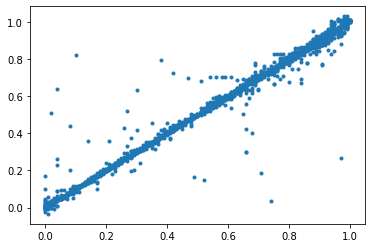

In [4]:
model.eval()
#eval_meter = Meter()
cn_p=[];area_p=[];cn_t=[];area_t=[]
with torch.no_grad():
    for batch_id, batch_data in enumerate(test_loader):
        
        bg, labels_cablenumber,labels_area = batch_data
        labels_cablenumber = labels_cablenumber.to(args['device'])
        labels_area = labels_area.to(args['device'])
        #labels=[labels_cablenumber,labels_area]
        cn_t.append(labels_cablenumber.cpu().detach().numpy())
        area_t.append(labels_area.cpu().detach().numpy())
        
        prediction = regress(args, model, bg)
        cn_p.append(prediction[0].cpu().detach().numpy())
        area_p.append(prediction[1].cpu().detach().numpy())

cn_p=np.concatenate(cn_p,axis=0)
cn_p=np.argmax(cn_p,axis=1)
area_p=np.concatenate(area_p,axis=0)

cn_t=np.concatenate(cn_t,axis=0)
area_t=np.concatenate(area_t,axis=0)

print(cn_p.shape,area_p.shape,cn_t.shape,area_t.shape)

acc=np.sum(cn_p==cn_t)/len(cn_p)
print('acc: ',acc)
plt.plot(area_t,area_p,'.')